In [1]:
import sys
import os
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Add project root (two levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4
!ls && pwd

/home/mak/Documents/Optimization/Project
MonteCarlo.ipynb
/home/mak/Documents/Optimization/Project/src/simulation


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from datetime import datetime
from typing import List, Dict, Any
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

# --- 1. Helper to sample weather/labor paths from historical data --- #
def sample_weather_labor(weather_df, labor_df, weeks, seed=None, labor_scale=1/6):
    rng = np.random.default_rng(seed)

    # Sample weather capacity_factor per week from historical weekly distributions
    sampled_weather = weather_df[weather_df["year"] < 2023].groupby("week")["capacity_factor"].apply(
        lambda x: rng.normal(x.mean(), x.std() or 0.01)
    ).reindex(weeks, fill_value=1.0)

    # Sample labor from historical census variability
    mean_labor = labor_df["total_workers"].mean()
    std_labor = labor_df["total_workers"].std()
    sampled_labor = rng.normal(mean_labor, std_labor or 1.0) * labor_scale

    return sampled_weather.clip(0.2, 1.2), sampled_labor

# --- 2. Function to run one simulation --- #
def run_simulation(
    i: int,
    weather_df: pd.DataFrame,
    labor_df: pd.DataFrame,
    base_config: Dict[str, Any],
    fields_path: str,
    weekly_master_path: str,
    seed: int = None,
) -> Dict[str, Any]:
    try:
        target_year = base_config["target_year"]

        # Load master weekly
        wm_df = pd.read_csv(weekly_master_path)
        weeks = wm_df[wm_df["year"] == target_year]["week"].unique()

        # Sample stochastic inputs
        sampled_weather, sampled_labor = sample_weather_labor(weather_df, labor_df, weeks, seed=seed)

        # Modify weekly master with sampled weather + labor
        wm_df.loc[wm_df["year"] == target_year, "capacity_factor"] = wm_df["week"].map(sampled_weather).fillna(1.0)
        wm_df.loc[wm_df["year"] == target_year, "labor_hours"] = sampled_labor

        # Save temporary version
        temp_path = f"/mnt/data/temp_wm_scenario_{i}.csv"
        wm_df.to_csv(temp_path, index=False)

        # Solve MILP with sampled input
        df_result = build_and_solve_schedule_v4(
            fields_path=fields_path,
            weekly_master_path=temp_path,
            target_year=target_year,
            base_planter_capacity=base_config["base_planter_capacity"],
            base_harvester_capacity=base_config["base_harvester_capacity"],
            labor_plant_per_acre=base_config["labor_plant_per_acre"],
            labor_harvest_per_acre=base_config["labor_harvest_per_acre"],
            early_penalty_weight=base_config["early_penalty_weight"],
            late_penalty_weight=base_config["late_penalty_weight"],
            time_limit=base_config.get("time_limit", 60),
        )

        # Summarize results
        return {
            "sim_id": i,
            "objective": df_result["objective_makespan"].max(),
            "penalty": df_result["penalty"].sum(),
            "num_late": (df_result["status"] == 3).sum(),
            "num_early": (df_result["status"] == 1).sum(),
        }

    except Exception as e:
        return {
            "sim_id": i,
            "objective": np.nan,
            "penalty": np.nan,
            "num_late": np.nan,
            "num_early": np.nan,
            "error": str(e),
        }

# --- 3. Run Monte Carlo in parallel --- #
def run_monte_carlo_simulation(
    n: int,
    weather_df: pd.DataFrame,
    labor_df: pd.DataFrame,
    base_config: Dict[str, Any],
    fields_path: str,
    weekly_master_path: str,
    n_jobs: int = -1,
) -> pd.DataFrame:
    print(f"Launching {n} Monte Carlo simulations...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_simulation)(
            i,
            weather_df,
            labor_df,
            base_config,
            fields_path,
            weekly_master_path,
            seed=1000 + i,
        )
        for i in range(n)
    )
    return pd.DataFrame(results)

# --- 4. Plot results --- #
def plot_simulation_results(results_df: pd.DataFrame):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Makespan CDF
    results_df["objective"].dropna().sort_values().reset_index(drop=True).plot(
        ax=axes[0], title="CDF of Completion Time (Makespan)"
    )
    axes[0].set_ylabel("Weeks")
    axes[0].set_xlabel("Simulation (sorted)")

    # Penalty Histogram
    results_df["penalty"].hist(ax=axes[1], bins=20)
    axes[1].set_title("Histogram of Total Penalties")
    axes[1].set_xlabel("Penalty")

    # Bottleneck Analysis
    results_df["num_late"].hist(ax=axes[2], bins=20, alpha=0.7, label="Late")
    results_df["num_early"].hist(ax=axes[2], bins=20, alpha=0.7, label="Early")
    axes[2].legend()
    axes[2].set_title("Early vs Late Fields")
    plt.tight_layout()
    plt.show()


In [9]:
!ls

MonteCarlo.ipynb


In [18]:
import sys
import os

# Add project root (two levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents/Optimization/Project


In [49]:
# Reload the data

# Load weather and labor data from absolute paths or relative to notebook
weather_df = pd.read_csv("../../data/processed/noaa_il_weekly_agg.csv")
labor_df = pd.read_csv("../../data/raw/no_of_worker2.csv")




Launching 100 Monte Carlo simulations...


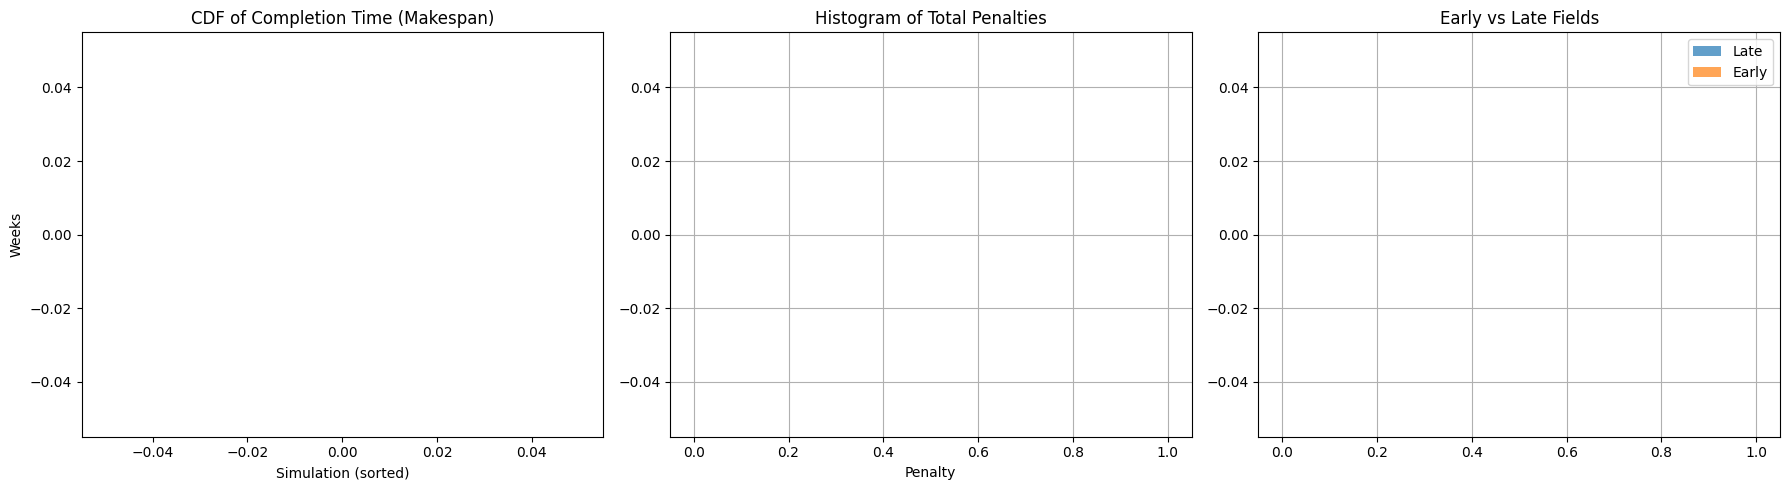

In [29]:
# Define config
config = {
    "target_year": 2017,
    "base_planter_capacity": 1400.0,
    "base_harvester_capacity": 950.0,
    "labor_plant_per_acre": 0.15,
    "labor_harvest_per_acre": 0.20,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "time_limit": 60,
}

# File paths
fields_path = "data/processed/illinois_corn_fields_clean.csv"
weekly_master_path = "data/processed/master_weekly_table.csv"

# Run simulations
results_df = run_monte_carlo_simulation(
    n=100,
    weather_df=weather_df,
    labor_df=labor_df,
    base_config=config,
    fields_path=fields_path,
    weekly_master_path=weekly_master_path,
    n_jobs=-1,
)

# Plot
plot_simulation_results(results_df)


In [31]:
import seaborn as sns

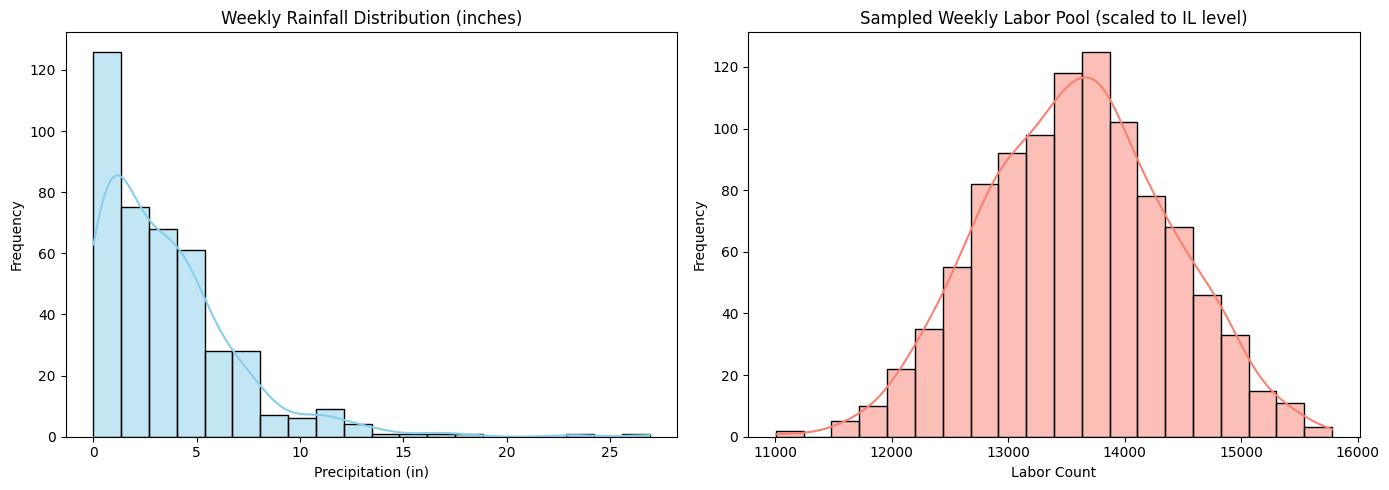

In [32]:
# Clean labor data with better error handling
labor_df["Value"] = labor_df["Value"].replace(",", "", regex=True).astype(float)

# Remove any non-numeric characters from CV (%) and convert
labor_df["CV (%)"] = labor_df["CV (%)"].replace("[^0-9.]", "", regex=True)
labor_df["CV (%)"] = pd.to_numeric(labor_df["CV (%)"], errors="coerce")

# Drop rows where CV could not be converted
labor_df_cleaned = labor_df.dropna(subset=["CV (%)", "Value"])

# Compute summary stats for sampling
prcp_mean = weather_df["prcp_week_in"].mean()
prcp_std = weather_df["prcp_week_in"].std()

# Get hired labor and its coefficient of variation
hired_labor = labor_df_cleaned[labor_df_cleaned["Data Item"] == "LABOR, HIRED - NUMBER OF WORKERS"]
labor_mean = hired_labor["Value"].mean()
labor_cv = hired_labor["CV (%)"].mean()
labor_std = labor_mean * labor_cv / 100

# Visualize both distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Rainfall distribution
sns.histplot(weather_df["prcp_week_in"], kde=True, ax=axs[0], bins=20, color="skyblue")
axs[0].set_title("Weekly Rainfall Distribution (inches)")
axs[0].set_xlabel("Precipitation (in)")
axs[0].set_ylabel("Frequency")

# Labor availability distribution
sampled_labor = np.random.normal(loc=labor_mean, scale=labor_std, size=1000)
sns.histplot(sampled_labor, kde=True, ax=axs[1], bins=20, color="salmon")
axs[1].set_title("Sampled Weekly Labor Pool (scaled to IL level)")
axs[1].set_xlabel("Labor Count")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [41]:
labor_df.dtypes

Program              object
Year                  int64
Period               object
Week Ending         float64
Geo Level            object
State                object
State ANSI            int64
Ag District         float64
Ag District Code    float64
County              float64
County ANSI         float64
Zip Code            float64
Region              float64
watershed_code        int64
Watershed           float64
Commodity            object
Data Item            object
Domain               object
Domain Category      object
Value               float64
CV (%)              float64
dtype: object

In [40]:
import numpy as np

# Simulate weekly weather modifier distributions
weather_summary = (
    weather_df.groupby("week")["prcp_week_in"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "rain_mean", "std": "rain_std"})
)

# Simulate labor availability distribution (from census Value column)
labor_df_clean = labor_df[labor_df["Data Item"].str.contains("HIRED") & labor_df["Value"].str.replace(",", "").str.isnumeric()]
labor_df_clean["value_numeric"] = labor_df_clean["Value"].str.replace(",", "").astype(float)

labor_mean = labor_df_clean["value_numeric"].mean()
labor_std = labor_df_clean["value_numeric"].std()

# Scale to 2,100 acres vs 12M (Illinois)
acre_scale = 2100 / 12_000_000
scaled_labor_mean = labor_mean * acre_scale
scaled_labor_std = labor_std * acre_scale



AttributeError: Can only use .str accessor with string values!

In [36]:
from joblib import Parallel, delayed

def run_monte_carlo_simulation(n, weather_summary, scaled_labor_mean, scaled_labor_std, config, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(
            i, weather_summary, scaled_labor_mean, scaled_labor_std, config
        ) for i in range(n)
    )
    return pd.DataFrame(results)


In [38]:
import matplotlib.pyplot as plt

def plot_simulation_results(results_df):
    ok_runs = results_df[results_df["status"] == "ok"]

    plt.figure(figsize=(10, 5))
    plt.hist(ok_runs["makespan"], bins=15, alpha=0.7, label="Makespan (weeks)")
    plt.axvline(ok_runs["makespan"].quantile(0.5), color="r", linestyle="--", label="P50")
    plt.axvline(ok_runs["makespan"].quantile(0.8), color="orange", linestyle="--", label="P80")
    plt.title("Distribution of Completion Week (Makespan)")
    plt.xlabel("Completion Week")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(ok_runs["penalty"], bins=15, alpha=0.7, color="coral")
    plt.title("Distribution of Total Penalties")
    plt.xlabel("Penalty")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


In [39]:
# Define config
config = {
    "fields_path": "data/processed/illinois_corn_fields_clean.csv",
    "weekly_master_path": "data/processed/master_weekly_table.csv",
    "target_year": 2017,
    "base_planter_capacity": 1400.0,
    "base_harvester_capacity": 950.0,
    "labor_plant_per_acre": 0.15,
    "labor_harvest_per_acre": 0.20,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "time_limit": 120
}

# Run Monte Carlo
results_df = run_monte_carlo_simulation(
    n=100,
    weather_summary=weather_summary,
    scaled_labor_mean=scaled_labor_mean,
    scaled_labor_std=scaled_labor_std,
    config=config,
    n_jobs=-1
)

# Plot
plot_simulation_results(results_df)


NameError: name 'scaled_labor_mean' is not defined

In [43]:
!pip install tqdm

In [52]:
import random
from tqdm import tqdm

# Assuming you have a working build_and_solve_schedule_v4
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

# === Monte Carlo Setup ===
n_simulations = 1000
target_year = 2017
field_path = "../../data/processed/illinois_corn_fields_clean.csv"
weekly_base_path = "../../data/processed/master_weekly_table_scaled.csv"


base_params = {
    "base_planter_capacity": 1400.0,
    "base_harvester_capacity": 950.0,
    "labor_plant_per_acre": 0.15,
    "labor_harvest_per_acre": 0.20,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "statewide_corn_acres": 12_000_000,
    "time_limit": 60,
}

simulation_results = []

# === Monte Carlo Loop ===
for sim in tqdm(range(n_simulations), desc="Running Monte Carlo Simulations"):
    wm_df = pd.read_csv(weekly_base_path)
    wm_2017 = wm_df[wm_df["year"] == target_year].copy()

    # Fallback for missing column
    if "harvest_weather_factor" not in wm_2017.columns:
        wm_2017["harvest_weather_factor"] = 1.0

    # === 1. Labor fluctuation ±10%
    labor_fluctuation = np.random.normal(loc=1.0, scale=0.1, size=len(wm_2017))
    wm_2017["labor_hours"] *= labor_fluctuation

    # === 2. Weather shock (random rain weeks)
    rain_weeks = np.random.choice(wm_2017["week"], size=5, replace=False)
    wm_2017.loc[wm_2017["week"].isin(rain_weeks), "harvest_weather_factor"] *= 0.7

    # Update back into the full table
    wm_df.loc[wm_df["year"] == target_year, "labor_hours"] = wm_2017["labor_hours"]
    wm_df.loc[wm_df["year"] == target_year, "harvest_weather_factor"] = wm_2017["harvest_weather_factor"]

    temp_path = f"../../data/processed/master_weekly_sim_{sim}.csv"
    wm_df.to_csv(temp_path, index=False)

    try:
        result_df = build_and_solve_schedule_v4(
            fields_path=field_path,
            weekly_master_path=temp_path,
            target_year=target_year,
            **base_params,
        )

        late_harvests = (result_df["harvest_week"] > result_df["harvest_week"].max() - 2).sum()
        simulation_results.append({
            "sim_id": sim,
            "makespan": result_df["objective_makespan"].max(),
            "total_penalty": result_df["penalty"].sum(),
            "late_harvests": late_harvests,
        })
    except Exception as e:
        simulation_results.append({
            "sim_id": sim,
            "makespan": None,
            "total_penalty": None,
            "late_harvests": None,
            "error": str(e),
        })

# === Final Results
results_df = pd.DataFrame(simulation_results)
results_df.to_csv("../../data/processed/monte_carlo_results.csv", index=False)
print("Saved to /mnt/data/monte_carlo_results.csv")


Running Monte Carlo Simulations:   0%|          | 0/1000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc0f20672
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve 

Running Monte Carlo Simulations:   0%|          | 1/1000 [01:00<16:48:05, 60.55s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1c73be15
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   0%|          | 2/1000 [02:00<16:43:39, 60.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x374d400a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   0%|          | 3/1000 [02:00<9:05:54, 32.85s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb2eb4206
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   0%|          | 4/1000 [02:01<5:31:07, 19.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbf6093f5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:   0%|          | 5/1000 [03:01<9:31:03, 34.44s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd5450d89
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:   1%|          | 7/1000 [04:01<8:53:20, 32.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x927671c4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:   1%|          | 9/1000 [05:01<8:37:47, 31.35s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x152a9665
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:   1%|          | 11/1000 [06:01<8:29:07, 30.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfecf00a3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:   1%|▏         | 13/1000 [06:02<5:31:16, 20.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1e902b50
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 15/1000 [07:02<6:25:02, 23.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0327d339
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 16/1000 [08:02<8:20:05, 30.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8a7cb49a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 17/1000 [09:02<10:04:05, 36.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xed9f09f3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 18/1000 [10:02<11:32:51, 42.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf4a79220
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 19/1000 [11:02<12:45:35, 46.82s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8197a08a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 20/1000 [12:02<13:42:21, 50.35s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3d39de6f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 21/1000 [13:03<14:25:18, 53.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8eed47ed
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 22/1000 [13:03<10:21:40, 38.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x74b3162e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 23/1000 [14:03<12:03:49, 44.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x888cf1e4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▏         | 24/1000 [14:03<8:33:30, 31.57s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x43d70c79
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   2%|▎         | 25/1000 [15:03<10:49:17, 39.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x84a22cf8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 26/1000 [15:03<7:37:39, 28.19s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6eb8ce3e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 27/1000 [16:03<10:11:11, 37.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcb3e021e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 28/1000 [17:04<11:59:01, 44.38s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x19684faf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 29/1000 [17:04<8:24:37, 31.18s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb30b41e5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 30/1000 [18:04<10:44:06, 39.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xba669b61
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 31/1000 [18:04<7:31:28, 27.96s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0b554acd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 32/1000 [19:04<10:06:33, 37.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x12d05b77
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 33/1000 [20:04<11:54:39, 44.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8a396e50
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:   3%|▎         | 34/1000 [21:04<13:10:07, 49.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8ed98d76
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▎         | 35/1000 [22:05<14:02:40, 52.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xede365d6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▎         | 36/1000 [22:05<9:49:59, 36.72s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x25772d65
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▎         | 37/1000 [23:05<11:42:15, 43.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x42a1f0ea
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 38/1000 [24:05<13:00:22, 48.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb08a961b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 39/1000 [25:05<13:54:34, 52.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x58620e89
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 40/1000 [25:05<9:44:08, 36.51s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc2c288fb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 41/1000 [26:05<11:36:47, 43.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8dc1049e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 42/1000 [27:06<12:55:29, 48.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe0ca7065
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 43/1000 [28:06<13:49:47, 52.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x28278367
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:   4%|▍         | 45/1000 [28:06<7:26:31, 28.05s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xad71fe4a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▍         | 46/1000 [29:06<9:32:20, 36.00s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3be63bc0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▍         | 48/1000 [30:06<8:52:34, 33.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x51087bf6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▍         | 49/1000 [30:06<6:50:50, 25.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc8a01257
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▌         | 50/1000 [31:06<9:03:39, 34.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7d9650f9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▌         | 51/1000 [32:07<10:49:16, 41.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9b2c91e1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▌         | 52/1000 [33:07<12:10:25, 46.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x53b17306
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▌         | 53/1000 [34:07<13:11:18, 50.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6a169381
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   5%|▌         | 54/1000 [35:07<13:55:48, 53.01s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa93ec250
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 55/1000 [36:07<14:27:26, 55.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xac8b4515
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 56/1000 [36:07<10:13:34, 39.00s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x87f5145d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 57/1000 [37:08<11:50:52, 45.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa539bccf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 58/1000 [38:08<12:59:31, 49.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa57011ba
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 59/1000 [38:08<9:07:38, 34.92s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x62c83c8b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 60/1000 [38:08<6:24:27, 24.54s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc72d21b8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.03s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 61/1000 [39:08<9:10:23, 35.17s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2ed70b12
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▌         | 62/1000 [40:08<11:06:57, 42.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe083980b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▋         | 63/1000 [41:08<12:27:55, 47.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8ee8bcd8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▋         | 64/1000 [42:09<13:24:23, 51.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd688d52c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:   6%|▋         | 65/1000 [43:09<14:03:28, 54.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x726e7f24
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 66/1000 [43:09<9:50:26, 37.93s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x619740c4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 67/1000 [44:09<11:33:12, 44.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa04ddf8d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 68/1000 [45:09<12:45:14, 49.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x36c17402
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 69/1000 [46:09<13:34:53, 52.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x39177363
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 70/1000 [47:09<14:09:24, 54.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd86c9763
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 71/1000 [47:09<9:54:26, 38.39s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa5604178
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 72/1000 [48:10<11:34:34, 44.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x926e8e5f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 73/1000 [49:10<12:44:09, 49.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc190e181
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   7%|▋         | 74/1000 [50:10<13:32:33, 52.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x373a5343
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 76/1000 [50:10<7:17:09, 28.39s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x462e1d43
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 76/1000 [50:29<7:17:09, 28.39s/it]

 29493 13740  135.30132   42  125  145.00000  134.13467  7.49%  18.4   20s
H29581 13118                     144.9999966  134.65274  7.14%  18.8   21s
H30162 12677                     137.5000000  134.65274  2.07%  19.1   22s
H31268 12479                     137.4999966  134.95823  1.85%  19.1   22s
 36612 14324     cutoff   65       137.50000  135.07955  1.76%  19.8   25s
 47668 17021  136.33836   62   70  137.50000  135.23886  1.64%  22.3   30s
 56953 19496  135.37567   55   77  137.50000  135.31900  1.59%  24.4   35s
 59372 19636  137.49822   78  131  137.50000  135.31900  1.59%  25.0   40s
H59380 18658                     137.4999965  135.31900  1.59%  25.0   40s
 64651 20347 infeasible  100       137.50000  135.31900  1.59%  25.9   45s
 73692 22728  136.37132   73   84  137.50000  135.31900  1.59%  28.0   50s
 75903 23221  137.24700   86   42  137.50000  135.31900  1.59%  28.0   55s
 88447 25116  135.38981   74   45  137.50000  135.31900  1.59%  28.2   60s

Cutting planes:
  Gomory

Running Monte Carlo Simulations:   8%|▊         | 77/1000 [51:10<9:17:35, 36.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5f254d3c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 78/1000 [51:10<6:51:46, 26.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb0d7e1ba
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 79/1000 [52:10<9:10:37, 35.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xef1894ff
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 80/1000 [52:10<6:36:47, 25.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0e0577a4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 81/1000 [53:10<9:06:07, 35.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf34c5642
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 82/1000 [54:11<10:53:52, 42.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x46f0d808
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 84/1000 [54:11<5:57:35, 23.42s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfddb11bb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   8%|▊         | 85/1000 [55:11<8:14:13, 32.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x014c0f9d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▊         | 87/1000 [56:11<7:58:43, 31.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe98422fc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 88/1000 [57:11<9:37:04, 37.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x458cf413
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 27 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 553 columns, 1481 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 89/1000 [57:11<7:15:40, 28.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4fdacfd4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 90/1000 [58:12<9:18:54, 36.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x966eca2e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 91/1000 [59:12<10:53:24, 43.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf6f40047
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 92/1000 [1:00:12<12:04:15, 47.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x16bde42e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 93/1000 [1:01:12<12:56:26, 51.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe03e0911
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:   9%|▉         | 94/1000 [1:02:12<13:33:44, 53.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf6aa8c89
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|▉         | 96/1000 [1:03:12<10:49:44, 43.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x796329bd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|▉         | 97/1000 [1:04:12<11:51:32, 47.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8673c372
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|▉         | 99/1000 [1:05:13<10:04:04, 40.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf13dd89d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|█         | 100/1000 [1:05:13<7:46:49, 31.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4cbfdbf1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|█         | 101/1000 [1:05:13<5:52:33, 23.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x682f20e3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|█         | 102/1000 [1:06:13<8:14:00, 33.01s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb66d34ab
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|█         | 103/1000 [1:07:13<10:02:54, 40.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe09e56a3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|█         | 104/1000 [1:08:13<11:24:38, 45.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3af59906
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  10%|█         | 105/1000 [1:09:13<12:24:41, 49.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x66905785
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 106/1000 [1:10:14<13:08:20, 52.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0df2912c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 107/1000 [1:10:14<9:17:51, 37.48s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc0ebaaf5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 108/1000 [1:11:14<10:56:59, 44.19s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9b719782
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 109/1000 [1:12:14<12:06:18, 48.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5774e335
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 110/1000 [1:12:14<8:30:17, 34.40s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe98db345
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 111/1000 [1:13:14<10:23:22, 42.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbab656cc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█         | 112/1000 [1:13:14<7:17:08, 29.54s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x24fc25df
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  11%|█▏        | 114/1000 [1:14:15<7:20:17, 29.82s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x21935f6e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 115/1000 [1:14:15<5:31:25, 22.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf5cbfdeb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 116/1000 [1:15:15<7:56:04, 32.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x74649894
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 117/1000 [1:16:15<9:46:55, 39.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb65cb6a8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 119/1000 [1:17:15<8:42:57, 35.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe206707e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 120/1000 [1:17:16<6:38:27, 27.17s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc54ebebf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 121/1000 [1:17:16<4:57:30, 20.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4b518c01
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 122/1000 [1:17:16<3:38:33, 14.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf02251e3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 123/1000 [1:18:16<6:40:17, 27.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x902327b7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▏        | 124/1000 [1:19:16<8:55:10, 36.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x30df62a0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  12%|█▎        | 125/1000 [1:20:16<10:33:02, 43.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x114daeb5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 126/1000 [1:20:16<7:28:43, 30.81s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x09176a95
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 127/1000 [1:20:17<5:17:09, 21.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x84addb65
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 128/1000 [1:21:17<8:01:28, 33.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd218a59c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 129/1000 [1:21:17<5:38:35, 23.32s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x98dc6fc4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 130/1000 [1:21:17<3:57:59, 16.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x56351f37
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 131/1000 [1:22:17<7:06:49, 29.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6ba9a3a6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 132/1000 [1:23:17<9:18:48, 38.63s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd3707b51
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 133/1000 [1:23:17<6:31:35, 27.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0ff2a282
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  13%|█▎        | 134/1000 [1:23:17<4:34:30, 19.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xba951fbd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▎        | 135/1000 [1:24:18<7:31:55, 31.35s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9b29a19b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▎        | 136/1000 [1:25:18<9:35:52, 39.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x96a2441f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 25 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 551 columns, 1475 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▎        | 137/1000 [1:25:18<6:43:12, 28.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x571bc9d6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 138/1000 [1:26:18<9:01:08, 37.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdf955e94
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 139/1000 [1:26:18<6:19:01, 26.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbdf14dfe
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 27 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 553 columns, 1481 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 140/1000 [1:27:18<8:43:39, 36.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x11eb778a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 141/1000 [1:28:18<10:24:42, 43.63s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x13acbb22
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 142/1000 [1:29:19<11:34:49, 48.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe019ab61
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 24 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 550 columns, 1472 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 143/1000 [1:30:19<12:23:41, 52.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4d792286
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 144/1000 [1:31:19<12:57:20, 54.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc94df9dc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  14%|█▍        | 145/1000 [1:32:09<12:35:22, 53.01s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9b73ad28
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▍        | 146/1000 [1:33:09<13:04:55, 55.15s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x57afe87f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▍        | 147/1000 [1:34:09<13:25:17, 56.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfe0cbc92
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▍        | 148/1000 [1:34:09<9:23:32, 39.69s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x05964799
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▍        | 149/1000 [1:34:09<6:34:27, 27.81s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcc334481
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▌        | 150/1000 [1:34:09<4:36:13, 19.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaecb8076
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▌        | 151/1000 [1:34:09<3:13:37, 13.68s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdd1e01ac
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▌        | 152/1000 [1:35:09<6:30:12, 27.61s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x77a7bd60
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▌        | 153/1000 [1:36:10<8:47:53, 37.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf3b5eb38
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  15%|█▌        | 154/1000 [1:37:10<10:24:26, 44.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb4f906a2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 155/1000 [1:38:10<11:30:41, 49.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf9131a9b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 156/1000 [1:39:10<12:16:32, 52.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x06fc3400
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 157/1000 [1:40:10<12:48:38, 54.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x35bb4ab5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 158/1000 [1:41:11<13:10:43, 56.35s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcd9d6050
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 159/1000 [1:41:11<9:13:22, 39.48s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcd775e78
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 160/1000 [1:42:11<10:39:22, 45.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7a821c1a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▌        | 162/1000 [1:43:11<8:57:54, 38.51s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0e0987db
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▋        | 163/1000 [1:44:11<10:12:25, 43.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd9cf1d4e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  16%|█▋        | 164/1000 [1:45:11<11:10:45, 48.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7de272d5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 166/1000 [1:46:12<9:22:05, 40.44s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2f9a660e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 167/1000 [1:46:12<7:10:22, 31.00s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc71f710a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 168/1000 [1:47:12<8:51:04, 38.30s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x99121f3a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 169/1000 [1:48:12<10:10:22, 44.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd364d127
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 170/1000 [1:49:12<11:10:26, 48.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3c1aadc1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 171/1000 [1:49:12<8:01:58, 34.88s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcbfe0ffa
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 172/1000 [1:49:13<5:44:04, 24.93s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfd6c18a8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 173/1000 [1:50:13<8:04:39, 35.16s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5e3d63ce
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  17%|█▋        | 174/1000 [1:51:13<9:45:33, 42.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x552d3f79
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 175/1000 [1:51:13<6:52:43, 30.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb7ee92de
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 176/1000 [1:51:13<4:50:32, 21.16s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9d76ddb7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 177/1000 [1:51:13<3:24:24, 14.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcf0b4890
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 178/1000 [1:52:14<6:29:07, 28.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x04b894f4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 179/1000 [1:53:14<8:38:22, 37.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x65d1488b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 180/1000 [1:53:14<6:03:17, 26.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x91e9b3c6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 181/1000 [1:53:14<4:14:39, 18.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf90c6491
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 182/1000 [1:53:14<2:58:36, 13.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa532fbdf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 183/1000 [1:53:14<2:05:21,  9.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0a6f9402
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  18%|█▊        | 184/1000 [1:54:14<5:33:00, 24.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x758e450b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▊        | 186/1000 [1:55:15<6:07:17, 27.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x551de282
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▊        | 187/1000 [1:56:15<7:58:06, 35.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x93ef4bd6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▉        | 188/1000 [1:56:15<5:53:07, 26.09s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8d463e01
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▉        | 189/1000 [1:57:15<7:57:49, 35.35s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbb356709
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▉        | 190/1000 [1:58:15<9:30:54, 42.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x90b9c682
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▉        | 191/1000 [1:58:15<6:47:47, 30.24s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4c7000da
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▉        | 192/1000 [1:59:15<8:44:08, 38.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x98762019
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  19%|█▉        | 193/1000 [1:59:16<6:10:38, 27.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3936cd52
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|█▉        | 195/1000 [2:00:16<6:25:21, 28.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8b925fc2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|█▉        | 196/1000 [2:00:16<4:50:49, 21.70s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3f483fed
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|█▉        | 197/1000 [2:01:16<7:04:04, 31.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x50c9688c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|█▉        | 198/1000 [2:02:16<8:46:19, 39.38s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x27b4b715
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.00s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|█▉        | 199/1000 [2:03:16<10:03:06, 45.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfe8a55d3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|██        | 200/1000 [2:03:16<7:11:10, 32.34s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xac8fbc69
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|██        | 201/1000 [2:04:17<8:57:39, 40.38s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2a30ce66
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|██        | 202/1000 [2:04:17<6:20:28, 28.61s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0838221c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.00s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|██        | 204/1000 [2:05:17<6:28:20, 29.27s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6f8606c3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  20%|██        | 205/1000 [2:06:17<8:08:05, 36.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9dccc5a8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██        | 206/1000 [2:06:17<6:01:19, 27.30s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x822d6c7a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██        | 208/1000 [2:06:17<3:27:28, 15.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x404c239a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██        | 209/1000 [2:07:17<5:44:04, 26.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6e2d0c7f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██        | 210/1000 [2:08:18<7:35:48, 34.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xadfa7a7d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██        | 212/1000 [2:09:18<7:10:03, 32.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd420fcc0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██▏       | 213/1000 [2:10:18<8:31:49, 39.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4fc45d38
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  21%|██▏       | 214/1000 [2:11:18<9:39:39, 44.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2bff1ac4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 215/1000 [2:11:18<7:08:31, 32.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8a637d20
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 216/1000 [2:12:18<8:44:58, 40.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0299ce55
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 218/1000 [2:13:19<7:46:17, 35.78s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb55b2f03
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 219/1000 [2:14:19<9:01:00, 41.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x933278f2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 220/1000 [2:14:19<6:43:40, 31.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x36b5e0ea
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 221/1000 [2:14:19<4:56:21, 22.83s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xea2b9ba4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 222/1000 [2:15:19<7:09:17, 33.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe976f288
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 223/1000 [2:16:19<8:47:48, 40.76s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5155e71b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 43 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 569 columns, 1529 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▏       | 224/1000 [2:17:20<9:59:03, 46.32s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc4252775
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  22%|██▎       | 225/1000 [2:18:20<10:50:26, 50.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x586fee15
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 226/1000 [2:19:20<11:27:03, 53.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2bb13fba
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 227/1000 [2:20:20<11:52:34, 55.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbd2d6428
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 228/1000 [2:21:20<12:10:02, 56.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbdd752db
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 229/1000 [2:22:20<12:22:07, 57.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcbdfe15b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 230/1000 [2:23:21<12:30:26, 58.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa84a8e0e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 232/1000 [2:24:21<9:41:22, 45.42s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7ac1fd30
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 233/1000 [2:25:21<10:27:12, 49.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7d80bfc3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  23%|██▎       | 234/1000 [2:26:21<11:03:22, 51.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x302acf9b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▎       | 235/1000 [2:27:21<11:31:09, 54.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe5d36eb7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▎       | 237/1000 [2:27:22<6:28:40, 30.56s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x47695016
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 238/1000 [2:28:22<7:57:32, 37.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x80266228
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 239/1000 [2:29:22<9:09:39, 43.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1d852173
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 26 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 552 columns, 1478 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 240/1000 [2:30:22<10:05:56, 47.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc27178dd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 241/1000 [2:31:22<10:48:09, 51.24s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7eec8845
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 242/1000 [2:31:22<7:45:01, 36.81s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc65d7699
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 243/1000 [2:32:23<9:09:00, 43.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x603e561b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 244/1000 [2:33:23<10:09:34, 48.38s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb350986c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  24%|██▍       | 245/1000 [2:34:23<10:52:09, 51.83s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdf242df6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▍       | 246/1000 [2:35:23<11:22:12, 54.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x82de0644
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▍       | 247/1000 [2:36:23<11:43:07, 56.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2033868f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▍       | 248/1000 [2:37:23<11:57:32, 57.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x42186621
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▍       | 249/1000 [2:38:24<12:07:37, 58.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x478a993b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▌       | 250/1000 [2:39:24<12:14:02, 58.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbb9633c4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▌       | 251/1000 [2:40:24<12:18:38, 59.17s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc6bc2033
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▌       | 252/1000 [2:41:24<12:21:25, 59.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x300afe33
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▌       | 253/1000 [2:41:24<8:39:00, 41.69s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe91e0794
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  25%|██▌       | 254/1000 [2:42:24<9:47:02, 47.22s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x227556c2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 255/1000 [2:43:24<10:34:16, 51.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x025d3270
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 256/1000 [2:44:25<11:07:05, 53.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd00b1e14
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 258/1000 [2:45:25<8:50:04, 42.86s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1814bb35
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 259/1000 [2:46:25<9:42:08, 47.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2fb69dfb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 260/1000 [2:47:25<10:23:35, 50.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe909b6bc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 261/1000 [2:48:25<10:54:55, 53.17s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8f585fe7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▌       | 262/1000 [2:49:25<11:17:55, 55.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x18854f98
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▋       | 263/1000 [2:49:26<8:04:06, 39.41s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x474912fe
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▋       | 264/1000 [2:49:26<5:43:43, 28.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x76f5c935
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  26%|██▋       | 265/1000 [2:49:26<4:03:13, 19.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7fa29226
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  27%|██▋       | 266/1000 [2:50:26<6:28:10, 31.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x31454e1e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  27%|██▋       | 267/1000 [2:50:26<4:33:07, 22.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x643004f3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 27 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 553 columns, 1481 nonzeros
Presolved 

Running Monte Carlo Simulations:  27%|██▋       | 268/1000 [2:50:26<3:12:02, 15.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0a536f31
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  27%|██▋       | 270/1000 [2:50:26<1:44:00,  8.55s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8b47eb07
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  27%|██▋       | 271/1000 [2:51:27<4:19:03, 21.32s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2e54413b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  27%|██▋       | 273/1000 [2:52:27<5:02:39, 24.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3b5fe565
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 275/1000 [2:52:27<3:10:03, 15.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe99d170f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 275/1000 [2:52:40<3:10:03, 15.73s/it]

 55611 26840  117.39299   50   33  129.99996  114.14191  12.2%  10.3   15s
 86037 39982  121.24385   85   23  129.99996  114.55405  11.9%  10.8   20s
 111763 50239     cutoff   65       129.99996  114.55445  11.9%  11.4   25s
 137498 68089  121.99614   65   43  129.99996  114.55641  11.9%  11.6   30s
 163889 86337  116.31107   87   41  129.99996  114.55764  11.9%  11.8   35s
 193013 106931  121.38702   74   30  129.99996  114.55874  11.9%  11.8   40s
 218623 125172  120.50525   88   35  129.99996  114.55940  11.9%  11.8   45s
 244920 142517  114.56723   72   52  129.99996  114.55946  11.9%  12.0   50s
 263730 155693 infeasible   90       129.99996  114.55980  11.9%  12.1   55s

Cutting planes:
  Gomory: 33
  Cover: 24
  Implied bound: 3
  MIR: 116
  StrongCG: 6
  Flow cover: 64
  GUB cover: 3
  Zero half: 4
  RLT: 1
  Relax-and-lift: 14

Explored 288971 nodes (3512867 simplex iterations) in 60.02 seconds (25.67 work units)
Thread count was 8 (of 8 available processors)

Solution count 

Running Monte Carlo Simulations:  28%|██▊       | 277/1000 [2:53:27<4:09:54, 20.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x733ffe36
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 279/1000 [2:53:28<2:47:01, 13.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdc75fcbb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 279/1000 [2:53:40<2:47:01, 13.90s/it]

 26692 14537  115.86571   36   64  122.49996  111.31803  9.13%  21.0   15s
 43428 21340  122.44231   75   42  122.49996  112.20519  8.40%  21.4   20s
 44323 21362  119.13239   68   61  122.49996  115.76039  5.50%  21.4   25s
 44538 21506  116.32733   53   65  122.49996  116.06361  5.25%  21.7   30s
 53744 25351  119.08318   75   73  122.49996  116.32737  5.04%  21.8   35s
 64921 30102     cutoff   77       122.49996  116.32750  5.04%  22.5   40s
 76238 34339     cutoff   75       122.49996  116.33251  5.03%  23.0   45s
 86485 37931  118.34867   63   40  122.49996  116.36552  5.01%  23.4   50s
 95679 40826  117.46627   79   55  122.49996  116.42426  4.96%  23.5   55s
 103309 43745  116.75398   57   60  122.49996  116.44045  4.95%  23.8   60s

Cutting planes:
  Learned: 1
  Gomory: 26
  Cover: 409
  Implied bound: 1
  MIR: 148
  StrongCG: 19
  Flow cover: 94
  GUB cover: 20
  Zero half: 8
  Relax-and-lift: 25

Explored 103697 nodes (2474304 simplex iterations) in 60.02 seconds (28.47 wor

Running Monte Carlo Simulations:  28%|██▊       | 280/1000 [2:54:28<4:32:55, 22.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4b933eb1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 281/1000 [2:55:28<6:08:40, 30.77s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb66c852f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 282/1000 [2:56:28<7:30:32, 37.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x87e751f7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 283/1000 [2:57:28<8:37:16, 43.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaae17c75
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  28%|██▊       | 284/1000 [2:58:28<9:29:37, 47.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5219944b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  29%|██▊       | 286/1000 [2:59:28<7:58:04, 40.17s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa61d4825
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  29%|██▊       | 287/1000 [3:00:29<8:53:01, 44.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8d68090b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  29%|██▉       | 289/1000 [3:00:29<5:18:25, 26.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x25e5fbdd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  29%|██▉       | 289/1000 [3:00:40<5:18:25, 26.87s/it]

 29715 19845   87.36545   35  107          -   80.74084      -  11.9   11s
 32451 21422   86.05811   62   36          -   85.11321      -  12.4   15s
H36547 22047                     121.5000000   85.11501  29.9%  12.8   15s
H40473 22710                     121.4999965   85.11539  29.9%  13.2   17s
H40498 21583                     114.0000000   85.11539  25.3%  13.2   17s
H40609 20198                     106.5000000   85.11539  20.1%  13.2   17s
H42934 19315                      99.0000000   85.11585  14.0%  13.5   18s
H44173 18609                      98.9999952   85.11747  14.0%  13.7   19s
H44175 17679                      98.9999920   85.11747  14.0%  13.7   19s
 44179 17682   85.14785   39   25   98.99999   85.11747  14.0%  13.7   20s
 52654 19279   85.42966   61   49   98.99999   85.14784  14.0%  14.4   25s
H57261 19039                      98.9999637   85.14822  14.0%  14.9   27s
 59431 19820     cutoff   73        98.99996   85.14822  14.0%  15.0   30s
 68096 21020   87.26624  

Running Monte Carlo Simulations:  29%|██▉       | 290/1000 [3:01:29<6:45:36, 34.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5ee24fd1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  29%|██▉       | 291/1000 [3:02:29<7:58:48, 40.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf2b10e10
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  29%|██▉       | 293/1000 [3:03:29<7:07:15, 36.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe2ce3c7e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|██▉       | 295/1000 [3:04:29<6:39:24, 33.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x61b33fc9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|██▉       | 297/1000 [3:04:29<4:21:15, 22.30s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3d5c75a1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|██▉       | 297/1000 [3:04:40<4:21:15, 22.30s/it]

 17141 11274  109.40282   97   20  122.49999  105.35475  14.0%  30.0   15s
H29996 15677                     122.4999897  105.63801  13.8%  26.6   19s
 31950 16770  108.57881   68   37  122.49999  105.79093  13.6%  26.2   20s
H34894 16769                     122.4999862  105.90609  13.5%  25.9   20s
H35449 16570                     122.4999828  105.93611  13.5%  25.8   21s
 43903 20445  112.72970   89   96  122.49998  106.51641  13.0%  25.0   26s
 43952 20478  116.56312  110  130  122.49998  106.51641  13.0%  24.9   30s
H44094 19556                     122.4999828  106.51641  13.0%  25.2   33s
 44639 19868  118.19494  110   15  122.49998  106.51641  13.0%  25.2   35s
 58408 25485  108.54519   81   40  122.49998  108.33599  11.6%  24.1   40s
 72600 30974  108.54629   81   55  122.49998  108.37146  11.5%  23.7   45s
 87995 36266     cutoff  111       122.49998  108.37158  11.5%  22.8   50s
 99202 40465  113.04554  114   30  122.49998  108.37158  11.5%  22.3   55s
 110904 47319  108.91681 

Running Monte Carlo Simulations:  30%|██▉       | 299/1000 [3:05:30<4:50:38, 24.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x70e6e977
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|███       | 300/1000 [3:06:30<6:08:37, 31.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x70717a6b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|███       | 301/1000 [3:07:30<7:19:16, 37.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7207b1d5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|███       | 302/1000 [3:08:30<8:19:45, 42.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3eb01d15
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|███       | 304/1000 [3:08:30<4:58:51, 25.76s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x80240bc8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  30%|███       | 304/1000 [3:08:50<4:58:51, 25.76s/it]

 33884 20416  137.39071  124   28  144.99993  126.25971  12.9%  25.7   20s
 49185 27229  129.68823   97   28  144.99993  126.80130  12.6%  24.6   25s
 58950 30850  127.77489  102   79  144.99993  126.86631  12.5%  24.1   30s
 59156 31004  128.58583   73   42  144.99993  126.86631  12.5%  24.2   35s
 71431 36683  140.73712  103   64  144.99993  126.91301  12.5%  24.6   40s
 85743 41866  129.44792   78   76  144.99993  126.92785  12.5%  25.0   45s
 93467 45418  127.56005   83   49  144.99993  126.92787  12.5%  25.6   50s
 101504 48287  135.15375   95   75  144.99993  126.92787  12.5%  25.9   55s
 113025 52463  129.23751   90   64  144.99993  126.92790  12.5%  26.0   60s

Cutting planes:
  Gomory: 22
  Cover: 299
  MIR: 167
  StrongCG: 28
  Flow cover: 78
  GUB cover: 9
  Inf proof: 4
  Zero half: 10
  Relax-and-lift: 16

Explored 113907 nodes (2967137 simplex iterations) in 60.07 seconds (30.60 work units)
Thread count was 8 (of 8 available processors)

Solution count 8: 145 145 152.5 ..

Running Monte Carlo Simulations:  31%|███       | 306/1000 [3:09:30<5:16:26, 27.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5df6f4e5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███       | 307/1000 [3:10:31<6:34:05, 34.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x62d10a84
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███       | 308/1000 [3:11:31<7:42:07, 40.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x96f6e0d4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███       | 309/1000 [3:12:31<8:38:03, 44.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x185755dc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███       | 310/1000 [3:13:31<9:22:28, 48.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0dd789e3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███       | 311/1000 [3:14:31<9:56:28, 51.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcfdbcaf0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███       | 312/1000 [3:15:31<10:21:47, 54.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x62f33100
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  31%|███▏      | 314/1000 [3:16:31<8:17:37, 43.52s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9977ed36
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 315/1000 [3:17:32<9:02:30, 47.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x876653a2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 317/1000 [3:18:32<7:40:08, 40.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8f8de13a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 318/1000 [3:19:32<8:29:48, 44.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x61b43377
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 320/1000 [3:19:32<5:09:31, 27.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0a2197ad
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.00s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 320/1000 [3:19:50<5:09:31, 27.31s/it]

 62166 29723  116.08510   67   25  122.49978  102.71848  16.1%  13.5   20s
 78698 36913  105.83888   69   55  122.49978  103.08779  15.8%  15.1   25s
 96285 44531  118.29075   88   25  122.49978  103.38023  15.6%  16.3   30s
 117232 56762  114.84785   75   37  122.49978  103.60233  15.4%  16.8   35s
 138749 72895  110.30214   66   54  122.49978  103.74553  15.3%  17.0   40s
 157791 87281  120.85026  110   24  122.49978  103.84348  15.2%  17.2   45s
 169420 96059  115.39167   93   44  122.49978  103.89818  15.2%  17.3   50s
 185209 107866  106.28959   91   46  122.49978  103.97145  15.1%  17.3   55s
 205283 122650  121.55686  103   25  122.49978  104.04907  15.1%  17.4   60s

Cutting planes:
  Learned: 1
  Gomory: 20
  Cover: 36
  Implied bound: 5
  MIR: 150
  StrongCG: 7
  Flow cover: 69
  GUB cover: 14
  Zero half: 3
  Mod-K: 1
  RLT: 3
  Relax-and-lift: 15

Explored 205331 nodes (3574713 simplex iterations) in 60.02 seconds (27.20 work units)
Thread count was 8 (of 8 available proces

Running Monte Carlo Simulations:  32%|███▏      | 321/1000 [3:20:32<6:30:28, 34.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf49dca8a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 322/1000 [3:21:32<7:38:50, 40.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2d0fdf05
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 323/1000 [3:22:32<8:34:02, 45.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb5378832
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▏      | 324/1000 [3:23:33<9:16:52, 49.43s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa3995a0d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  32%|███▎      | 325/1000 [3:24:33<9:49:04, 52.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5f7fa53b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  33%|███▎      | 326/1000 [3:25:33<10:12:57, 54.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3666c63a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  33%|███▎      | 327/1000 [3:26:33<10:29:59, 56.17s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1bb26e7d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  33%|███▎      | 328/1000 [3:27:33<10:41:53, 57.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x57c6e527
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  33%|███▎      | 330/1000 [3:28:33<8:21:56, 44.95s/it] 

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0203bdb6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  33%|███▎      | 332/1000 [3:29:33<7:15:24, 39.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4aa5705a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  33%|███▎      | 333/1000 [3:30:34<8:05:59, 43.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x770750dd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▎      | 335/1000 [3:31:34<7:06:23, 38.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x320446c0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▎      | 337/1000 [3:32:34<6:32:20, 35.51s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2fa8fd67
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 338/1000 [3:33:34<7:26:42, 40.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xce1fb6b3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 339/1000 [3:34:34<8:14:30, 44.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x760e50e4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 340/1000 [3:35:34<8:54:24, 48.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7aeb147e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 341/1000 [3:36:34<9:26:08, 51.55s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x19ab8dee
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 343/1000 [3:37:35<7:44:51, 42.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb8975e58
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 344/1000 [3:38:35<8:29:02, 46.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb66cd975
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  34%|███▍      | 345/1000 [3:39:35<9:05:14, 49.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb05ba002
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  35%|███▍      | 347/1000 [3:40:35<7:33:44, 41.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x97c19cd1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  35%|███▍      | 348/1000 [3:41:35<8:18:54, 45.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbb6d7db4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  35%|███▍      | 349/1000 [3:42:35<8:56:09, 49.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbbda15b7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  35%|███▌      | 350/1000 [3:43:36<9:25:46, 52.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x17cdaa0a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  35%|███▌      | 352/1000 [3:43:36<5:23:45, 29.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3a58a322
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  35%|███▌      | 352/1000 [3:43:50<5:23:45, 29.98s/it]

 59201 21389  109.65724   49   54  122.49999  108.12248  11.7%   8.6   15s
 69746 25946  112.12412   77   29  122.49999  108.71200  11.3%  10.5   20s
 87893 32899  118.75566   79   33  122.49999  108.97358  11.0%  12.9   25s
 106249 39377  122.43467  113   26  122.49999  109.13890  10.9%  14.2   30s
 124676 46568  116.73061   69   46  122.49999  109.25020  10.8%  15.2   35s
 142817 58798  111.57536   66   53  122.49999  109.31121  10.8%  15.8   40s
 157225 68569  117.19105   79   31  122.49999  109.36328  10.7%  16.3   45s
 170491 77331  110.20760   88   40  122.49999  109.39919  10.7%  16.6   50s
 189498 89937  109.52941   60   32  122.49999  109.43220  10.7%  17.2   55s
 209524 102458  116.99844   78   35  122.49999  109.47967  10.6%  17.5   60s

Cutting planes:
  Gomory: 26
  Cover: 26
  Implied bound: 4
  Projected implied bound: 1
  MIR: 129
  StrongCG: 20
  Flow cover: 69
  GUB cover: 14
  Zero half: 1
  Mod-K: 1
  RLT: 3
  Relax-and-lift: 15

Explored 209693 nodes (3669368 simpl

Running Monte Carlo Simulations:  35%|███▌      | 353/1000 [3:44:36<6:39:19, 37.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x67f36e17
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▌      | 355/1000 [3:44:36<3:59:05, 22.24s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4499ba6d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▌      | 355/1000 [3:44:50<3:59:05, 22.24s/it]

 28571 15965  103.21095   68   29  107.49998   94.49200  12.1%  20.5   15s
 44250 20769   97.35375   95   99  107.49998   94.49394  12.1%  20.3   20s
 53278 25009   94.55098   64   40  107.49998   94.51833  12.1%  20.6   25s
 59095 26970   96.14486   87   60  107.49998   94.53622  12.1%  20.7   30s
H59222 25710                     107.4999710   94.53622  12.1%  20.8   33s
 60399 26379   96.27983   83   26  107.49997   94.53622  12.1%  21.0   35s
 72739 31522   94.58545   76   57  107.49997   94.55684  12.0%  21.5   40s
 85414 36714  100.77900   79   30  107.49997   94.56743  12.0%  21.4   45s
 94757 40438   99.33661   98   40  107.49997   94.56806  12.0%  21.5   50s
 106658 44417   95.48463   82   39  107.49997   94.56835  12.0%  21.8   55s
 116910 47523     cutoff  104       107.49997   94.56846  12.0%  22.1   60s

Cutting planes:
  Gomory: 28
  Cover: 506
  Implied bound: 2
  MIR: 185
  Mixing: 1
  StrongCG: 22
  Flow cover: 109
  GUB cover: 19
  Inf proof: 1
  Zero half: 2
  Mod-K: 

Running Monte Carlo Simulations:  36%|███▌      | 357/1000 [3:45:36<4:28:59, 25.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf52264df
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▌      | 358/1000 [3:46:36<5:45:50, 32.32s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf2c415e1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▌      | 360/1000 [3:47:37<5:35:57, 31.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd472e182
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▌      | 361/1000 [3:48:37<6:39:12, 37.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5fd709d0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▌      | 362/1000 [3:49:37<7:33:55, 42.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0835b4c5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▋      | 363/1000 [3:50:37<8:18:56, 47.00s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8a72cd81
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  36%|███▋      | 364/1000 [3:50:37<6:08:18, 34.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd49a7ced
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 366/1000 [3:50:37<3:30:34, 19.93s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x537189c2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 366/1000 [3:50:50<3:30:34, 19.93s/it]

 21454 14016   76.26286   78   58   83.99976   70.95239  15.5%  22.7   15s
 29320 18415   74.18944   60   49   83.99976   71.72686  14.6%  23.0   20s
H29576 17659                      76.5000000   73.60245  3.79%  23.2   23s
H29604 16784                      76.4999931   73.60245  3.79%  23.2   23s
H29778 15979                      76.4999931   73.60574  3.78%  23.3   23s
H29852 15213                      76.4999931   73.60574  3.78%  23.3   23s
H29856 14460                      76.4999581   73.60574  3.78%  23.3   23s
 31103 14731   74.32482   59   51   76.49996   73.61931  3.77%  23.3   25s
H35483 14770                      76.4999581   73.67159  3.70%  23.9   27s
H36676 14227                      76.4999547   73.67398  3.69%  24.1   28s
H37525 13706                      76.4999546   73.68182  3.68%  24.3   29s
H37546 13084                      76.4999372   73.68536  3.68%  24.3   29s
 39263 13416   76.49985   55   35   76.49994   73.69535  3.67%  24.4   30s
 44399 13693   76.44260  

Running Monte Carlo Simulations:  37%|███▋      | 367/1000 [3:51:37<5:09:23, 29.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x583e189b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 368/1000 [3:52:37<6:30:08, 37.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9c775530
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 369/1000 [3:53:37<7:33:35, 43.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcab1ce4b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 370/1000 [3:54:38<8:21:47, 47.79s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x63997aa1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 372/1000 [3:55:38<6:58:55, 40.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd8af5449
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 373/1000 [3:56:38<7:48:19, 44.82s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9db0f834
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  37%|███▋      | 374/1000 [3:57:38<8:28:16, 48.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xadfa71b9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 375/1000 [3:58:38<8:59:05, 51.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x92b2a388
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 376/1000 [3:59:38<9:22:11, 54.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xad21f677
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 377/1000 [4:00:39<9:39:23, 55.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x45c38290
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 379/1000 [4:00:39<5:19:58, 30.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb9502815
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 379/1000 [4:00:50<5:19:58, 30.92s/it]

H14806  8608                     114.9999992   97.16162  15.5%  30.9   14s
 14814  8623   97.73199   32   73  115.00000   97.62164  15.1%  31.2   15s
H14870  8230                     114.9999791   97.64404  15.1%  31.2   15s
 27040 13007  106.14115   68   53  114.99998   98.34144  14.5%  26.1   20s
 36914 16704  103.10072   37   77  114.99998   99.31890  13.6%  24.8   25s
 45049 20594  106.02745   48  111  114.99998   99.49938  13.5%  23.9   31s
 45101 20629  107.87667   69  126  114.99998  100.97095  12.2%  23.9   35s
 45156 20665  111.49329   88  101  114.99998  101.14427  12.0%  23.9   40s
 45194 20691  108.99500   68  126  114.99998  101.14427  12.0%  23.9   45s
H45264 19702                     114.9999756  101.91192  11.4%  24.2   46s
 48291 21117  105.26527   43   62  114.99998  102.97710  10.5%  24.7   50s
 57346 25207  106.38597   75   56  114.99998  103.63548  9.88%  25.4   55s
 65566 28236  108.76108   79   27  114.99998  103.75408  9.78%  25.9   60s

Cutting planes:
  Gomory

Running Monte Carlo Simulations:  38%|███▊      | 380/1000 [4:01:39<6:32:27, 37.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7b49fca5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 381/1000 [4:01:39<4:51:28, 28.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2fb582cf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 381/1000 [4:01:50<4:51:28, 28.25s/it]

H15394  9999                     114.9999997   87.62133  23.8%  26.6   14s
H15461  9555                     114.9999931   87.62133  23.8%  26.7   14s
 15545  9605   88.34685   41   27  114.99999   87.62133  23.8%  26.9   15s
 25503 13978   95.40952   85   53  114.99999   87.66630  23.8%  24.6   20s
 30698 16115   95.75358   89   26  114.99999   87.66630  23.8%  24.2   25s
H35625 17506                     114.9999821   87.66630  23.8%  24.1   27s
 39125 18982   88.91178   48   86  114.99998   87.66630  23.8%  24.4   30s
 44505 21195   92.47769   97   38  114.99998   87.66630  23.8%  24.3   35s
H44666 20249                     114.9999821   87.66630  23.8%  24.5   36s
H44733 19275                     114.9999820   87.66630  23.8%  24.5   36s
H44742 18315                     114.9999816   87.66630  23.8%  24.5   36s
 47705 19917  111.90546   90   33  114.99998   87.72181  23.7%  24.3   40s
 57447 24120   92.89531   60   48  114.99998   87.72181  23.7%  23.4   45s
H58217 22967             

Running Monte Carlo Simulations:  38%|███▊      | 383/1000 [4:02:39<4:58:34, 29.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa35e9682
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 384/1000 [4:03:39<6:12:16, 36.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0f169ab5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  38%|███▊      | 385/1000 [4:04:39<7:12:33, 42.20s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3d3cffc2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  39%|███▊      | 386/1000 [4:05:40<7:59:55, 46.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0090b102
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  39%|███▊      | 387/1000 [4:06:40<8:36:02, 50.51s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6816d8e0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  39%|███▉      | 388/1000 [4:07:40<9:02:41, 53.20s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x04398113
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  39%|███▉      | 389/1000 [4:08:40<9:21:56, 55.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x667959a1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  39%|███▉      | 391/1000 [4:09:40<7:25:41, 43.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x22cfbb94
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  39%|███▉      | 393/1000 [4:09:40<4:30:48, 26.77s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x18a688f1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|███▉      | 395/1000 [4:09:40<2:53:28, 17.20s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x510e75ae
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|███▉      | 395/1000 [4:10:00<2:53:28, 17.20s/it]

 46997 26507   97.81544   63   52  122.49998   95.73762  21.8%  10.3   20s
 61520 34244   96.95545   67   53  122.49998   95.86403  21.7%  12.3   25s
 76410 39998  111.63593  104   51  122.49998   95.89469  21.7%  14.0   30s
 92073 46703  118.09508   95   32  122.49998   95.90160  21.7%  15.3   35s
 95327 47590  105.70211   85   44  122.49998   95.90177  21.7%  15.4   40s
 102935 51326  105.90182  116   60  122.49998   95.90333  21.7%  15.6   45s
 116786 57362   98.70532   80   73  122.49998   95.90561  21.7%  16.5   50s
 130322 66458  101.07401   63   50  122.49998   95.90694  21.7%  17.4   55s
 145141 77471     cutoff   82       122.49998   95.90711  21.7%  17.9   60s

Cutting planes:
  Learned: 1
  Gomory: 23
  Cover: 28
  MIR: 143
  StrongCG: 22
  Flow cover: 54
  GUB cover: 10
  Zero half: 3
  Relax-and-lift: 14

Explored 145932 nodes (2620689 simplex iterations) in 60.03 seconds (23.76 work units)
Thread count was 8 (of 8 available processors)

Solution count 8: 122.5 130 130 ...

Running Monte Carlo Simulations:  40%|███▉      | 396/1000 [4:10:41<4:21:22, 25.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xde7f0cdd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|███▉      | 397/1000 [4:11:41<5:38:21, 33.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc0d3b4ce
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|███▉      | 398/1000 [4:12:41<6:42:23, 40.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x24759271
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|███▉      | 399/1000 [4:13:41<7:33:25, 45.27s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1e837fb0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|████      | 400/1000 [4:14:41<8:12:41, 49.27s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x474275ac
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|████      | 401/1000 [4:14:41<5:55:25, 35.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x24637551
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|████      | 401/1000 [4:15:00<5:55:25, 35.60s/it]

 33882 17810   85.19367   51   66   99.99999   84.46327  15.5%  19.7   20s
 42508 21909   86.36352   54   49   99.99999   85.18840  14.8%  20.5   25s
H44444 21055                      99.9999930   85.18846  14.8%  20.8   29s
 44446 21056   86.21358   61   67   99.99999   85.18846  14.8%  20.8   30s
H44450 20006                      99.9999896   85.18846  14.8%  20.8   30s
H44880 19297                      99.9999862   85.19089  14.8%  21.0   32s
 46885 20423     cutoff   72        99.99999   85.19089  14.8%  21.1   35s
 54856 23727   89.80543   57   73   99.99999   85.19089  14.8%  21.1   40s
 59406 25745   86.77289   68   36   99.99999   85.19089  14.8%  21.3   45s
 67827 29196   97.74919   88   61   99.99999   85.19089  14.8%  21.7   50s
 74616 31835   86.71395   72   21   99.99999   85.19089  14.8%  22.1   55s
 82388 33654   87.09549   91   19   99.99999   85.19089  14.8%  22.8   60s

Cutting planes:
  Gomory: 24
  Cover: 339
  Implied bound: 5
  Clique: 1
  MIR: 153
  StrongCG: 37


Running Monte Carlo Simulations:  40%|████      | 402/1000 [4:15:41<7:04:18, 42.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfb668746
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|████      | 404/1000 [4:16:41<6:07:18, 36.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x93542c0f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  40%|████      | 405/1000 [4:17:42<7:02:21, 42.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcdb69cc9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████      | 406/1000 [4:18:42<7:46:20, 47.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3cb41ba0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████      | 407/1000 [4:19:42<8:20:01, 50.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdb2f96c1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████      | 408/1000 [4:20:42<8:45:23, 53.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3fc08889
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████      | 409/1000 [4:21:42<9:03:44, 55.20s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3456df56
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████      | 410/1000 [4:22:42<9:16:57, 56.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5cfa55b7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████      | 412/1000 [4:23:43<7:17:43, 44.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x957293fd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████▏     | 413/1000 [4:23:43<5:30:41, 33.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdc8bb4d5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  41%|████▏     | 414/1000 [4:24:43<6:36:42, 40.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x18826067
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 415/1000 [4:25:43<7:27:29, 45.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x67965d67
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 416/1000 [4:26:43<8:05:11, 49.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfd9e30bf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 417/1000 [4:27:43<8:32:48, 52.78s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa89316a7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 419/1000 [4:27:43<4:42:20, 29.16s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x71e36970
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 419/1000 [4:28:00<4:42:20, 29.16s/it]

 15045 10503   81.09383   47   80  107.49990   79.80157  25.8%  35.5   20s
 22785 14204   85.00000   87   33  107.49990   80.25978  25.3%  33.2   25s
 29338 17421   82.04711   45   36  107.49990   80.41766  25.2%  32.3   30s
 38497 21495   96.20405   74   42  107.49990   80.45489  25.2%  32.0   35s
 43812 23106   92.50000   78  144  107.49990   80.46817  25.1%  32.0   43s
 43842 23126   85.41306   70  125  107.49990   85.41306  20.5%  32.0   45s
 43886 23155   86.90846   53   94  107.49990   85.97142  20.0%  32.0   50s
 43931 23185   86.37269   41  115  107.49990   86.37269  19.7%  32.0   55s
 46239 24424   92.06217   75   30  107.49990   86.41674  19.6%  31.7   60s

Cutting planes:
  Gomory: 15
  Cover: 31
  Implied bound: 2
  Projected implied bound: 1
  MIR: 104
  StrongCG: 7
  Flow cover: 52
  GUB cover: 3
  Zero half: 1
  Relax-and-lift: 8

Explored 46328 nodes (1468942 simplex iterations) in 60.02 seconds (24.90 work units)
Thread count was 8 (of 8 available processors)

Solution

Running Monte Carlo Simulations:  42%|████▏     | 420/1000 [4:28:44<5:54:22, 36.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6ce1aa99
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 421/1000 [4:29:44<6:51:55, 42.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb916e2e1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 422/1000 [4:30:44<7:36:21, 47.37s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x25b4329f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 423/1000 [4:31:44<8:09:41, 50.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8ed33dcc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  42%|████▏     | 424/1000 [4:32:44<8:33:50, 53.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x27c50f07
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  43%|████▎     | 426/1000 [4:33:44<6:51:45, 43.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4418aef9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  43%|████▎     | 427/1000 [4:33:44<5:11:40, 32.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1792f752
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  43%|████▎     | 427/1000 [4:34:00<5:11:40, 32.64s/it]

H44650 21848                      76.5000000   61.23036  20.0%  15.1   17s
H44666 20755                      76.4999443   61.23036  20.0%  15.1   18s
 44692 20772   69.00000   66   66   76.49994   61.23036  20.0%  15.1   20s
 52026 23811   65.72554   63   67   76.49994   61.46514  19.7%  17.2   25s
H52831 22816                      76.4999443   61.50000  19.6%  17.3   25s
H57011 21504                      70.0000000   61.50000  12.1%  18.4   27s
H58350 20747                      69.9999952   61.50000  12.1%  18.7   28s
 59434 20756   63.12264   74   32   70.00000   61.50000  12.1%  18.9   30s
H60010 19951                      69.0000000   61.50000  10.9%  19.2   32s
 64039 20648 infeasible   87        69.00000   61.50000  10.9%  19.8   35s
 70960 21715   68.39245   63   59   69.00000   61.88004  10.3%  20.7   40s
 78415 22558   66.73034   64   59   69.00000   62.17284  9.89%  21.5   45s
 88279 23421   65.53403   71   48   69.00000   62.51025  9.41%  22.4   50s
 95714 23504   66.84375  

Running Monte Carlo Simulations:  43%|████▎     | 428/1000 [4:34:44<6:18:27, 39.70s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaa7b51c8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  43%|████▎     | 430/1000 [4:34:45<3:37:45, 22.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3b7bbc88
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  43%|████▎     | 430/1000 [4:35:00<3:37:45, 22.92s/it]

 19712 12898 infeasible   89       129.99995  112.51920  13.4%  33.5   20s
 29985 17383  119.33348   70   54  129.99995  112.57821  13.4%  29.9   25s
 41444 22174  115.21819   74   47  129.99995  112.62173  13.4%  28.4   30s
 44480 22667  115.98298   81   96  129.99995  112.62609  13.4%  28.1   35s
 44517 22692  115.06304   73   85  129.99995  112.62609  13.4%  28.1   40s
 47315 24100  115.26312   55   39  129.99995  112.62609  13.4%  28.4   45s
 56148 27530  115.05750   64   37  129.99995  112.62609  13.4%  27.4   50s
 64593 30471  115.56400   65   55  129.99995  112.62609  13.4%  26.9   55s
 72744 32848  124.33599   84   42  129.99995  112.62609  13.4%  26.5   60s

Cutting planes:
  Gomory: 32
  Cover: 237
  Implied bound: 5
  MIR: 179
  Mixing: 2
  StrongCG: 33
  Flow cover: 106
  GUB cover: 25
  Inf proof: 5
  Zero half: 7
  RLT: 2
  Relax-and-lift: 14

Explored 73437 nodes (1940139 simplex iterations) in 60.02 seconds (23.45 work units)
Thread count was 8 (of 8 available processor

Running Monte Carlo Simulations:  43%|████▎     | 431/1000 [4:35:45<4:59:18, 31.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdc42eece
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  43%|████▎     | 433/1000 [4:36:45<4:52:50, 30.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x51906910
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▎     | 435/1000 [4:37:45<4:48:47, 30.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe53f5038
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▎     | 436/1000 [4:38:45<5:45:15, 36.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4179f0e5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▎     | 437/1000 [4:39:45<6:34:28, 42.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x63bd1835
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▍     | 439/1000 [4:40:46<5:49:08, 37.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb36f2718
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▍     | 440/1000 [4:41:46<6:35:10, 42.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8711cf43
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▍     | 442/1000 [4:42:46<5:50:01, 37.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3ca39152
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▍     | 443/1000 [4:43:46<6:34:25, 42.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb0f842ec
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▍     | 444/1000 [4:43:46<5:01:09, 32.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x528f4864
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  44%|████▍     | 444/1000 [4:44:01<5:01:09, 32.50s/it]

 28752 21755  110.05705   40   64  121.49987  100.99156  16.9%  16.6   15s
 29756 21756  118.73678   73  156  121.49987  101.00650  16.9%  16.5   20s
 29831 21806  109.71438   70   84  121.49987  107.00930  11.9%  16.4   25s
 33920 23870  111.21624   41   46  121.49987  107.37265  11.6%  16.5   30s
 39256 26094  108.03885   49   37  121.49987  107.43445  11.6%  16.0   35s
 44527 27871  108.67173   42   72  121.49987  107.44499  11.6%  15.9   40s
 44584 27918  107.44499   35   86  121.49987  107.44499  11.6%  16.0   45s
 52187 31766  108.62706   84   24  121.49987  107.44499  11.6%  16.3   50s
 63193 36514     cutoff  101       121.49987  107.44499  11.6%  16.5   55s

Cutting planes:
  Gomory: 10
  Cover: 282
  Implied bound: 1
  MIR: 144
  Mixing: 1
  StrongCG: 31
  Flow cover: 79
  GUB cover: 6
  Inf proof: 1
  Zero half: 2
  Relax-and-lift: 13

Explored 73997 nodes (1232350 simplex iterations) in 60.01 seconds (20.94 work units)
Thread count was 8 (of 8 available processors)

Solutio

Running Monte Carlo Simulations:  44%|████▍     | 445/1000 [4:44:46<6:04:56, 39.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xba5407fe
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▍     | 446/1000 [4:45:47<6:54:55, 44.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa66313e4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▍     | 447/1000 [4:46:47<7:32:32, 49.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x833b9759
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▍     | 448/1000 [4:47:47<8:00:18, 52.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x121f5509
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▍     | 449/1000 [4:48:47<8:20:17, 54.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa32f3bfc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▌     | 450/1000 [4:49:47<8:34:26, 56.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc36157c2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▌     | 451/1000 [4:50:47<8:44:12, 57.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3bc9c71e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▌     | 452/1000 [4:51:47<8:50:48, 58.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x700a72c6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▌     | 453/1000 [4:52:47<8:55:15, 58.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6caa67d0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  45%|████▌     | 454/1000 [4:53:47<8:58:09, 59.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x14fdb482
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 455/1000 [4:54:48<8:59:52, 59.44s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd71fa348
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 456/1000 [4:55:48<9:00:52, 59.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3e9a7f81
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 457/1000 [4:55:48<6:18:37, 41.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xef9ed17a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 458/1000 [4:56:48<7:07:20, 47.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc46eeab3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 459/1000 [4:57:48<7:41:10, 51.15s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x24617cd9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 460/1000 [4:58:48<8:04:37, 53.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5a182322
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 461/1000 [4:59:48<8:20:35, 55.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf2a8058f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▌     | 462/1000 [4:59:49<5:50:06, 39.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x20dae6bf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▋     | 463/1000 [5:00:49<6:46:03, 45.37s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6eadb46c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▋     | 465/1000 [5:00:49<3:38:13, 24.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcc4fb6d5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  46%|████▋     | 465/1000 [5:01:01<3:38:13, 24.47s/it]

H14671 12833                     152.4999204  120.56046  20.9%  25.2   12s
H17466 13445                     152.4999204  120.98219  20.7%  24.5   12s
H17595 13445                     152.4999204  120.98219  20.7%  24.5   12s
H17951 13445                     152.4998039  120.99619  20.7%  24.3   12s
H19189 14904                     152.4998039  121.19169  20.5%  24.0   13s
H21183 16125                     152.4998038  121.45602  20.4%  23.5   14s
H21256 16125                     152.4998038  121.45602  20.4%  23.5   14s
 22411 17653  128.01541   39   54  152.49980  121.45602  20.4%  23.4   15s
H23053 17653                     152.4998038  121.45602  20.4%  23.2   15s
H24618 19248                     152.4998038  121.54071  20.3%  23.0   15s
H26470 20696                     152.4998038  121.56179  20.3%  22.8   16s
H28433 22122                     152.4998037  121.70790  20.2%  22.5   17s
H29177 22122                     152.4998037  121.74422  20.2%  22.5   21s
 29214 22147  141.01809  

Running Monte Carlo Simulations:  47%|████▋     | 467/1000 [5:01:49<3:57:21, 26.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3ede9976
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 468/1000 [5:02:49<5:02:19, 34.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xad8c1eff
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 470/1000 [5:02:49<3:04:54, 20.93s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb4c3cf78
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 470/1000 [5:03:01<3:04:54, 20.93s/it]

H13516  9231                     129.9999931  117.87924  9.32%  23.1   12s
H13578  9231                     129.9999930  117.87924  9.32%  23.0   12s
H15075 10084                     129.9999916  117.88108  9.32%  23.0   13s
 15100 10101  119.02091   52   93  129.99999  117.88108  9.32%  23.0   15s
 23014 13744  119.52657   59   39  129.99999  118.11863  9.14%  21.4   20s
H30818 16403                     129.9999882  118.12844  9.13%  20.3   24s
 31100 16861     cutoff   70       129.99999  118.12867  9.13%  20.3   25s
 40622 20623     cutoff   68       129.99999  118.13142  9.13%  19.6   30s
 44071 21284  124.75738   86  103  129.99999  118.13151  9.13%  19.5   36s
H44093 20233                     129.9999807  118.13151  9.13%  19.5   38s
 44107 20242  126.37364   67  121  129.99998  118.13151  9.13%  19.5   40s
 45064 20802  118.77078   43   59  129.99998  118.28117  9.01%  19.7   45s
 53966 24290  118.47942   57   34  129.99998  118.28117  9.01%  20.0   50s
H58035 24766             

Running Monte Carlo Simulations:  47%|████▋     | 471/1000 [5:03:49<4:19:23, 29.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x20319674
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 472/1000 [5:04:50<5:22:43, 36.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x28c6abab
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 473/1000 [5:05:50<6:14:01, 42.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9e1c8005
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 474/1000 [5:05:50<4:34:39, 31.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x89bbcead
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  47%|████▋     | 474/1000 [5:06:01<4:34:39, 31.33s/it]

 44665 19519   84.26554   62  135   92.49999   77.78628  15.9%   9.2   12s
H44692 18559                      92.4999931   81.40339  12.0%   9.2   13s
H45020 17834                      92.4999897   81.42424  12.0%   9.4   14s
 46609 18543   82.57463   58   44   92.49999   81.59620  11.8%   9.7   15s
 58577 22955   85.16797   68   31   92.49999   81.92870  11.4%  11.1   20s
H58627 22056                      92.4999862   81.94308  11.4%  11.1   20s
 72959 27553   84.71644   67   38   92.49999   82.23877  11.1%  12.1   25s
 86293 32292   85.14097   66   48   92.49999   82.51163  10.8%  12.8   30s
 98060 37308   91.07479   81   43   92.49999   82.72731  10.6%  13.4   35s
 111612 46443   85.88705   75   36   92.49999   82.99889  10.3%  13.8   40s
 126596 56725   90.15896  105   13   92.49999   83.29815  9.95%  14.2   45s
 142581 67465   92.30171   81   30   92.49999   83.54532  9.68%  14.4   50s
 158314 78358   89.41984   81   45   92.49999   83.69725  9.52%  14.6   55s
 173441 87777   91.11

Running Monte Carlo Simulations:  48%|████▊     | 475/1000 [5:06:50<5:43:29, 39.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5167962c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 476/1000 [5:07:50<6:34:11, 45.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x739eed6c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 478/1000 [5:07:50<3:37:53, 25.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x662e821f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 478/1000 [5:08:01<3:37:53, 25.05s/it]

 24504 16367  108.01886   55   46  122.49999  107.91875  11.9%  18.4   15s
 29566 18739  109.20819   54   78  122.49999  107.91875  11.9%  18.2   20s
H29580 17810                     122.4999897  108.09665  11.8%  18.2   21s
H30219 17238                     122.4999862  108.09679  11.8%  18.4   24s
 30853 17560  108.75812   53   53  122.49999  108.09679  11.8%  18.3   25s
 41625 20764 infeasible   62       122.49999  108.10419  11.8%  16.3   30s
 49511 22045 infeasible   55       122.49999  108.10420  11.8%  15.7   35s
 58051 23761  118.39745   81   18  122.49999  108.10421  11.8%  15.5   40s
 65431 25342  112.41926   55   46  122.49999  108.10421  11.8%  15.4   45s
 71836 26373  108.19790   60   24  122.49999  108.10421  11.8%  15.5   50s
 78181 27755  108.85247   57   64  122.49999  108.10422  11.8%  15.5   55s
 85465 30772 infeasible   71       122.49999  108.10422  11.8%  15.5   60s

Cutting planes:
  Gomory: 25
  Cover: 811
  Implied bound: 6
  Clique: 1
  MIR: 137
  StrongCG: 36


Running Monte Carlo Simulations:  48%|████▊     | 479/1000 [5:08:50<4:51:05, 33.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x89a19f8e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 480/1000 [5:08:51<3:36:13, 24.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb3a05ba8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 480/1000 [5:09:01<3:36:13, 24.95s/it]

H16403 12387                     113.9999896   88.14560  22.7%  21.7   10s
H16622 12320                     113.9999637   88.14560  22.7%  21.7   10s
H16939 12509                     113.9999636   88.14560  22.7%  21.7   10s
 26470 20387     cutoff   38       113.99996   89.21592  21.7%  21.7   15s
 28963 21633   95.24093   44  134  113.99996   89.74982  21.3%  21.6   20s
 29027 21676  102.16491   35   79  113.99996  102.16491  10.4%  21.6   25s
H29059 20610                     113.9999371  104.73729  8.13%  21.5   27s
 29079 20623  113.88432   79   81  113.99994  104.96043  7.93%  21.5   30s
H29142 19628                     113.9999371  105.07516  7.83%  21.9   30s
 33761 21463     cutoff   64       113.99994  105.59970  7.37%  21.3   35s
 43092 24523  109.03873   58   33  113.99994  105.70045  7.28%  20.3   40s
 44906 24945  106.33795   67   36  113.99994  105.78300  7.21%  20.3   45s
 54459 28326     cutoff   79       113.99994  105.78780  7.20%  20.0   50s
 65037 32165  105.83755  

Running Monte Carlo Simulations:  48%|████▊     | 481/1000 [5:09:51<4:57:26, 34.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1d55bda3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 483/1000 [5:10:51<4:40:18, 32.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x49a9ced8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 484/1000 [5:11:51<5:36:02, 39.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb88a7651
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  48%|████▊     | 485/1000 [5:12:51<6:20:55, 44.38s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4303bb13
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  49%|████▊     | 486/1000 [5:13:51<6:55:55, 48.55s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5ce3270f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  49%|████▊     | 487/1000 [5:14:51<7:22:12, 51.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd42cc81f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  49%|████▉     | 489/1000 [5:15:52<5:59:29, 42.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdf9d5856
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  49%|████▉     | 491/1000 [5:16:52<5:18:27, 37.54s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfb40fcdb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  49%|████▉     | 493/1000 [5:17:52<4:54:52, 34.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb1bbfee0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|████▉     | 495/1000 [5:18:52<4:40:06, 33.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdce5fa2e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|████▉     | 497/1000 [5:18:52<3:08:35, 22.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xca648a22
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|████▉     | 497/1000 [5:19:11<3:08:35, 22.50s/it]

 29908 18935  115.19350   51  100  129.99999  114.67726  11.8%  16.2   20s
H39848 20715                     129.9999828  115.12374  11.4%  15.3   24s
 42536 21607  116.89800   58   35  129.99998  115.12392  11.4%  14.9   25s
H44634 20888                     129.9999828  115.33922  11.3%  14.8   29s
 45466 21423  115.63828   50   23  129.99998  115.33977  11.3%  15.0   30s
 58217 26141  115.52562   61   83  129.99998  115.49818  11.2%  16.3   35s
H60553 25475                     129.9999828  115.49818  11.2%  16.6   35s
 68081 28348  119.87108   74   30  129.99998  115.49818  11.2%  17.6   40s
 77130 31354 infeasible   86       129.99998  115.49818  11.2%  18.6   45s
H81663 31356                     129.9999827  115.49818  11.2%  19.1   47s
H81795 30374                     129.9999793  115.49818  11.2%  19.1   47s
 86502 32411  117.18299   61   67  129.99998  115.49818  11.2%  19.6   50s
 94349 34783  116.35840   74   64  129.99998  115.49818  11.2%  20.4   55s
 102785 38615  116.07665 

Running Monte Carlo Simulations:  50%|████▉     | 498/1000 [5:19:52<4:07:28, 29.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x70861449
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|████▉     | 499/1000 [5:20:53<5:01:02, 36.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xab36d3f6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|█████     | 500/1000 [5:21:53<5:46:58, 41.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x43b949d0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|█████     | 502/1000 [5:22:53<5:07:20, 37.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9969d2e5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|█████     | 504/1000 [5:22:53<3:15:11, 23.61s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcb3aa880
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  50%|█████     | 504/1000 [5:23:11<3:15:11, 23.61s/it]

 25870 14909   87.17511   50   52   98.99988   79.55643  19.6%  26.3   20s
 29454 16261   80.32674   54   46   98.99988   79.56732  19.6%  27.1   25s
 32979 18001   85.40927   69   62   98.99988   79.56732  19.6%  28.0   30s
 40455 21596   90.65133   95   57   98.99988   79.64342  19.6%  29.1   35s
 48784 25571   80.31412   59   64   98.99988   79.71962  19.5%  30.3   40s
 55879 28435   95.52123  119   31   98.99988   79.77902  19.4%  31.2   45s
 58512 28805   92.87062   64   84   98.99988   81.20377  18.0%  31.4   50s
H58569 27399                      91.5000000   81.27915  11.2%  31.4   54s
 58571 27400   81.27915   54  113   91.50000   81.27915  11.2%  31.4   55s
H58661 26096                      91.4999966   81.27915  11.2%  31.5   57s
 59376 26401   83.99633  113   40   91.50000   81.27915  11.2%  31.6   60s

Cutting planes:
  Gomory: 16
  Cover: 12
  Clique: 1
  MIR: 71
  Mixing: 1
  StrongCG: 3
  Flow cover: 66
  GUB cover: 6
  Zero half: 2
  Relax-and-lift: 20

Explored 59395 n

Running Monte Carlo Simulations:  50%|█████     | 505/1000 [5:23:53<4:16:47, 31.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf4cc4067
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  51%|█████     | 506/1000 [5:24:53<5:10:40, 37.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x043fcdb4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  51%|█████     | 508/1000 [5:24:53<3:07:49, 22.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8d381b88
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  51%|█████     | 510/1000 [5:24:54<1:59:55, 14.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0e081a82
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  51%|█████     | 510/1000 [5:25:11<1:59:55, 14.69s/it]

 28890 18053   99.77374   50   42  106.50000   99.69299  6.39%  26.8   20s
H29829 17157                     106.4999897   99.69395  6.39%  26.7   24s
 29834 17161  101.01794   72   89  106.49999   99.84827  6.25%  26.7   25s
H29860 16319                     106.4999896   99.91248  6.19%  26.7   27s
 30323 16551  100.62282   54   39  106.49999   99.97121  6.13%  27.0   30s
H31379 16084                     106.4999896  100.05528  6.05%  26.6   31s
 39282 18989  104.52810   56   36  106.49999  100.17742  5.94%  24.4   35s
 44560 20083  102.29470   62  108  106.49999  100.17846  5.94%  23.1   40s
 55691 24616  101.67014   75   46  106.49999  100.39984  5.73%  22.1   45s
 70069 28812  101.62752   82   31  106.49999  100.39995  5.73%  22.0   50s
 74179 29522  100.99983   75  113  106.49999  100.39996  5.73%  22.1   55s
 80105 32117  100.61460   72   43  106.49999  100.61412  5.53%  21.7   60s

Cutting planes:
  Gomory: 9
  Cover: 45
  Clique: 2
  MIR: 83
  StrongCG: 19
  Flow cover: 54
  GUB

Running Monte Carlo Simulations:  51%|█████     | 512/1000 [5:25:54<2:41:56, 19.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0ec90281
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  51%|█████▏    | 513/1000 [5:26:54<3:45:16, 27.76s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7e53e49a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  51%|█████▏    | 514/1000 [5:27:54<4:41:58, 34.81s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9e8bc443
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 515/1000 [5:28:54<5:30:06, 40.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x50fea6e6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 516/1000 [5:29:54<6:08:47, 45.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x594ffb8d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 518/1000 [5:29:54<3:33:20, 26.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc5ce9658
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 520/1000 [5:29:55<2:13:05, 16.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf1872638
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 520/1000 [5:30:11<2:13:05, 16.64s/it]

 58939 30277  110.66759   82   71  129.99995   99.48136  23.5%   8.5   17s
 59086 30394  108.44942   64   49  129.99995  105.99812  18.5%   8.6   20s
 67170 34221     cutoff  116       129.99995  107.12480  17.6%   9.9   25s
 85557 41043  113.08160  101   39  129.99995  107.17629  17.6%  10.5   30s
 104661 47380  108.87650   86   51  129.99995  107.18915  17.5%  10.7   35s
 125822 56046     cutoff  133       129.99995  107.19946  17.5%  10.9   40s
 142615 62479  110.48307  107   43  129.99995  107.20038  17.5%  11.0   45s
 161700 74919  110.75242  105   29  129.99995  107.20038  17.5%  11.3   50s
 180693 89462  113.36101   92   26  129.99995  107.20038  17.5%  11.4   55s
 199851 103040  111.75235  101   56  129.99995  107.20038  17.5%  11.6   60s

Cutting planes:
  Gomory: 22
  Cover: 22
  Implied bound: 3
  MIR: 98
  StrongCG: 10
  Flow cover: 66
  GUB cover: 5
  Zero half: 2
  RLT: 1
  Relax-and-lift: 15

Explored 199858 nodes (2309672 simplex iterations) in 60.02 seconds (19.15 work

Running Monte Carlo Simulations:  52%|█████▏    | 521/1000 [5:30:55<3:26:17, 25.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf48aaa37
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 523/1000 [5:31:55<3:38:14, 27.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8f0b701b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▏    | 524/1000 [5:32:55<4:32:41, 34.37s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe1f8bcd6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  52%|█████▎    | 525/1000 [5:33:55<5:19:30, 40.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x56e29abb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  53%|█████▎    | 526/1000 [5:34:55<5:57:44, 45.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x24d888e1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  53%|█████▎    | 527/1000 [5:34:55<4:23:29, 33.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe113e178
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  53%|█████▎    | 529/1000 [5:34:56<2:30:13, 19.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7a53d039
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  53%|█████▎    | 529/1000 [5:35:11<2:30:13, 19.14s/it]

H15453  9366                     159.9999931  144.70261  9.56%  24.1   17s
H17273  9837                     159.9999629  144.70261  9.56%  24.5   18s
 19663 10900  154.40950   83   21  159.99996  145.32271  9.17%  25.1   20s
 25906 13405  149.89313   55   39  159.99996  145.58250  9.01%  25.3   25s
 29748 14698  158.02221   99  113  159.99996  145.68862  8.94%  25.1   30s
 34705 17143  154.57473   73   24  159.99996  145.68862  8.94%  26.6   35s
 42026 20551  149.17583   58   67  159.99996  145.78108  8.89%  27.3   40s
 52680 24764     cutoff   76       159.99996  145.90070  8.81%  26.7   45s
 58937 26084  149.67895   58   98  159.99996  145.96881  8.77%  26.8   53s
 58966 26103  150.31011   58   89  159.99996  145.96881  8.77%  26.8   55s
 64571 28704 infeasible   91       159.99996  145.96881  8.77%  26.7   60s

Cutting planes:
  Gomory: 22
  Cover: 41
  Implied bound: 4
  MIR: 164
  Mixing: 1
  StrongCG: 37
  Flow cover: 64
  GUB cover: 9
  Inf proof: 5
  Zero half: 6
  Relax-and-li

Running Monte Carlo Simulations:  53%|█████▎    | 531/1000 [5:35:56<3:02:05, 23.30s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8f8c2961
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  53%|█████▎    | 532/1000 [5:36:56<4:03:00, 31.15s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2901fb43
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  53%|█████▎    | 534/1000 [5:37:56<3:58:53, 30.76s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x83c54d57
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▎    | 535/1000 [5:37:56<3:07:48, 24.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x189ff4e5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▎    | 535/1000 [5:38:11<3:07:48, 24.23s/it]

 16547 10800   84.55182   94   45   91.49997   75.18013  17.8%  19.1   15s
 22422 13416     cutoff   64        91.49997   75.90205  17.0%  20.7   20s
 28894 16144   77.79314   46   91   91.49997   76.12555  16.8%  22.1   25s
 34119 18297   81.97393   73   59   91.49997   76.24912  16.7%  22.2   30s
 42714 22179   79.45551   44   53   91.49997   76.72636  16.1%  22.2   35s
 50405 25479   80.88393   71   68   91.49997   76.96408  15.9%  22.1   40s
 58594 28111   82.10874   68  136   91.49997   77.22142  15.6%  22.1   47s
 58639 28141   82.47330   73   42   91.49997   78.79711  13.9%  22.1   50s
 58697 28180   84.78893   81   74   91.49997   82.40365  9.94%  22.1   55s
 65643 31162     cutoff  102        91.49997   82.43983  9.90%  22.7   60s

Cutting planes:
  Gomory: 12
  Cover: 32
  Implied bound: 1
  MIR: 95
  StrongCG: 9
  Flow cover: 76
  GUB cover: 9
  Zero half: 3
  Mod-K: 1
  RLT: 2
  Relax-and-lift: 16

Explored 65652 nodes (1492877 simplex iterations) in 60.01 seconds (18.81 wo

Running Monte Carlo Simulations:  54%|█████▎    | 537/1000 [5:38:56<3:24:04, 26.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xeeea0a2b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▍    | 538/1000 [5:39:57<4:18:43, 33.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x03dfe7f1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▍    | 539/1000 [5:40:57<5:05:35, 39.77s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf0524bc9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▍    | 540/1000 [5:41:57<5:44:00, 44.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x234e9598
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▍    | 541/1000 [5:42:57<6:13:54, 48.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3b8f9575
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▍    | 542/1000 [5:43:57<6:36:37, 51.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3b313343
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  54%|█████▍    | 544/1000 [5:44:57<5:22:11, 42.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x388f1a48
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▍    | 545/1000 [5:45:58<5:53:45, 46.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x72d144e8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▍    | 547/1000 [5:46:58<5:01:36, 39.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc4ce4445
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▍    | 548/1000 [5:47:58<5:35:05, 44.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7d3fcdaa
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▍    | 549/1000 [5:48:58<6:02:55, 48.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xea5151f7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▌    | 550/1000 [5:49:58<6:25:04, 51.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x50a1f6b6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▌    | 551/1000 [5:49:58<4:41:07, 37.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8649f7d4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▌    | 553/1000 [5:50:59<4:15:49, 34.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x760069b2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  55%|█████▌    | 554/1000 [5:51:59<5:00:39, 40.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf537f965
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 555/1000 [5:52:59<5:36:51, 45.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x44d27e32
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 556/1000 [5:53:59<6:05:03, 49.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2bb8ed2b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 557/1000 [5:54:59<6:26:05, 52.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x420415df
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 558/1000 [5:55:59<6:41:29, 54.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xead7baae
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 559/1000 [5:56:59<6:52:35, 56.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x83c440bd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 560/1000 [5:57:00<4:52:08, 39.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9a030425
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 562/1000 [5:57:00<2:39:05, 21.79s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe96b768a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▌    | 562/1000 [5:57:11<2:39:05, 21.79s/it]

H30036 13835                     122.4999965   95.54852  22.0%   9.8   13s
 33521 15447  108.66911   51   40  122.50000   96.38715  21.3%  11.0   15s
H43486 18773                     122.4999965   98.62823  19.5%  13.3   19s
H43488 16064                     115.0000000   98.62823  14.2%  13.3   19s
H43497 15525                     114.9999930   98.62823  14.2%  13.3   19s
 43638 15935  101.66368   54   49  114.99999   98.62823  14.2%  13.4   20s
H44277 14966                     107.5000000   98.68557  8.20%  13.5   22s
 44754 15212  104.49225   58   49  107.50000   98.68557  8.20%  13.7   25s
 55809 18299   99.49896   62   62  107.50000   99.19777  7.72%  15.6   30s
H57167 17563                     107.4999966   99.19777  7.72%  15.9   31s
 64720 19910  100.86541   47   85  107.50000   99.23085  7.69%  16.8   35s
 76466 22195  100.37212   64   21  107.50000   99.27812  7.65%  17.9   40s
 86462 23684  100.70224   67   41  107.50000   99.27812  7.65%  18.7   45s
H89254 23685             

Running Monte Carlo Simulations:  56%|█████▋    | 564/1000 [5:58:00<3:02:05, 25.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbd8e9b85
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▋    | 565/1000 [5:58:00<2:21:59, 19.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4b21ca82
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  56%|█████▋    | 565/1000 [5:58:11<2:21:59, 19.58s/it]

 20110 15676  144.32325   86   69  152.49999  132.33133  13.2%  23.9   15s
H21165 16230                     152.4999739  132.34151  13.2%  23.9   15s
 28359 22044  146.11797  101   27  152.49997  132.43494  13.2%  24.2   20s
 29214 22061  144.44094   60   94  152.49997  132.44483  13.2%  24.3   25s
 29550 22295  138.54577   55   42  152.49997  132.78127  12.9%  24.6   30s
 35591 25377  144.20649   85   38  152.49997  133.36420  12.5%  25.0   35s
 46926 30725  135.83150   51   44  152.49997  133.64386  12.4%  24.0   40s
 57694 35476  150.41975   99   26  152.49997  133.79185  12.3%  23.8   45s
 68271 40209 infeasible   94       152.49997  133.91590  12.2%  24.4   50s
 75867 43753 infeasible   84       152.49997  134.03268  12.1%  24.9   55s
 86313 47837  145.78930   47   63  152.49997  134.18048  12.0%  25.3   60s

Cutting planes:
  Gomory: 27
  Cover: 219
  Implied bound: 3
  MIR: 218
  StrongCG: 29
  Flow cover: 67
  GUB cover: 13
  Inf proof: 2
  Zero half: 2
  Network: 1
  RLT: 3
  

Running Monte Carlo Simulations:  57%|█████▋    | 566/1000 [5:59:00<3:31:40, 29.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcb3bf444
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▋    | 567/1000 [6:00:00<4:27:55, 37.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbdcaadeb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▋    | 568/1000 [6:01:00<5:11:25, 43.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd0ce0a14
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▋    | 569/1000 [6:02:01<5:44:06, 47.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x974cfd1d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▋    | 570/1000 [6:03:01<6:08:03, 51.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdda71880
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▋    | 572/1000 [6:04:01<4:58:39, 41.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x259e7e74
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▋    | 573/1000 [6:05:01<5:29:22, 46.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfcb96ab2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▊    | 575/1000 [6:05:01<3:14:07, 27.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6795348f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  57%|█████▊    | 575/1000 [6:05:21<3:14:07, 27.41s/it]

 24316 15039  123.03983   54   27  129.99993  111.94071  13.9%  26.2   20s
 29751 16845  129.88432   80  127  129.99993  112.24497  13.7%  26.5   25s
 35508 19852  119.53779   65   66  129.99993  115.27323  11.3%  26.1   30s
 49624 26064  120.42571   70   44  129.99993  115.27743  11.3%  23.5   35s
 58190 29318  127.75904   80   47  129.99993  115.27992  11.3%  22.5   40s
 58995 29051  121.04007   75   97  129.99993  115.28039  11.3%  22.4   45s
 59040 29081  115.81342   68  121  129.99993  115.28039  11.3%  22.4   50s
 63113 31021  115.36559   59   49  129.99993  115.28393  11.3%  22.5   55s
 73905 34265  123.81919   75   53  129.99993  115.36481  11.3%  22.2   60s

Cutting planes:
  Gomory: 13
  Cover: 138
  Implied bound: 2
  MIR: 186
  StrongCG: 29
  Flow cover: 77
  GUB cover: 5
  Inf proof: 1
  Zero half: 3
  RLT: 3
  Relax-and-lift: 24

Explored 74435 nodes (1658077 simplex iterations) in 60.03 seconds (21.56 work units)
Thread count was 8 (of 8 available processors)

Solution c

Running Monte Carlo Simulations:  58%|█████▊    | 576/1000 [6:06:01<4:05:53, 34.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x20b95c62
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  58%|█████▊    | 578/1000 [6:07:02<3:51:48, 32.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5b026456
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  58%|█████▊    | 579/1000 [6:07:02<3:00:47, 25.77s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaf741fb2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  58%|█████▊    | 581/1000 [6:07:02<1:50:56, 15.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4657de3d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  58%|█████▊    | 581/1000 [6:07:21<1:50:56, 15.89s/it]

 74222 29145  126.63035  121   50  130.00000  108.69533  16.4%   9.0   23s
 74252 29165  111.70407   85  109  130.00000  111.70407  14.1%   8.9   25s
H74393 27804                     129.9999931  111.70407  14.1%   9.1   27s
H75213 26867                     129.9999931  111.70407  14.1%   9.3   29s
H75244 25538                     129.9999897  111.70407  14.1%   9.3   29s
 76286 26111  113.28771   78   41  129.99999  111.74043  14.0%   9.5   30s
H76313 24850                     129.9999896  111.74043  14.0%   9.5   30s
H77475 24131                     129.9999896  111.88548  13.9%   9.7   30s
H79467 24080                     129.9999862  111.92868  13.9%  10.0   32s
H80471 23456                     129.9999862  111.93769  13.9%  10.1   32s
 85072 25481  115.47906   93   24  129.99999  111.97643  13.9%  10.7   35s
 95953 30197  125.52794  101   32  129.99999  111.97655  13.9%  11.5   40s
 110605 35833  117.92772  107   21  129.99999  112.03701  13.8%  12.4   45s
 124104 40885 infeasible

Running Monte Carlo Simulations:  58%|█████▊    | 583/1000 [6:08:02<2:25:31, 20.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc3c72aed
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  58%|█████▊    | 584/1000 [6:09:02<3:20:07, 28.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x334d8d30
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  58%|█████▊    | 585/1000 [6:10:02<4:08:02, 35.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4cb7d4b9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  59%|█████▊    | 587/1000 [6:11:03<3:51:24, 33.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x189c9dac
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  59%|█████▉    | 588/1000 [6:11:03<3:00:40, 26.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb9e93904
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  59%|█████▉    | 588/1000 [6:11:21<3:00:40, 26.31s/it]

 22264 13997  103.57716   32   49  122.49998  101.67366  17.0%  22.6   20s
 29473 16709  104.25427   46   64  122.49998  102.08589  16.7%  25.2   25s
 30647 17370  103.56608   49   62  122.49998  103.52785  15.5%  25.7   30s
 38619 21185  109.53152   58   30  122.49998  103.66464  15.4%  24.4   35s
 49543 26460  122.35721   74   28  122.49998  103.68877  15.4%  23.2   40s
 57681 29365  103.69533   61   71  122.49998  103.69281  15.4%  22.7   45s
 58514 29448  106.22000   53   90  122.49998  103.69317  15.4%  22.7   50s
 58886 29719  107.83230   83   33  122.49998  103.71000  15.3%  22.9   55s
 65362 32777  107.89743  103   54  122.49998  103.83153  15.2%  22.9   60s

Cutting planes:
  Gomory: 19
  Cover: 37
  Implied bound: 3
  MIR: 110
  StrongCG: 11
  Flow cover: 66
  GUB cover: 15
  Inf proof: 1
  RLT: 2
  Relax-and-lift: 25

Explored 65402 nodes (1500685 simplex iterations) in 60.03 seconds (21.54 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 122.5 1

Running Monte Carlo Simulations:  59%|█████▉    | 590/1000 [6:12:03<3:09:44, 27.77s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x66fafedf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  59%|█████▉    | 591/1000 [6:12:03<2:28:42, 21.82s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaa930163
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  59%|█████▉    | 591/1000 [6:12:21<2:28:42, 21.82s/it]

 29192 22073  110.03156   42   97          -  108.88441      -  12.0   20s
 35043 25337  120.26201   52   31          -  108.90434      -  12.5   25s
 49433 32300  110.41383   43   38          -  108.98936      -  13.0   30s
 63992 38708  109.21208   35   62          -  109.01471      -  13.2   35s
H65439 37038                     175.0000000  109.01776  37.7%  13.2   35s
H66592 35455                     152.5000000  109.02756  28.5%  13.3   36s
H66635 32979                     137.4999966  109.02756  20.7%  13.3   36s
H68192 32641                     137.4999931  109.03093  20.7%  13.3   37s
H68304 29753                     130.0000000  109.03093  16.1%  13.4   37s
H69139 29094                     129.9999931  109.03114  16.1%  13.4   37s
 71970 29630  109.46680   36   66  129.99999  109.04342  16.1%  13.5   40s
H72277 28846                     129.9999904  109.04379  16.1%  13.6   40s
H72298 24881                     122.5000000  109.04379  11.0%  13.6   41s
H73756 25275             

Running Monte Carlo Simulations:  59%|█████▉    | 593/1000 [6:13:03<2:49:26, 24.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd32fe766
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  59%|█████▉    | 594/1000 [6:14:03<3:39:49, 32.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa4936451
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|█████▉    | 595/1000 [6:15:03<4:22:54, 38.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd6db5677
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|█████▉    | 597/1000 [6:16:04<3:57:51, 35.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x07ef62ab
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|█████▉    | 598/1000 [6:16:04<3:04:38, 27.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc7751f4a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|██████    | 600/1000 [6:17:04<3:10:20, 28.55s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8c67ff0b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|██████    | 601/1000 [6:18:04<3:55:32, 35.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x806ce549
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|██████    | 602/1000 [6:19:04<4:33:44, 41.27s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x615c7205
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|██████    | 603/1000 [6:20:04<5:04:35, 46.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x060577a4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  60%|██████    | 605/1000 [6:21:05<4:19:08, 39.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdcfcab38
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  61%|██████    | 607/1000 [6:21:05<2:41:31, 24.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0cfea288
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  61%|██████    | 608/1000 [6:22:05<3:30:04, 32.16s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x51d0c9f0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  61%|██████    | 609/1000 [6:23:05<4:11:44, 38.63s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa786a4d3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  61%|██████    | 611/1000 [6:24:05<3:48:25, 35.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2cfc9970
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  61%|██████    | 612/1000 [6:25:06<4:23:26, 40.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x560229f0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  61%|██████▏   | 613/1000 [6:26:06<4:52:48, 45.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x74fb109f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 615/1000 [6:26:06<2:52:56, 26.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9e6ac20c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 616/1000 [6:27:06<3:40:29, 34.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb8396fc5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 617/1000 [6:28:06<4:19:52, 40.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6695582e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 618/1000 [6:29:06<4:51:06, 45.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcf0de6b6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 619/1000 [6:30:06<5:14:55, 49.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9873f51e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 620/1000 [6:31:07<5:32:41, 52.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3d0a8feb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 621/1000 [6:32:07<5:45:27, 54.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xceec5d86
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 622/1000 [6:33:07<5:54:35, 56.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcfc19298
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 623/1000 [6:34:07<6:00:41, 57.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7fc4e184
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▏   | 624/1000 [6:35:07<6:04:55, 58.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9a1fa152
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  62%|██████▎   | 625/1000 [6:36:07<6:07:26, 58.79s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf56fa8bc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 626/1000 [6:36:08<4:17:45, 41.35s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbac4ccf2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 627/1000 [6:37:08<4:51:47, 46.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa0b34539
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 629/1000 [6:37:08<2:36:59, 25.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd483281f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 630/1000 [6:38:08<3:29:33, 33.98s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd94851bd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 631/1000 [6:39:08<4:10:54, 40.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x23f1f9b6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 632/1000 [6:40:08<4:42:29, 46.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa22cd1ae
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 634/1000 [6:40:08<2:38:25, 25.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4c8b37bf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  63%|██████▎   | 634/1000 [6:40:21<2:38:25, 25.97s/it]

H15440  9376                     107.4999927   93.36809  13.1%  28.5   13s
 18452 10846   95.71063   40   77  107.49999   93.97128  12.6%  27.7   15s
 32424 16113   99.29265   72   29  107.49999   93.99381  12.6%  24.6   20s
H39115 17575                     107.4999831   93.99382  12.6%  23.6   22s
 44965 20714   94.03486   61  165  107.49998   93.99383  12.6%  23.0   26s
H45005 19703                     107.4999830   93.99383  12.6%  23.0   29s
 45013 19708   97.45195   69  113  107.49998   93.99383  12.6%  23.0   30s
H45178 18864                     107.4999830   93.99383  12.6%  23.1   32s
H45198 17919                     107.4999796   93.99383  12.6%  23.1   32s
H45364 17163                     107.4999761   93.99383  12.6%  23.2   32s
 47270 18145   94.22583   53   56  107.49998   93.99383  12.6%  23.4   35s
 55594 22007   99.57163  116   27  107.49998   93.99383  12.6%  22.7   40s
 61989 24648   99.23553   62   40  107.49998   93.99383  12.6%  22.4   45s
 68635 27177     cutoff  

Running Monte Carlo Simulations:  64%|██████▎   | 635/1000 [6:41:09<3:27:28, 34.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe6201b91
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▎   | 636/1000 [6:42:09<4:06:56, 40.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbe0359c3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▎   | 637/1000 [6:43:09<4:37:31, 45.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x54fc6909
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 638/1000 [6:44:09<5:00:31, 49.81s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc6ad2262
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 639/1000 [6:45:09<5:17:20, 52.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5a7f0df2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 640/1000 [6:46:09<5:29:15, 54.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfddf2129
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 641/1000 [6:47:09<5:37:26, 56.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb65a44f3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 642/1000 [6:48:10<5:42:59, 57.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x856627c5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 643/1000 [6:49:10<5:46:49, 58.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9e803edf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  64%|██████▍   | 645/1000 [6:50:10<4:28:36, 45.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x22adbfa3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▍   | 647/1000 [6:51:10<3:51:27, 39.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x717bb866
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▍   | 648/1000 [6:52:10<4:17:37, 43.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x432974d1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▍   | 649/1000 [6:53:10<4:39:38, 47.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4651049c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▌   | 650/1000 [6:54:11<4:57:09, 50.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x59f10910
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▌   | 652/1000 [6:55:11<4:04:33, 42.16s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x47e7761b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▌   | 653/1000 [6:56:11<4:27:50, 46.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x17b6236c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  65%|██████▌   | 654/1000 [6:57:11<4:46:50, 49.74s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8b149514
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 655/1000 [6:58:11<5:01:36, 52.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x10bf17f1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 656/1000 [6:59:11<5:12:38, 54.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7cabd943
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 657/1000 [7:00:11<5:20:46, 56.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8fed3c0b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 658/1000 [7:01:12<5:26:29, 57.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcba89ab6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 659/1000 [7:01:12<3:51:23, 40.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x319e954f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 660/1000 [7:02:12<4:22:53, 46.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa83c790c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 661/1000 [7:03:12<4:45:12, 50.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x07945e22
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▌   | 662/1000 [7:03:12<3:20:18, 35.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf445a48f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▋   | 663/1000 [7:04:12<4:00:54, 42.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe0238a88
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 24 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 550 columns, 1472 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▋   | 664/1000 [7:05:13<4:28:59, 48.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x996bf19d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  66%|██████▋   | 665/1000 [7:06:13<4:48:22, 51.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x55fa46ac
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 666/1000 [7:06:13<3:21:41, 36.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe7c46e3e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 667/1000 [7:06:13<2:21:04, 25.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3a0a1c2d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.03s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 668/1000 [7:07:13<3:18:13, 35.82s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x65f885af
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 669/1000 [7:08:13<3:57:53, 43.12s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3594c622
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 670/1000 [7:09:13<4:25:12, 48.22s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf18633aa
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 671/1000 [7:09:13<3:05:20, 33.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcfb53312
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 672/1000 [7:10:14<3:47:56, 41.70s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdb9b1a91
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 673/1000 [7:11:14<4:17:22, 47.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe77de39f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  67%|██████▋   | 674/1000 [7:11:14<2:59:51, 33.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3befa27d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 675/1000 [7:12:14<3:43:12, 41.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x227bea1e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 676/1000 [7:13:14<4:13:13, 46.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfed49698
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 677/1000 [7:14:14<4:33:45, 50.85s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9b52dca3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 678/1000 [7:15:14<4:47:48, 53.63s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x43bc5265
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 679/1000 [7:16:14<4:57:24, 55.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x48e64935
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 680/1000 [7:17:15<5:03:40, 56.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb83f6b92
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 682/1000 [7:18:15<3:56:05, 44.54s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe9c79aba
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 683/1000 [7:19:15<4:15:44, 48.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x558d9790
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  68%|██████▊   | 684/1000 [7:20:15<4:31:01, 51.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7f8bc9a1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▊   | 686/1000 [7:20:15<2:34:20, 29.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x93ac231b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▊   | 687/1000 [7:20:15<1:57:58, 22.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xec7dd8eb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▉   | 688/1000 [7:21:15<2:46:31, 32.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd2359c18
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▉   | 689/1000 [7:22:16<3:24:23, 39.43s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9f541ebb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▉   | 691/1000 [7:23:16<3:02:30, 35.44s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xac14ec1e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▉   | 692/1000 [7:24:16<3:31:37, 41.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf35ae5f5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▉   | 693/1000 [7:25:16<3:55:18, 45.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbddb3644
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  69%|██████▉   | 694/1000 [7:25:16<2:52:49, 33.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfe5cafda
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|██████▉   | 695/1000 [7:26:17<3:28:57, 41.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1266b9f4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|██████▉   | 696/1000 [7:27:17<3:55:22, 46.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x55dc551c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|██████▉   | 698/1000 [7:28:17<3:17:10, 39.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x46beb78c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|███████   | 700/1000 [7:28:17<1:59:50, 23.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1e5ced26
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|███████   | 701/1000 [7:29:17<2:38:35, 31.83s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9d3641fb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|███████   | 703/1000 [7:29:17<1:37:19, 19.66s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x341e08aa
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  70%|███████   | 703/1000 [7:29:32<1:37:19, 19.66s/it]

 59626 27866  111.54103  115  109  129.99995   98.92611  23.9%   9.4   15s
H60675 27092                     129.9999546   99.02692  23.8%   9.9   18s
 62452 28047  104.88203   65   42  129.99995   99.71857  23.3%  10.4   20s
 75710 34864  106.02134  121   49  129.99995  100.07874  23.0%  12.5   25s
 85912 39671     cutoff   93       129.99995  100.12699  23.0%  13.4   30s
 99899 46062  100.49605   88   47  129.99995  100.15419  23.0%  14.6   35s
 114671 53428  108.00150  104   32  129.99995  100.17826  22.9%  15.3   40s
 133986 61855  105.49381   93   31  129.99995  100.19821  22.9%  15.7   45s
 150316 72523  125.90535   91   54  129.99995  100.20489  22.9%  16.1   50s
 170778 88171  113.55144   75   49  129.99995  100.20772  22.9%  16.0   55s
 183528 97055  121.14915   89   34  129.99995  100.21000  22.9%  16.1   60s

Cutting planes:
  Learned: 2
  Gomory: 19
  Cover: 14
  Projected implied bound: 4
  MIR: 151
  StrongCG: 16
  Flow cover: 57
  Zero half: 2
  RLT: 1
  Relax-and-lift: 2

Running Monte Carlo Simulations:  70%|███████   | 705/1000 [7:30:18<1:54:51, 23.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa70a3958
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████   | 707/1000 [7:31:18<2:05:05, 25.61s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaec19f7f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████   | 708/1000 [7:32:18<2:37:07, 32.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x10bc9e8a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████   | 709/1000 [7:33:18<3:05:52, 38.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x984593b0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████   | 710/1000 [7:34:18<3:30:07, 43.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa193534c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████   | 711/1000 [7:35:18<3:49:43, 47.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe18f00ef
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████   | 712/1000 [7:36:18<4:04:43, 50.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb243fe06
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████▏  | 713/1000 [7:37:19<4:15:53, 53.50s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x78e35a6d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  71%|███████▏  | 714/1000 [7:38:19<4:23:54, 55.37s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0da83367
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 715/1000 [7:39:19<4:29:27, 56.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3fb90eb5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 716/1000 [7:40:03<4:11:22, 53.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbe6009ea
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 717/1000 [7:41:03<4:20:09, 55.16s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfcdfb38d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 718/1000 [7:42:03<4:26:06, 56.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x41a6899f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 720/1000 [7:43:03<3:27:35, 44.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x06affaf8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 721/1000 [7:44:04<3:44:51, 48.36s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xff7d40b9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 722/1000 [7:45:04<3:58:12, 51.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc3860b9e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 723/1000 [7:46:04<4:08:13, 53.77s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x660bdbec
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▏  | 724/1000 [7:47:04<4:15:33, 55.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x33fe8972
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  72%|███████▎  | 725/1000 [7:48:04<4:20:35, 56.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x97fbc699
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  73%|███████▎  | 726/1000 [7:49:04<4:23:55, 57.79s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x299aa089
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  73%|███████▎  | 728/1000 [7:50:04<3:25:09, 45.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1596c164
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  73%|███████▎  | 729/1000 [7:51:05<3:40:50, 48.89s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe608b4a1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  73%|███████▎  | 731/1000 [7:52:05<3:04:37, 41.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x063f2925
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  73%|███████▎  | 732/1000 [7:53:05<3:23:06, 45.47s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xaff73cf4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  73%|███████▎  | 733/1000 [7:54:05<3:38:18, 49.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2bf9734d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▎  | 735/1000 [7:54:05<2:07:38, 28.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x80ed5af5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▎  | 735/1000 [7:54:22<2:07:38, 28.90s/it]

 29423 21096   92.91157   49  159  106.49998   88.43601  17.0%  21.4   17s
 29473 21129   99.23284   91   98  106.49998   93.22474  12.5%  21.4   20s
 32263 22526   99.35552   67   55  106.49998   93.38377  12.3%  21.8   25s
H44074 25914                     106.4999372   93.61049  12.1%  20.6   29s
 44088 25923  101.97745   47   86  106.49994   93.61049  12.1%  20.6   30s
H44165 24674                     106.4999372   95.25751  10.6%  20.6   34s
 44173 24679  101.74758   65   80  106.49994   95.28076  10.5%  20.6   35s
 45088 25166   97.39898   91   42  106.49994   96.03384  9.83%  20.9   40s
H45195 23948                     106.4999372   96.03702  9.82%  20.9   40s
 57652 29428  104.36219   82   38  106.49994   96.07774  9.79%  20.6   45s
 70407 33909   96.30630   76   52  106.49994   96.07934  9.78%  20.4   50s
 81964 37908   97.07446   94   50  106.49994   96.08308  9.78%  20.7   55s
 93838 42259   96.45758   97   22  106.49994   96.08352  9.78%  20.8   60s

Cutting planes:
  Gomory

Running Monte Carlo Simulations:  74%|███████▎  | 736/1000 [7:55:05<2:38:22, 36.00s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbde20bd7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▎  | 737/1000 [7:56:05<3:03:43, 41.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xff0c60c7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▍  | 739/1000 [7:56:06<1:47:22, 24.68s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x043f4a9c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▍  | 739/1000 [7:56:22<1:47:22, 24.68s/it]

 30350 16962  106.93072  103   21  107.49995   94.13909  12.4%  23.9   20s
 42453 21487   99.69206   49   49  107.49995   94.58444  12.0%  23.7   25s
 44110 21544   99.03099   63   79  107.49995   94.66648  11.9%  23.7   30s
 44196 21601  106.66443   88   82  107.49995   96.10043  10.6%  23.6   35s
 44831 21864     cutoff   92       107.49995  101.43318  5.64%  24.2   40s
 55189 25574  102.17027   59   59  107.49995  101.48190  5.60%  24.4   45s
 67381 29470     cutoff   90       107.49995  101.48223  5.60%  24.6   50s
 74082 31365  107.49911   83   98  107.49995  101.48238  5.60%  24.8   55s
 74677 31696  103.94482   86   27  107.49995  101.48238  5.60%  25.0   60s

Cutting planes:
  Gomory: 4
  Cover: 10
  MIR: 74
  StrongCG: 5
  Flow cover: 61
  GUB cover: 6
  Zero half: 1
  RLT: 2
  Relax-and-lift: 21

Explored 74702 nodes (1871986 simplex iterations) in 60.01 seconds (26.07 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 107.5 107.5 107.5 ... 235

Ti

Running Monte Carlo Simulations:  74%|███████▍  | 740/1000 [7:57:06<2:21:49, 32.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x92a32a1e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▍  | 741/1000 [7:58:06<2:50:15, 39.44s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc56b1385
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▍  | 742/1000 [7:59:06<3:12:41, 44.81s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x095b4fc3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▍  | 744/1000 [8:00:06<2:44:28, 38.55s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x074fccce
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  74%|███████▍  | 745/1000 [8:01:06<3:05:10, 43.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x58d50ba9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  75%|███████▍  | 747/1000 [8:01:06<1:50:23, 26.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x372f91a8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  75%|███████▍  | 747/1000 [8:01:22<1:50:23, 26.18s/it]

 27770 12564   61.49646   52   56   68.99999   61.44216  11.0%  31.7   20s
 33953 14050   68.98579   65   67   68.99999   61.44216  11.0%  32.7   25s
 42014 16279   61.82678   57   76   68.99999   61.44216  11.0%  33.6   30s
 47808 17308   63.36549   56   40   68.99999   62.94297  8.78%  33.2   35s
 58946 16404   68.99955   68   31   68.99999   67.31965  2.44%  30.9   41s
 67748 15710   68.75383   76   32   68.99999   67.45452  2.24%  30.2   45s
H74339 13879                      68.9999869   67.50721  2.16%  29.8   47s
 79468 13453   68.38415   92   38   68.99999   67.55781  2.09%  29.5   50s
 92306 12068   67.89929   85   41   68.99999   67.65861  1.94%  29.0   55s
 102852 13961     cutoff   73        68.99999   67.72582  1.85%  28.9   60s

Cutting planes:
  Gomory: 82
  Cover: 382
  Clique: 1
  MIR: 107
  StrongCG: 19
  Flow cover: 67
  GUB cover: 35
  Inf proof: 11
  Zero half: 4
  Network: 6
  Relax-and-lift: 12

Explored 103576 nodes (2991877 simplex iterations) in 60.01 seconds (

Running Monte Carlo Simulations:  75%|███████▍  | 748/1000 [8:02:06<2:21:35, 33.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6526838a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  75%|███████▌  | 750/1000 [8:03:07<2:14:38, 32.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x32b79cca
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  75%|███████▌  | 751/1000 [8:03:07<1:45:05, 25.33s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1b8b3c68
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  75%|███████▌  | 751/1000 [8:03:22<1:45:05, 25.33s/it]

 31399 17864   94.31767   38   38  107.49996   92.55637  13.9%  23.6   20s
 44652 23168  100.96236   86   81  107.49996   92.72666  13.7%  23.2   27s
 44682 23188   93.64574   42   72  107.49996   93.64574  12.9%  23.2   30s
 51045 26032   94.09825   52   34  107.49996   93.91853  12.6%  23.2   35s
 63312 30128  101.62483   63   40  107.49996   93.91862  12.6%  23.3   40s
 74437 33798  103.74792   69   34  107.49996   93.91864  12.6%  23.1   45s
 84985 36513  107.49616   67   47  107.49996   93.91865  12.6%  23.6   50s
 94061 39029   93.91866   54   46  107.49996   93.91866  12.6%  23.9   55s
 103032 41013 infeasible   78       107.49996   93.91867  12.6%  24.4   60s

Cutting planes:
  Gomory: 21
  Cover: 571
  Implied bound: 1
  MIR: 173
  StrongCG: 33
  Flow cover: 74
  GUB cover: 14
  Inf proof: 7
  Zero half: 2
  RLT: 3
  Relax-and-lift: 14

Explored 103153 nodes (2517796 simplex iterations) in 60.02 seconds (29.84 work units)
Thread count was 8 (of 8 available processors)

Solutio

Running Monte Carlo Simulations:  75%|███████▌  | 753/1000 [8:04:07<1:51:46, 27.15s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0febcc37
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  75%|███████▌  | 754/1000 [8:05:07<2:20:19, 34.22s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1a866a2e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 755/1000 [8:06:07<2:44:36, 40.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x54d867be
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 756/1000 [8:07:07<3:04:10, 45.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x77a693cd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 757/1000 [8:08:07<3:19:15, 49.20s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc00dd3a5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 758/1000 [8:09:08<3:30:29, 52.19s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x83ece025
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 759/1000 [8:10:08<3:38:36, 54.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x86e0b5a8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 761/1000 [8:10:08<2:00:21, 30.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x021b482d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▌  | 761/1000 [8:10:22<2:00:21, 30.21s/it]

 29291 20798  111.16518   58  102  122.49998  102.15066  16.6%  17.7   16s
 29344 20833  109.23257   62  113  122.49998  102.15066  16.6%  17.7   20s
 37595 24995  115.24461   73   26  122.49998  102.41966  16.4%  18.1   25s
 51436 30528  103.15497   65   38  122.49998  102.42029  16.4%  17.7   30s
 59195 33287  117.53130   66   40  122.49998  102.49358  16.3%  17.6   35s
 59246 33321  104.47861   73  100  122.49998  102.49472  16.3%  17.6   40s
 64998 36300  104.57530   70   57  122.49998  102.74426  16.1%  18.2   45s
H73860 38010                     122.4999766  102.89648  16.0%  18.1   50s
H74071 36252                     115.0000000  102.89648  10.5%  18.3   53s
 75059 36863  106.31973  112   39  115.00000  102.89648  10.5%  18.5   55s
 87364 41728  107.50000   88   43  115.00000  102.93051  10.5%  19.0   60s

Cutting planes:
  Gomory: 7
  Cover: 139
  Implied bound: 5
  MIR: 138
  StrongCG: 39
  Flow cover: 62
  GUB cover: 14
  Inf proof: 1
  Network: 1
  RLT: 2
  Relax-and-lift: 

Running Monte Carlo Simulations:  76%|███████▌  | 762/1000 [8:11:08<2:28:27, 37.43s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2422bd74
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▋  | 764/1000 [8:12:08<2:15:32, 34.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1c5b5449
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  76%|███████▋  | 765/1000 [8:13:08<2:37:39, 40.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8acebc27
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 26 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 552 columns, 1478 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 766/1000 [8:14:09<2:55:56, 45.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9a5c51e4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 767/1000 [8:15:09<3:10:15, 48.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x020debc3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 769/1000 [8:16:09<2:37:41, 40.96s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x39d7a256
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 771/1000 [8:17:09<2:20:40, 36.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4547321d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 772/1000 [8:18:09<2:38:50, 41.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd968f57e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 773/1000 [8:19:09<2:54:20, 46.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5fcc8adf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  77%|███████▋  | 774/1000 [8:20:10<3:06:46, 49.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5096826f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 775/1000 [8:21:10<3:16:22, 52.37s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1b303daa
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 776/1000 [8:22:10<3:23:24, 54.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb1dc3007
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 778/1000 [8:23:10<2:42:03, 43.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfac5b2b2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 780/1000 [8:23:10<1:38:53, 26.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbc43b90f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 780/1000 [8:23:22<1:38:53, 26.97s/it]

 21696 14067  111.07276   42   52  122.49995  105.06027  14.2%  25.5   15s
 36405 20748  115.15049   63   23  122.49995  105.41471  13.9%  24.4   20s
 44090 23211  115.08312   65   79  122.49995  105.63727  13.8%  24.3   25s
 44211 23302  107.15123   41   65  122.49995  106.11324  13.4%  24.5   30s
 57114 28849  114.65442   55   32  122.49995  108.27526  11.6%  23.9   35s
 72891 35434  114.56613   66   33  122.49995  108.43261  11.5%  23.7   40s
 90407 42155  118.11373   96   24  122.49995  108.73432  11.2%  23.0   45s
 105735 48021  117.67238   94   27  122.49995  109.24197  10.8%  22.7   50s
 122421 57158  122.21327   97   25  122.49995  109.83407  10.3%  22.5   55s
 139682 69539  114.05733   74   36  122.49995  110.30729  10.0%  22.3   60s

Cutting planes:
  Gomory: 14
  Cover: 69
  Implied bound: 1
  MIR: 146
  StrongCG: 14
  Flow cover: 71
  GUB cover: 9
  Inf proof: 7
  RLT: 2
  Relax-and-lift: 38

Explored 140624 nodes (3133508 simplex iterations) in 60.02 seconds (27.15 work un

Running Monte Carlo Simulations:  78%|███████▊  | 781/1000 [8:24:10<2:04:33, 34.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x26e8e5a7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 783/1000 [8:25:11<1:57:52, 32.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb476c85b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  78%|███████▊  | 785/1000 [8:26:11<1:53:40, 31.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3ed29cb7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▊  | 786/1000 [8:27:11<2:13:30, 37.43s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb37c39bf
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▊  | 787/1000 [8:28:11<2:30:50, 42.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3914e8e0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▉  | 788/1000 [8:29:11<2:45:11, 46.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x934b0d65
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▉  | 789/1000 [8:30:11<2:56:27, 50.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1d4b6a2b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▉  | 791/1000 [8:31:12<2:25:15, 41.70s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa16fbc69
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▉  | 792/1000 [8:32:12<2:39:22, 45.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2c0e768b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  79%|███████▉  | 794/1000 [8:33:12<2:16:06, 39.64s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0b85a452
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|███████▉  | 795/1000 [8:33:12<1:45:30, 30.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5b5c0af4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|███████▉  | 797/1000 [8:33:12<1:04:04, 18.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xab3726e9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|███████▉  | 797/1000 [8:33:23<1:04:04, 18.94s/it]

 29527 20295   91.58555   72  102   99.00000   85.58644  13.5%  17.6   17s
 29584 20333   91.84803   65   76   99.00000   89.55152  9.54%  17.5   20s
H29631 19350                      98.9999931   90.19775  8.89%  17.7   23s
 32014 20545   90.39096   50   56   98.99999   90.28844  8.80%  17.7   25s
H37536 21519                      98.9999931   90.29757  8.79%  17.6   26s
 44478 23357   94.94536   76   44   98.99999   90.30014  8.79%  17.1   30s
 44747 23559   90.82642   58   29   98.99999   90.34114  8.75%  17.4   35s
 56629 27484   90.45497   55   38   98.99999   90.45471  8.63%  18.0   40s
H57796 26546                      98.9999896   90.45472  8.63%  18.2   40s
H59925 25760                      98.9999896   90.45493  8.63%  18.5   41s
 69211 28779     cutoff   77        98.99999   90.45687  8.63%  18.8   45s
H72664 28642                      98.9999862   90.47051  8.62%  19.0   46s
 78411 30648   98.76439   79   36   98.99999   90.48615  8.60%  19.5   50s
 88991 34031     cutoff  

Running Monte Carlo Simulations:  80%|███████▉  | 799/1000 [8:34:12<1:16:47, 22.92s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfcf770a7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|████████  | 800/1000 [8:35:13<1:41:36, 30.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x472833b3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|████████  | 801/1000 [8:36:13<2:03:11, 37.14s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7eb28db7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|████████  | 802/1000 [8:37:13<2:20:59, 42.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x02342546
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|████████  | 804/1000 [8:38:13<2:02:42, 37.56s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2d9f513d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  80%|████████  | 805/1000 [8:39:13<2:18:40, 42.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe1287a2d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  81%|████████  | 806/1000 [8:40:13<2:31:45, 46.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf5768e6f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  81%|████████  | 807/1000 [8:41:13<2:41:55, 50.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x39055052
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  81%|████████  | 809/1000 [8:42:14<2:12:50, 41.73s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf763a6da
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  81%|████████  | 810/1000 [8:43:14<2:25:41, 46.01s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc27fc07f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  81%|████████  | 811/1000 [8:44:14<2:35:59, 49.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbbd584c9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:  81%|████████▏ | 813/1000 [8:44:14<1:30:11, 28.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3aff2b81
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 815/1000 [8:44:14<56:02, 18.17s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x99f25d71
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 815/1000 [8:44:33<56:02, 18.17s/it]

 14858 11587   71.94876   88   39   77.49996   65.21708  15.8%  31.9   20s
 23200 15790   74.58765   83   33   77.49996   65.27183  15.8%  31.8   25s
 29435 20055   69.78363   70  155   77.49996   65.33741  15.7%  32.4   32s
 29476 20082   71.72038   67   96   77.49996   68.71253  11.3%  32.3   35s
 29722 20262   68.81446   63   41   77.49996   68.76910  11.3%  32.7   40s
H36011 21459                      77.4999577   68.76910  11.3%  31.9   44s
 36036 21671   69.99955   81   36   77.49996   68.76910  11.3%  31.9   45s
H38401 21262                      77.4999542   68.76910  11.3%  31.7   46s
 43606 22861   69.94260   71   30   77.49995   68.76910  11.3%  31.5   50s
 49624 25063   70.00000   69   35   77.49995   68.76916  11.3%  31.8   55s
 55639 26453   71.93056   74   41   77.49995   68.77291  11.3%  32.6   60s

Cutting planes:
  Gomory: 14
  Cover: 81
  MIR: 217
  StrongCG: 74
  Flow cover: 105
  GUB cover: 14
  Inf proof: 4
  Zero half: 7
  RLT: 1
  Relax-and-lift: 19

Explored 558

Running Monte Carlo Simulations:  82%|████████▏ | 816/1000 [8:45:14<1:22:46, 26.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcedefdd0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 817/1000 [8:46:14<1:45:41, 34.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfd5ea259
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 818/1000 [8:47:14<2:04:16, 40.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x604561e7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 819/1000 [8:48:14<2:18:43, 45.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1adc0f9c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 821/1000 [8:49:15<1:56:54, 39.18s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6736148b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 822/1000 [8:50:15<2:10:45, 44.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa90e1bf2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▏ | 823/1000 [8:51:15<2:21:51, 48.09s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x58cfe782
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  82%|████████▎ | 825/1000 [8:52:15<1:58:20, 40.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x835654b8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 826/1000 [8:53:15<2:10:39, 45.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdb30a29f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 828/1000 [8:54:15<1:52:10, 39.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe55f3839
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 830/1000 [8:55:15<1:41:37, 35.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x19d54236
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 831/1000 [8:56:16<1:55:02, 40.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3c66ff29
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 832/1000 [8:57:16<2:06:37, 45.23s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x281b0b90
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 833/1000 [8:58:16<2:16:00, 48.87s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd9cc00b1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  83%|████████▎ | 834/1000 [8:59:16<2:23:19, 51.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x07ce0497
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▎ | 835/1000 [9:00:16<2:28:39, 54.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xab993cd5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▎ | 837/1000 [9:01:16<1:58:30, 43.62s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcfbf1c87
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▍ | 839/1000 [9:02:17<1:43:08, 38.44s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xef516d84
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▍ | 840/1000 [9:03:17<1:54:58, 43.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4607622a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▍ | 841/1000 [9:04:17<2:04:50, 47.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xba80529e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▍ | 842/1000 [9:05:17<2:12:40, 50.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa24c168e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▍ | 844/1000 [9:06:17<1:48:56, 41.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd2c13369
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  84%|████████▍ | 845/1000 [9:07:17<1:59:03, 46.08s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8e6630c4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  85%|████████▍ | 846/1000 [9:08:18<2:07:14, 49.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfe6dcc7f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  85%|████████▍ | 848/1000 [9:08:18<1:13:41, 29.09s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc2498edb
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  85%|████████▍ | 848/1000 [9:08:33<1:13:41, 29.09s/it]

 14417 10625  105.81993   55   70  128.99994  102.30886  20.7%  32.4   15s
 25109 18658  106.16858   36   51  128.99994  102.94551  20.2%  30.4   20s
 29814 21431  122.37021   79  144  128.99994  103.39403  19.8%  29.8   25s
H29815 20360                     128.9998954  103.39403  19.8%  29.8   25s
H29846 19360                     121.5000000  106.04884  12.7%  29.7   27s
 29883 19385  114.00000   66  123  121.50000  106.91050  12.0%  29.7   30s
H29890 18420                     121.4999966  106.91510  12.0%  29.7   30s
H29890 17497                     121.4999965  106.91510  12.0%  29.7   30s
H29892 16622                     121.4999965  106.91510  12.0%  29.7   30s
H29892 15790                     121.4999965  106.91510  12.0%  29.7   30s
H29892 14999                     121.4999965  106.91510  12.0%  29.7   30s
H29894 14248                     121.4999965  106.91510  12.0%  29.7   30s
H29895 13536                     121.4999965  106.91510  12.0%  29.7   31s
H29895 12857             

Running Monte Carlo Simulations:  85%|████████▌ | 850/1000 [9:09:18<1:13:38, 29.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9e85efa3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  85%|████████▌ | 852/1000 [9:10:18<1:13:12, 29.68s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x93052c78
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  85%|████████▌ | 853/1000 [9:11:18<1:27:30, 35.72s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x916d3255
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▌ | 855/1000 [9:11:18<55:09, 22.82s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa2988261
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▌ | 855/1000 [9:11:33<55:09, 22.82s/it]

 37236 10790  102.70496   33   49  121.50000   95.98231  21.0%  10.3   15s
H44398 12627                     121.4999965   96.35734  20.7%  11.6   18s
H44401 11997                     121.4999964   96.35734  20.7%  11.6   18s
H44420 11409                     121.4999883   96.35734  20.7%  11.6   19s
 44445 11426  103.22827   43  123  121.49999   96.35734  20.7%  11.6   20s
H44448 10856                     121.4999883   96.35734  20.7%  11.6   20s
H48913 12237                     121.4999883  100.75822  17.1%  12.1   23s
 53746 14605  116.19532  114   19  121.49999  100.93230  16.9%  12.4   25s
 69011 20627  115.93542   68   47  121.49999  101.40897  16.5%  12.7   30s
 90155 31684  108.45625   65   57  121.49999  101.69972  16.3%  12.9   35s
 108975 44164  108.42040   79   33  121.49999  101.91546  16.1%  13.0   40s
 130161 58121  108.18940   62   33  121.49999  102.02599  16.0%  12.9   45s
 143434 66990  103.68871   62   65  121.49999  102.09860  16.0%  13.0   50s
 162723 79636  109.157

Running Monte Carlo Simulations:  86%|████████▌ | 857/1000 [9:12:19<1:00:19, 25.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5443eacc
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▌ | 858/1000 [9:13:19<1:16:01, 32.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x77e09a06
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▌ | 859/1000 [9:14:19<1:29:52, 38.24s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x54f37c44
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▌ | 861/1000 [9:15:19<1:21:20, 35.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8c8533ce
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▌ | 862/1000 [9:16:19<1:33:08, 40.49s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x66e35e9c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▋ | 863/1000 [9:17:19<1:43:00, 45.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3abc4ca4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▋ | 865/1000 [9:17:19<1:00:46, 27.01s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcd6519ed
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  86%|████████▋ | 865/1000 [9:17:33<1:00:46, 27.01s/it]

 15434 10591  101.56929   88   35  114.99998   97.07815  15.6%  27.2   15s
 27878 16253  109.16083   98   29  114.99998   99.72263  13.3%  24.9   20s
 30689 17264  103.51895   76   33  114.99998  100.65390  12.5%  25.0   25s
 46287 23777  101.04587   73   28  114.99998  100.69967  12.4%  22.8   30s
 58664 28164  100.75357   63  152  114.99998  100.70431  12.4%  21.9   37s
 58787 28250  100.72859   61   54  114.99998  100.70431  12.4%  22.0   40s
 68597 32522  105.37484   77   26  114.99998  100.70431  12.4%  21.9   45s
 80231 36368  109.92822   82   23  114.99998  100.70431  12.4%  21.8   50s
 91791 39588  109.24103  100   38  114.99998  100.70431  12.4%  21.6   55s
 99598 42311  111.16023   91   27  114.99998  100.70434  12.4%  21.7   60s

Cutting planes:
  Gomory: 7
  Cover: 284
  Implied bound: 4
  MIR: 139
  StrongCG: 27
  Flow cover: 86
  GUB cover: 15
  Inf proof: 4
  Zero half: 4
  Relax-and-lift: 27

Explored 100447 nodes (2180053 simplex iterations) in 60.03 seconds (27.61 wor

Running Monte Carlo Simulations:  87%|████████▋ | 866/1000 [9:18:20<1:16:49, 34.40s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfd9d6501
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 867/1000 [9:19:20<1:30:03, 40.63s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf5adc2c4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 868/1000 [9:20:20<1:40:23, 45.63s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe6095449
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 869/1000 [9:21:20<1:48:07, 49.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x89a37f3d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 870/1000 [9:22:20<1:53:38, 52.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbec33bd5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 872/1000 [9:23:20<1:30:49, 42.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x26e43e41
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 873/1000 [9:24:20<1:39:01, 46.78s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x99cc0538
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  87%|████████▋ | 874/1000 [9:25:21<1:45:27, 50.22s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd660e54d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 875/1000 [9:25:21<1:16:43, 36.83s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc2a8f7e4
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 875/1000 [9:25:33<1:16:43, 36.83s/it]

 26425 19077   94.96993   51   62  107.49998   90.55978  15.8%  18.1   15s
 29940 20905  105.07057   50  105  107.49998   96.51610  10.2%  17.9   20s
 30015 20955  106.31782   90   86  107.49998   98.10558  8.74%  17.9   25s
 34459 22796  101.16246   68   57  107.49998   98.48382  8.39%  18.3   30s
 49884 28252     cutoff   84       107.49998   99.30815  7.62%  18.4   35s
 65988 32455  106.91782   90   28  107.49998  100.08387  6.90%  18.9   40s
 83094 36520 infeasible   77       107.49998  101.27965  5.79%  19.0   45s
 101833 42932  105.27464   77   45  107.49998  103.08966  4.10%  18.8   50s
 118842 52533  107.49955   90   20  107.49998  104.21725  3.05%  18.9   55s
 130378 59018  106.00431   61   45  107.49998  104.29608  2.98%  19.2   60s

Cutting planes:
  Gomory: 15
  Cover: 257
  Implied bound: 3
  Clique: 1
  MIR: 109
  StrongCG: 25
  Flow cover: 71
  GUB cover: 14
  Inf proof: 1
  Zero half: 4
  Relax-and-lift: 14

Explored 130675 nodes (2507368 simplex iterations) in 60.03 se

Running Monte Carlo Simulations:  88%|████████▊ | 876/1000 [9:26:21<1:29:26, 43.28s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5603fb80
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 877/1000 [9:27:21<1:38:28, 48.04s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x9d6a2348
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 878/1000 [9:28:21<1:44:46, 51.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xab571194
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 879/1000 [9:29:21<1:48:56, 54.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x34aae6ee
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 880/1000 [9:30:21<1:51:41, 55.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x745cd2d9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 882/1000 [9:31:22<1:26:42, 44.09s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0d16c859
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 884/1000 [9:32:22<1:14:36, 38.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe5bbbbc9
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 43 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 569 columns, 1529 nonzeros
Presolved 

Running Monte Carlo Simulations:  88%|████████▊ | 885/1000 [9:33:22<1:23:02, 43.32s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x49b21c4b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▊ | 887/1000 [9:33:22<50:10, 26.64s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x86cf579b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▊ | 887/1000 [9:33:33<50:10, 26.64s/it]

H14967  9558                      91.5000000   86.81635  5.12%  16.3   12s
H16960  9047                      91.4999904   89.28793  2.42%  16.8   13s
 19700  8363   91.49955   66   30   91.49999   90.62301  0.96%  17.8   15s

Cutting planes:
  Gomory: 38
  Cover: 68
  Implied bound: 2
  Projected implied bound: 1
  Clique: 1
  MIR: 151
  StrongCG: 14
  Flow cover: 68
  GUB cover: 17
  Inf proof: 2
  Zero half: 3
  Mod-K: 1
  Relax-and-lift: 23

Explored 24776 nodes (480886 simplex iterations) in 17.90 seconds (6.98 work units)
Thread count was 8 (of 8 available processors)

Solution count 9: 91.5 99 106.5 ... 209

Optimal solution found (tolerance 1.00e-04)
Best objective 9.149999039013e+01, best bound 9.149340342318e+01, gap 0.0072%


Running Monte Carlo Simulations:  89%|████████▉ | 888/1000 [9:33:40<46:13, 24.76s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x713df347
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▉ | 889/1000 [9:34:40<1:01:13, 33.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf398b0e6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▉ | 890/1000 [9:35:40<1:13:09, 39.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xf3356467
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▉ | 891/1000 [9:36:41<1:22:12, 45.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x70beb366
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▉ | 892/1000 [9:36:41<59:09, 32.86s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x15df7438
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  89%|████████▉ | 892/1000 [9:36:53<59:09, 32.86s/it]

 14489  9832   95.12943   39  115  107.49998   92.62379  13.8%  25.2   15s
 16232 10788   99.42184   48   60  107.49998   92.97112  13.5%  25.9   20s
 27695 15338  104.57295   66   39  107.49998   93.55647  13.0%  23.1   25s
 39115 18900  102.94945   67   34  107.49998   93.62080  12.9%  22.4   30s
 44123 19867   96.37960   53  143  107.49998   93.63705  12.9%  22.2   37s
 44167 19896   96.87776   43   52  107.49998   93.63705  12.9%  22.2   40s
 45129 20234   93.97267   70   30  107.49998   93.63705  12.9%  22.4   45s
 51113 22537  105.33315   68   32  107.49998   93.63705  12.9%  23.1   50s
 56950 24755   98.83568   85   56  107.49998   93.74683  12.8%  23.4   55s
 65462 27237   95.76274   58   39  107.49998   93.89304  12.7%  23.6   60s

Cutting planes:
  Gomory: 6
  Cover: 212
  Implied bound: 2
  Clique: 1
  MIR: 184
  StrongCG: 25
  Flow cover: 73
  GUB cover: 11
  Inf proof: 3
  Zero half: 5
  Relax-and-lift: 12

Explored 65891 nodes (1558608 simplex iterations) in 60.01 seconds

Running Monte Carlo Simulations:  89%|████████▉ | 894/1000 [9:37:41<55:55, 31.65s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa705e7e2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|████████▉ | 895/1000 [9:38:41<1:07:18, 38.46s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x21ce1ec8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|████████▉ | 896/1000 [9:39:41<1:16:13, 43.97s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x5c6d9e79
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|████████▉ | 897/1000 [9:40:41<1:22:53, 48.29s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4edaa382
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 27 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 553 columns, 1481 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|████████▉ | 899/1000 [9:41:41<1:08:02, 40.42s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4bd9e672
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|█████████ | 900/1000 [9:42:42<1:15:06, 45.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xbc34ac71
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|█████████ | 901/1000 [9:43:42<1:20:37, 48.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xff85273e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|█████████ | 902/1000 [9:44:42<1:24:40, 51.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xab873f80
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|█████████ | 903/1000 [9:45:42<1:27:28, 54.11s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0f3bd50e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  90%|█████████ | 905/1000 [9:46:42<1:08:59, 43.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x45285574
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████ | 907/1000 [9:47:42<59:29, 38.38s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3327726c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████ | 909/1000 [9:48:43<53:45, 35.44s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6dbd8e2e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████ | 910/1000 [9:49:43<1:00:40, 40.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdac9e794
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████ | 911/1000 [9:50:43<1:06:32, 44.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe2fa1801
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████ | 912/1000 [9:51:43<1:11:14, 48.58s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2ec723e1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████▏| 913/1000 [9:52:43<1:14:47, 51.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb9ca8f7b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.02s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  91%|█████████▏| 914/1000 [9:53:44<1:17:15, 53.91s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x319fc4ad
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 916/1000 [9:53:44<42:43, 30.52s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3a6280ee
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 916/1000 [9:54:03<42:43, 30.52s/it]

H26714 10585                     167.4999792  149.78605  10.6%  29.7   19s
H27044 10312                     167.4999791  149.78605  10.6%  30.0   19s
 27163 10543  149.93449   58  100  167.49998  149.78605  10.6%  30.0   20s
H28666 10317                     167.4999791  149.78605  10.6%  30.5   20s
H30222 10581                     167.4999791  149.78607  10.6%  31.0   22s
H31574 11246                     167.4999791  149.78610  10.6%  31.4   23s
H32733 12179                     167.4999791  149.79006  10.6%  31.5   24s
 33544 12803  154.37052   68   39  167.49998  149.79181  10.6%  31.6   25s
H38678 15636                     167.4999790  149.81119  10.6%  32.4   29s
 39454 16382  153.89296   70   61  167.49998  149.81131  10.6%  32.5   30s
H40947 16821                     167.4999790  149.81445  10.6%  32.4   31s
 43965 18202  157.84416   70   77  167.49998  149.81713  10.6%  32.7   36s
 43999 18225  156.83820   72  114  167.49998  149.81713  10.6%  32.6   40s
 44696 18635 infeasible  

Running Monte Carlo Simulations:  92%|█████████▏| 917/1000 [9:54:44<51:54, 37.53s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x362120d1
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 919/1000 [9:55:44<46:36, 34.52s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb7b4667d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 920/1000 [9:56:44<53:39, 40.24s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x66887e6b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 921/1000 [9:57:44<59:20, 45.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe1483407
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 922/1000 [9:58:44<1:03:37, 48.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb7dcc4ee
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 923/1000 [9:59:45<1:06:39, 51.95s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x99c3e3a8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  92%|█████████▏| 924/1000 [10:00:45<1:08:40, 54.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfbde5740
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  93%|█████████▎| 926/1000 [10:01:45<53:43, 43.56s/it]  

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x63b1bea7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  93%|█████████▎| 927/1000 [10:02:45<57:50, 47.54s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc5fa011e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  93%|█████████▎| 929/1000 [10:03:45<47:51, 40.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xdec9759e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  93%|█████████▎| 931/1000 [10:03:45<29:27, 25.61s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2f570f0d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  93%|█████████▎| 931/1000 [10:04:03<29:27, 25.61s/it]

 29533 16493   96.33166   87  110  107.49998   88.10153  18.0%  22.4   20s
 37894 20668   92.44161   71   26  107.49998   88.23550  17.9%  22.5   25s
 52496 27332   92.35822   55   60  107.49998   88.32107  17.8%  22.3   30s
 59088 29534   96.08869   76  147  107.49998   88.33803  17.8%  21.9   35s
 60499 30409  104.91404  117   26  107.49998   88.33803  17.8%  22.2   40s
H65110 30927                     107.4999726   88.33803  17.8%  22.3   42s
 69454 33009   93.07647   71   61  107.49997   88.33803  17.8%  22.7   45s
 80364 38016  104.70793   91   28  107.49997   88.40339  17.8%  23.1   50s
 90099 42299   94.36253   91   43  107.49997   88.45555  17.7%  23.6   55s
 96509 44410   92.31141   71   36  107.49997   88.47513  17.7%  23.9   60s

Cutting planes:
  Gomory: 19
  Cover: 228
  Implied bound: 2
  MIR: 176
  StrongCG: 51
  Flow cover: 93
  GUB cover: 21
  Inf proof: 2
  Zero half: 3
  Network: 1
  RLT: 4
  Relax-and-lift: 23

Explored 96523 nodes (2312873 simplex iterations) in 60

Running Monte Carlo Simulations:  93%|█████████▎| 932/1000 [10:04:46<37:09, 32.79s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8515827a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  93%|█████████▎| 933/1000 [10:05:46<43:37, 39.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x56cb221d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▎| 935/1000 [10:06:46<38:28, 35.51s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xac0f231e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▎| 937/1000 [10:07:46<35:14, 33.57s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6d6ed9f7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▍| 939/1000 [10:08:46<32:55, 32.39s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x0a17d31e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▍| 940/1000 [10:09:46<37:48, 37.82s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xeea284d3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▍| 941/1000 [10:10:47<41:58, 42.69s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7f8f9d44
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▍| 942/1000 [10:11:47<45:16, 46.83s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb7ccb5fa
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▍| 943/1000 [10:12:47<47:41, 50.21s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xee03cf82
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  94%|█████████▍| 944/1000 [10:13:47<49:18, 52.84s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x999e7d70
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 28 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 554 columns, 1484 nonzeros
Presolved 

Running Monte Carlo Simulations:  95%|█████████▍| 946/1000 [10:14:47<38:42, 43.02s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x4416513c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  95%|█████████▍| 948/1000 [10:15:47<33:00, 38.09s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3ab79e36
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  95%|█████████▌| 950/1000 [10:16:47<29:23, 35.26s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xcb28be13
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  95%|█████████▌| 952/1000 [10:17:48<26:49, 33.54s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1b3c094c
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  95%|█████████▌| 953/1000 [10:18:48<30:17, 38.68s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x8ae0fa54
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  95%|█████████▌| 954/1000 [10:19:48<33:12, 43.31s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x14d2ba78
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▌| 956/1000 [10:19:48<19:39, 26.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x6459ed44
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 41 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 567 columns, 1523 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▌| 956/1000 [10:20:03<19:39, 26.80s/it]

 32454 17942  116.67320   70   47  129.99990  108.70180  16.4%  23.8   20s
 44356 22379  119.88712   88   89  129.99990  108.87807  16.2%  24.3   28s
 44386 22399  111.75770   48   66  129.99990  109.39456  15.9%  24.2   30s
 45376 23012  110.12093   46   57  129.99990  109.56111  15.7%  24.3   35s
H54905 24567                     122.5000000  110.14901  10.1%  23.0   38s
H56765 24186                     122.4999791  110.17175  10.1%  23.1   39s
 57464 24690  111.45690   75   30  122.49998  110.17178  10.1%  23.1   40s
H58358 23718                     122.4999790  110.17178  10.1%  23.1   40s
H59037 22621                     115.0000000  110.17178  4.20%  23.2   41s
H59060 21505                     114.9999966  110.25329  4.13%  23.2   42s
 59087 21524  111.68348   69   46  115.00000  110.32817  4.06%  23.2   45s
 62597 22510  111.65339   83   28  115.00000  110.71279  3.73%  23.1   50s
 74112 24634  111.07571   77   84  115.00000  110.78054  3.67%  23.0   55s
 85858 27490  114.38474  

Running Monte Carlo Simulations:  96%|█████████▌| 957/1000 [10:20:48<24:19, 33.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xa5d60dde
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▌| 958/1000 [10:21:48<28:03, 40.07s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x86cf7a26
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▌| 959/1000 [10:22:49<30:50, 45.13s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe914df4b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▌| 961/1000 [10:23:49<25:15, 38.86s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x53ec8cf0
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▌| 962/1000 [10:24:49<27:42, 43.75s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x603a6e80
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 29 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 555 columns, 1487 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▋| 963/1000 [10:25:49<29:28, 47.80s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x79aefef2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 33 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 559 columns, 1499 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▋| 965/1000 [10:25:49<16:21, 28.06s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x748ee52e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  96%|█████████▋| 965/1000 [10:26:03<16:21, 28.06s/it]

 26435 18632   68.94231   58   44   83.99993   64.51972  23.2%  24.1   15s
H29087 18890                      83.9998458   64.61488  23.1%  24.3   19s
 29105 18902   67.93342   37   74   83.99985   64.61488  23.1%  24.3   20s
H29135 17975                      83.9998410   68.82714  18.1%  24.2   22s
 29160 17992   76.91359   64   93   83.99984   68.94189  17.9%  24.2   25s
H29227 17144                      83.9998409   68.94189  17.9%  25.2   25s
H29796 16555                      83.9998409   68.94189  17.9%  25.6   26s
H30612 16281                      83.9998409   68.94189  17.9%  25.7   28s
H31912 16263                      83.9998409   68.94189  17.9%  25.7   29s
 33027 16664   68.94233   49   59   83.99984   68.94189  17.9%  25.7   30s
H33166 15885                      83.9998409   68.94189  17.9%  25.7   30s
H34870 15802                      83.9998409   68.94190  17.9%  25.6   31s
H35670 15494                      83.9998408   68.94191  17.9%  25.6   31s
H36948 15553             

Running Monte Carlo Simulations:  97%|█████████▋| 966/1000 [10:26:49<20:02, 35.37s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc82d9ba2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 40 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 566 columns, 1520 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 967/1000 [10:27:49<22:47, 41.45s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xe37ddfb2
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 968/1000 [10:27:50<16:22, 30.71s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x932d228d
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 968/1000 [10:28:03<16:22, 30.71s/it]

 59316 29650  105.04258   95  123  114.99994   91.90321  20.1%   8.0   15s
 69627 35035     cutoff  141       114.99994   93.49387  18.7%   9.9   20s
 74192 36852   94.54818   76   68  114.99994   93.52437  18.7%  10.5   25s
 90674 44107   94.32081  102   59  114.99994   94.19151  18.1%  11.4   30s
 116712 55357   94.24280   92   47  114.99994   94.19151  18.1%  11.5   35s
 147031 67864   94.19162   93   48  114.99994   94.19156  18.1%  11.5   40s
 174701 79142   97.43314  107   35  114.99994   94.19186  18.1%  11.7   45s
 201742 96322   94.40711  100   31  114.99994   94.19390  18.1%  11.6   50s
 232852 118911   94.44431   97   42  114.99994   94.19554  18.1%  11.6   55s
 260345 140140   94.41035   95   41  114.99994   94.19753  18.1%  11.7   60s

Cutting planes:
  Gomory: 18
  Cover: 13
  Implied bound: 1
  Clique: 1
  MIR: 88
  StrongCG: 3
  Flow cover: 51
  GUB cover: 14
  Zero half: 4
  RLT: 2
  Relax-and-lift: 10

Explored 261021 nodes (3044688 simplex iterations) in 60.02 second

Running Monte Carlo Simulations:  97%|█████████▋| 969/1000 [10:28:50<19:59, 38.70s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x530ea987
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 970/1000 [10:29:50<22:20, 44.67s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2d7fa9d8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 971/1000 [10:30:50<23:43, 49.09s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x81bef5cd
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 972/1000 [10:31:50<24:23, 52.27s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x023c19b6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 37 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 563 columns, 1511 nonzeros
Presolved 

Running Monte Carlo Simulations:  97%|█████████▋| 974/1000 [10:32:50<18:18, 42.25s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb814a310
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 975/1000 [10:33:51<19:25, 46.60s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x7e09bb3a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 976/1000 [10:34:51<20:02, 50.10s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xad2f66c8
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 978/1000 [10:35:51<15:15, 41.59s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xc2651fd3
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 979/1000 [10:36:51<16:03, 45.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x993aef2b
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 980/1000 [10:37:51<16:29, 49.48s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x2c5ff39e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 981/1000 [10:38:52<16:34, 52.34s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x941e195e
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 983/1000 [10:38:52<08:28, 29.93s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb7ccc2d7
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations:  98%|█████████▊| 983/1000 [10:39:04<08:28, 29.93s/it]

H14762  9403                     107.4999931   90.33177  16.0%  26.8   13s
H15786  9412                     107.4999931   90.38355  15.9%  26.8   14s
 17412 10232   92.71973   54   38  107.49999   90.58097  15.7%  26.0   15s
 28478 14208  101.96954   70   37  107.49999   91.05862  15.3%  26.7   20s
H29333 13884                     107.4999931   94.45881  12.1%  27.0   23s
 31126 14902  100.83802   78   38  107.49999   95.61822  11.1%  27.1   25s
 44465 20475   95.71067   66   38  107.49999   95.65255  11.0%  25.5   30s
*52295 22103              88     107.4999881   95.65258  11.0%  25.0   33s
 53663 22558  104.23739   69   38  107.49999   95.65259  11.0%  25.1   35s
H58464 22667                     107.4999880   95.65261  11.0%  24.9   40s
H58511 21563                     107.4999876   95.69588  11.0%  24.9   43s
 58799 21774   96.60376   64   48  107.49999   95.74422  10.9%  25.1   45s
 66278 25104   97.03239   61   71  107.49999   95.92346  10.8%  25.4   50s
 76954 29624  107.49936  

Running Monte Carlo Simulations:  98%|█████████▊| 985/1000 [10:39:52<07:29, 29.99s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xfd582b63
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 36 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 562 columns, 1508 nonzeros
Presolved 

Running Monte Carlo Simulations:  99%|█████████▊| 986/1000 [10:40:52<08:29, 36.41s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xb105b07a
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 34 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 560 columns, 1502 nonzeros
Presolved 

Running Monte Carlo Simulations:  99%|█████████▉| 988/1000 [10:41:52<06:48, 34.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd40bcca6
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  99%|█████████▉| 989/1000 [10:42:52<07:15, 39.61s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x39db3b0f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  99%|█████████▉| 991/1000 [10:43:53<05:24, 36.03s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x09f15e35
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 39 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 565 columns, 1517 nonzeros
Presolved 

Running Monte Carlo Simulations:  99%|█████████▉| 993/1000 [10:44:53<03:57, 33.94s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0xd45eeef5
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 38 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 564 columns, 1514 nonzeros
Presolved 

Running Monte Carlo Simulations:  99%|█████████▉| 994/1000 [10:45:53<03:55, 39.19s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x03d00a37
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 32 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 558 columns, 1496 nonzeros
Presolved 

Running Monte Carlo Simulations: 100%|█████████▉| 996/1000 [10:46:53<02:23, 35.88s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x3eb1e474
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 35 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 561 columns, 1505 nonzeros
Presolved 

Running Monte Carlo Simulations: 100%|█████████▉| 998/1000 [10:47:53<01:07, 33.90s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x1e284b5f
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 30 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 556 columns, 1490 nonzeros
Presolved 

Running Monte Carlo Simulations: 100%|█████████▉| 999/1000 [10:48:54<00:39, 39.05s/it]

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 331 rows, 526 columns and 1925 nonzeros (Min)
Model fingerprint: 0x972b8d38
Model has 26 linear objective coefficients
Model has 25 simple general constraints
  25 PWL
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
  PWLCon x range   [2e+01, 2e+01]
  PWLCon y range   [0e+00, 0e+00]
Presolve added 0 rows and 31 columns
Presolve removed 139 rows and 0 columns
Presolve time: 0.01s
Presolved: 192 rows, 557 columns, 1493 nonzeros
Presolved 

Running Monte Carlo Simulations: 100%|██████████| 1000/1000 [10:48:54<00:00, 38.93s/it]

Saved to /mnt/data/monte_carlo_results.csv


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_monte_carlo_results(results_df: pd.DataFrame):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.histplot(results_df["makespan"].dropna(), kde=True, ax=axes[0])
    axes[0].set_title("Distribution of Makespan")
    axes[0].set_xlabel("Weeks to Complete")

    sns.histplot(results_df["late_fields"].dropna(), kde=False, ax=axes[1])
    axes[1].set_title("Fields with Late Harvest Penalty")
    axes[1].set_xlabel("# of Fields")

    sns.histplot(results_df["total_penalty"].dropna(), kde=True, ax=axes[2])
    axes[2].set_title("Total Penalty Distribution")
    axes[2].set_xlabel("Penalty Value")

    plt.tight_layout()
    plt.show()


In [54]:
def build_late_week_heatmap(all_schedules: list):
    all_lates = pd.concat([
        df[df["status"] == 3][["field_id", "harvest_week"]] for df in all_schedules
    ])

    late_counts = all_lates.groupby("harvest_week").size()
    late_df = late_counts.reset_index()
    late_df.columns = ["harvest_week", "late_count"]

    plt.figure(figsize=(10, 4))
    sns.barplot(data=late_df, x="harvest_week", y="late_count", palette="coolwarm")
    plt.title("Late Harvest Frequency by Week")
    plt.xlabel("Harvest Week")
    plt.ylabel("Late Field Count")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Load simulation results
results_path = "/mnt/data/simulation_results_1000.csv"
results_df = pd.read_csv(results_path)

# Display basic summary statistics
summary_stats = results_df[["makespan", "total_penalty", "late_harvests"]].describe()
summary_stats


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/simulation_results_1000.csv'

In [56]:
results_df.head()

sim_id  makespan  total_penalty  late_harvests  \
0       0      40.0       6.749999            7.0   
1       1      39.0       6.749998           13.0   
2       2       NaN            NaN            NaN   
3       3       NaN            NaN            NaN   
4       4      40.0       6.749996            6.0   

                              error  
0                               NaN  
1                               NaN  
2  Unable to retrieve attribute 'X'  
3  Unable to retrieve attribute 'X'  
4                               NaN

In [65]:
!ls

MonteCarlo.ipynb


In [69]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents/Optimization/Project


In [71]:
!ls

MonteCarlo.ipynb


In [72]:
import os
import pandas as pd

# Define the directory where the simulation files were saved
# /home/mak/Documents/Optimization/Project/data/processed
simulation_dir = "../../data/processed/"


# Collect all simulation files
sim_files = [f for f in os.listdir(simulation_dir) if f.startswith("master_weekly_sim_") and f.endswith(".csv")]

# Just display how many there are and show first few
sim_file_sample = sim_files[:5]
total_sim_files = len(sim_files)

sim_file_sample, total_sim_files


(['master_weekly_sim_478.csv',
  'master_weekly_sim_246.csv',
  'master_weekly_sim_647.csv',
  'master_weekly_sim_403.csv',
  'master_weekly_sim_247.csv'],
 1000)

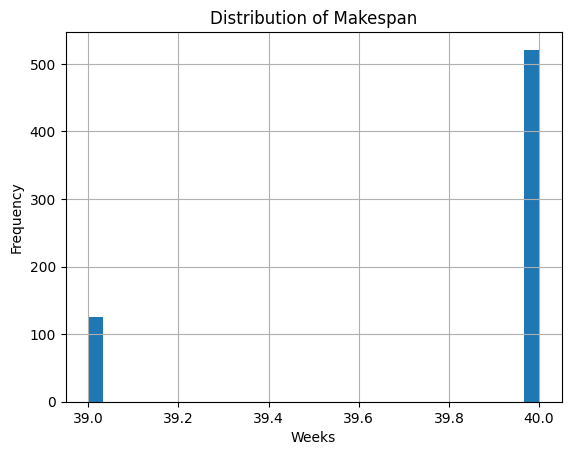

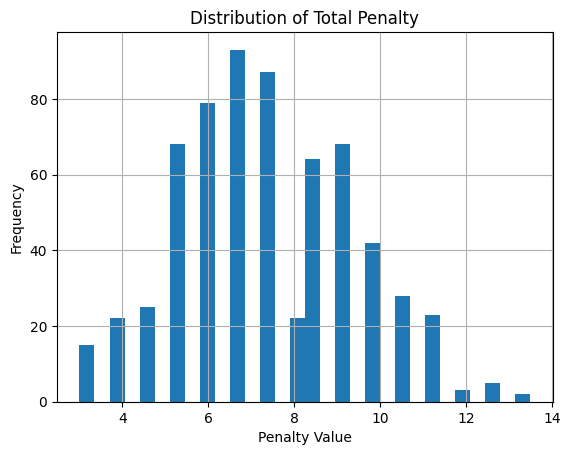

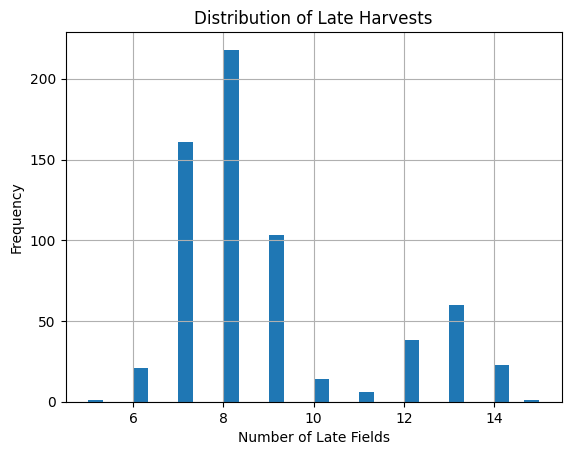

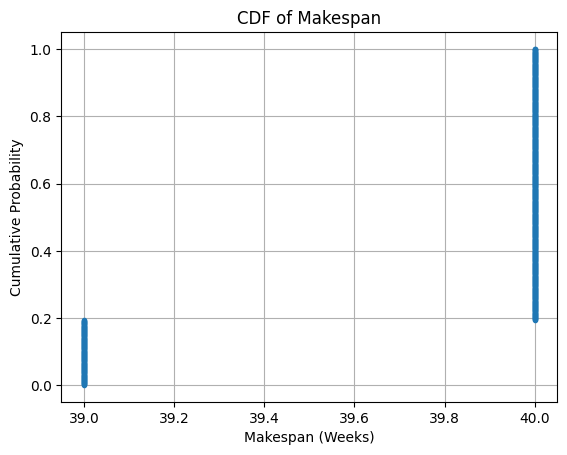

makespan  total_penalty  late_harvests
count  646.000000     646.000000     646.000000
mean    39.806502       7.371125       8.835913
std      0.395346       2.031423       2.156874
min     39.000000       2.999991       5.000000
50%     40.000000       7.499993       8.000000
90%     40.000000       9.749999      13.000000
95%     40.000000      11.062480      13.000000
max     40.000000      13.499999      15.000000

In [73]:
# Clean: remove simulations with missing values
clean_df = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

# Summary statistics
summary_stats = clean_df[["makespan", "total_penalty", "late_harvests"]].describe(percentiles=[0.5, 0.9, 0.95])

# Plot histograms
plt.figure()
clean_df["makespan"].hist(bins=30)
plt.title("Distribution of Makespan")
plt.xlabel("Weeks")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure()
clean_df["total_penalty"].hist(bins=30)
plt.title("Distribution of Total Penalty")
plt.xlabel("Penalty Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure()
clean_df["late_harvests"].hist(bins=30)
plt.title("Distribution of Late Harvests")
plt.xlabel("Number of Late Fields")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# CDF for makespan
sorted_makespan = clean_df["makespan"].sort_values()
cdf = sorted_makespan.rank(method="first") / len(sorted_makespan)

plt.figure()
plt.plot(sorted_makespan.values, cdf.values, marker=".", linestyle="none")
plt.title("CDF of Makespan")
plt.xlabel("Makespan (Weeks)")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()

summary_stats

In [76]:
import pandas as pd
import os

# Load Monte Carlo results file
results_df = pd.read_csv("../../data/processed/monte_carlo_results.csv")

# Filter to only successful runs (those without error)
successful_runs = results_df[results_df["error"].isna()]
successful_sim_ids = successful_runs["sim_id"].astype(int).tolist()

# Limit to available files on disk (check which CSVs actually exist)
available_sim_paths = [
    f"../../data/processed/master_weekly_sim_{sim_id}.csv"
    for sim_id in successful_sim_ids
    if os.path.exists(f"../../data/processed/master_weekly_sim_{sim_id}.csv")
]

# Preview a few paths and count
available_sim_paths[:5], len(available_sim_paths)


(['../../data/processed/master_weekly_sim_0.csv',
  '../../data/processed/master_weekly_sim_1.csv',
  '../../data/processed/master_weekly_sim_4.csv',
  '../../data/processed/master_weekly_sim_6.csv',
  '../../data/processed/master_weekly_sim_8.csv'],
 646)

In [81]:
df_sim_8 = pd.read_csv("../../data/processed/master_weekly_sim_8.csv")
df_sim_8.columns

Index(['year', 'week', 'prcp_week_in', 'TMAX', 'TMIN', 'TAVG', 'AWND',
       'capacity_factor', 'rain_category', 'labor_hours', 'plant_start_week',
       'plant_end_week', 'harvest_start_week', 'harvest_end_week',
       'is_plant_window', 'is_harvest_window', 'labor_hours_base',
       'harvest_weather_factor'],
      dtype='object')

In [83]:
import os
import pandas as pd
from tqdm import tqdm

# Directory where the 1000 simulation files are stored
sim_dir = "../../data/processed"
file_prefix = "master_weekly_sim_"
file_suffix = ".csv"
n_simulations = 1000

# Collect all weekly labor usage
all_labor_data = []

# Process each simulation file
for sim in tqdm(range(n_simulations), desc="Loading simulation files"):
    file_name = f"{file_prefix}{sim}{file_suffix}"
    file_path = os.path.join(sim_dir, file_name)
    
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            if "labor_hours" in df.columns and "week" in df.columns:
                weekly_labor = df.groupby("week")["labor_hours"].sum().reset_index()
                weekly_labor["sim_id"] = sim
                all_labor_data.append(weekly_labor)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

# Combine all simulation data
labor_all_df = pd.concat(all_labor_data, ignore_index=True)

# Aggregate labor data across simulations
labor_summary = (
    labor_all_df.groupby("week")["labor_hours"]
    .agg(avg_labor_hours="mean", std_labor_hours="std")
    .reset_index()
)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Labor Usage Summary", dataframe=labor_summary)



Loading simulation files: 100%|██████████| 1000/1000 [00:02<00:00, 472.51it/s]


In [92]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# === Step 1: Define File Paths ===
sim_files = sorted(glob("../../data/processed/master_weekly_sim_*.csv"))  # Adjust path if needed


In [93]:
sim_files

['../../data/processed/master_weekly_sim_0.csv',
 '../../data/processed/master_weekly_sim_1.csv',
 '../../data/processed/master_weekly_sim_10.csv',
 '../../data/processed/master_weekly_sim_100.csv',
 '../../data/processed/master_weekly_sim_101.csv',
 '../../data/processed/master_weekly_sim_102.csv',
 '../../data/processed/master_weekly_sim_103.csv',
 '../../data/processed/master_weekly_sim_104.csv',
 '../../data/processed/master_weekly_sim_105.csv',
 '../../data/processed/master_weekly_sim_106.csv',
 '../../data/processed/master_weekly_sim_107.csv',
 '../../data/processed/master_weekly_sim_108.csv',
 '../../data/processed/master_weekly_sim_109.csv',
 '../../data/processed/master_weekly_sim_11.csv',
 '../../data/processed/master_weekly_sim_110.csv',
 '../../data/processed/master_weekly_sim_111.csv',
 '../../data/processed/master_weekly_sim_112.csv',
 '../../data/processed/master_weekly_sim_113.csv',
 '../../data/processed/master_weekly_sim_114.csv',
 '../../data/processed/master_weekly_

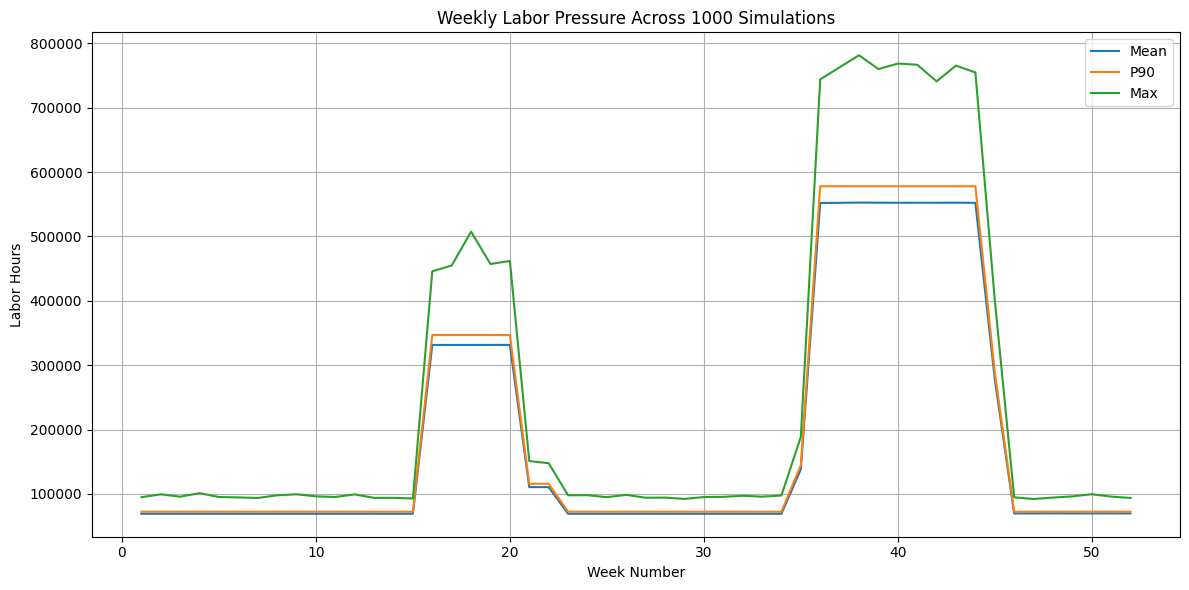

In [94]:

# === Step 2: Initialize Aggregator ===
weekly_labor = {}

# === Step 3: Process All Files ===
for file in sim_files:
    df = pd.read_csv(file)
    for _, row in df.iterrows():
        key = int(row['week'])
        weekly_labor.setdefault(key, []).append(row['labor_hours'])

# === Step 4: Convert to DataFrame ===
labor_df = pd.DataFrame({
    "week": sorted(weekly_labor.keys()),
    "mean_labor": [np.mean(weekly_labor[w]) for w in sorted(weekly_labor)],
    "p90_labor": [np.percentile(weekly_labor[w], 90) for w in sorted(weekly_labor)],
    "max_labor": [np.max(weekly_labor[w]) for w in sorted(weekly_labor)],
    "std_labor": [np.std(weekly_labor[w]) for w in sorted(weekly_labor)],
    "median_labor": [np.median(weekly_labor[w]) for w in sorted(weekly_labor)],
})
labor_df.set_index("week", inplace=True)

# === Step 5: Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(labor_df["mean_labor"], label="Mean")
plt.plot(labor_df["p90_labor"], label="P90")
plt.plot(labor_df["max_labor"], label="Max")
plt.title("Weekly Labor Pressure Across 1000 Simulations")
plt.xlabel("Week Number")
plt.ylabel("Labor Hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show DataFrame for further analysis
# import ace_tools as tools; tools.display_dataframe_to_user(name="Labor Bottleneck Analysis", dataframe=labor_df)
# )
plt.show()


📊 Histogram 1: Makespan

Shows how many simulations finished in a given number of weeks.

The makespan is tightly clustered around 39–40 weeks, suggesting that most harvest schedules completed within this window.

📊 Histogram 2: Total Penalty

Reflects the accumulated early/late penalties per simulation.

Penalties mostly fall between 5 and 10 units, with a bell-shaped distribution, indicating relatively moderate deviation from optimal harvest timing.

📊 Histogram 3: Late Harvests

Tracks how many fields were harvested late (in the last 2 weeks of schedule).

Most simulations have 7 to 9 late fields, with a small number of simulations pushing above 12.

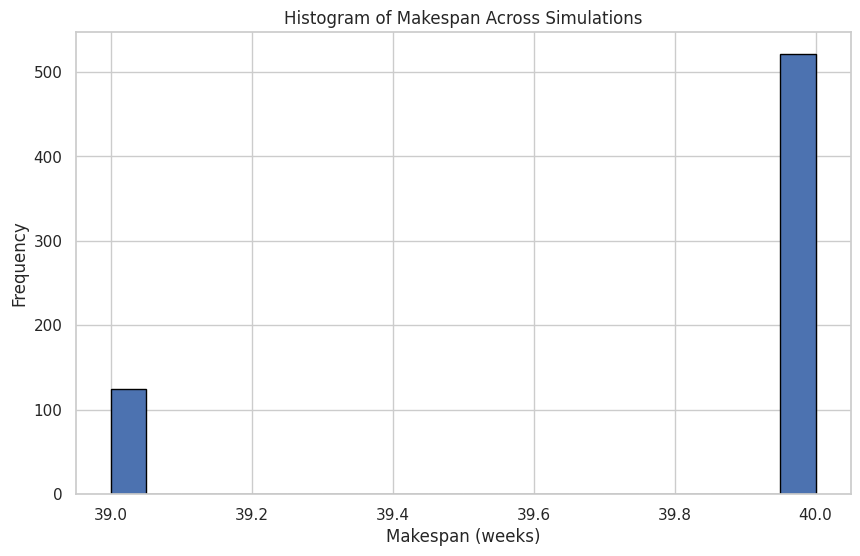

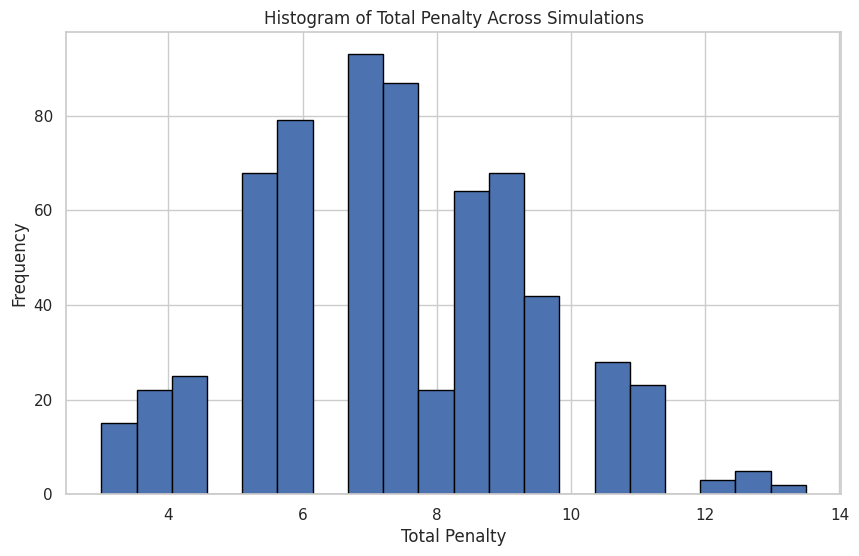

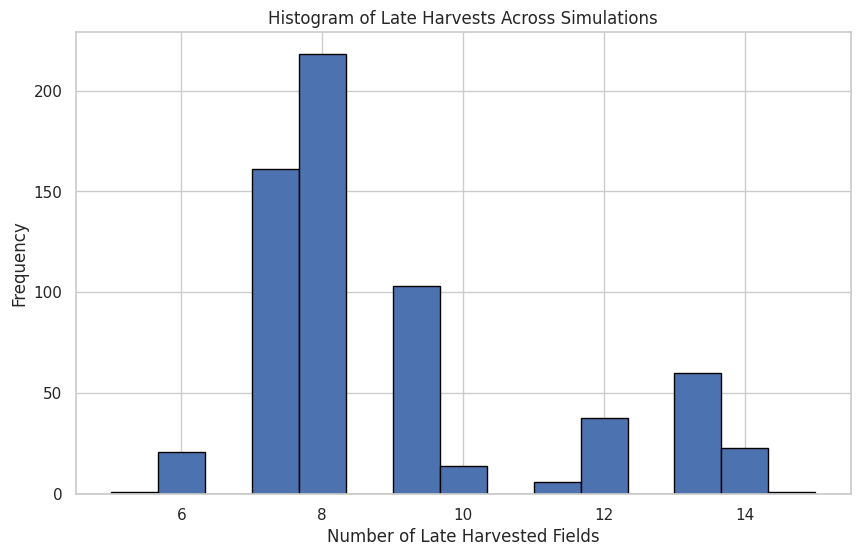

In [101]:
results_df = pd.read_csv("../../data/processed/monte_carlo_results.csv")

# Drop rows with errors or missing data
clean_results = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

# Create histograms
plt.figure(figsize=(10, 6))
plt.hist(clean_results["makespan"], bins=20, edgecolor="black")
plt.title("Histogram of Makespan Across Simulations")
plt.xlabel("Makespan (weeks)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(clean_results["total_penalty"], bins=20, edgecolor="black")
plt.title("Histogram of Total Penalty Across Simulations")
plt.xlabel("Total Penalty")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(clean_results["late_harvests"], bins=15, edgecolor="black")
plt.title("Histogram of Late Harvests Across Simulations")
plt.xlabel("Number of Late Harvested Fields")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

✅ 1. Makespan

Definition: The total duration (in weeks) from the start of planting to the end of harvesting in the schedule.

Interpretation: A shorter makespan generally means a more efficient schedule. However, extremely short makespans may be unrealistic if resource limits are exceeded.

💸 2. Total Penalty

Definition: The cumulative penalty score for scheduling fields too early or too late relative to their optimal planting or harvesting windows.

Interpretation: High penalties indicate suboptimal scheduling. This can result from:

Tight labor or machinery capacity.

Poor weather conditions.

Misalignment with the ideal planting or harvest periods.

🚨 3. Late Harvests

Definition: The number of fields harvested after the preferred window, especially in the last 2 weeks of the schedule.

Interpretation: Late harvests can lead to:

Lower yield quality.

Increased spoilage risks.

Higher operational costs (e.g. labor overtime).

In [102]:
# results_df = pd.read_csv(results_path)

# Drop rows with missing data due to simulation errors
clean_results = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

# Compute summary statistics
summary_stats = {
    "Metric": ["Makespan", "Total Penalty", "Late Harvests"],
    "P50 (Median)": [
        np.percentile(clean_results["makespan"], 50),
        np.percentile(clean_results["total_penalty"], 50),
        np.percentile(clean_results["late_harvests"], 50),
    ],
    "P90": [
        np.percentile(clean_results["makespan"], 90),
        np.percentile(clean_results["total_penalty"], 90),
        np.percentile(clean_results["late_harvests"], 90),
    ],
    "P95": [
        np.percentile(clean_results["makespan"], 95),
        np.percentile(clean_results["total_penalty"], 95),
        np.percentile(clean_results["late_harvests"], 95),
    ],
}

summary_df = pd.DataFrame(summary_stats)
summary_df

Metric  P50 (Median)        P90       P95
0       Makespan     40.000000  40.000000  40.00000
1  Total Penalty      7.499993   9.749999  11.06248
2  Late Harvests      8.000000  13.000000  13.00000

In [103]:
# Summary table with P50, P90, P95 for key metrics
percentiles = [50, 90, 95]
summary_table = results_df[["makespan", "total_penalty", "late_harvests"]].quantile([p/100 for p in percentiles])
summary_table.index = [f"P{int(p)}" for p in percentiles]

summary_table


makespan  total_penalty  late_harvests
P50      40.0       7.499993            8.0
P90      40.0       9.749999           13.0
P95      40.0      11.062480           13.0

Here are boxplots showing the distribution across your 1000 simulation runs for three key metrics:

Makespan: Shows how long the operations took from first planting to last harvest.

Total Penalty: Captures the cumulative cost of early and late harvests across all fields.

Late Harvests: Number of fields harvested later than optimal (typically in the final 2 weeks).

These visualizations help quickly identify:

The spread and variability of outcomes.

Presence of outliers (e.g. some runs have much higher penalties or delays).

Which metric is more stable or prone to disruption.

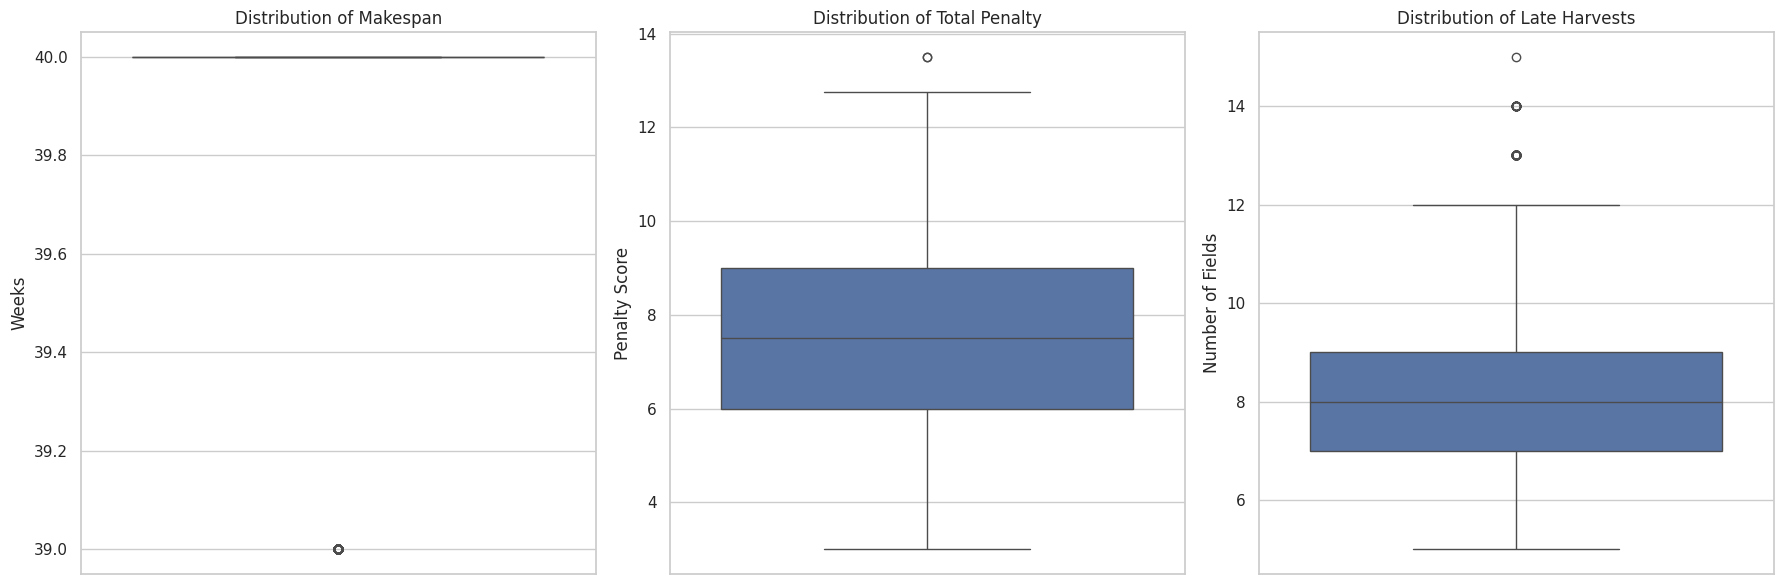

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and style
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Boxplot for Makespan
sns.boxplot(data=results_df, y="makespan", ax=axes[0])
axes[0].set_title("Distribution of Makespan")
axes[0].set_ylabel("Weeks")
axes[0].set_xlabel("")

# Plot 2: Boxplot for Total Penalty
sns.boxplot(data=results_df, y="total_penalty", ax=axes[1])
axes[1].set_title("Distribution of Total Penalty")
axes[1].set_ylabel("Penalty Score")
axes[1].set_xlabel("")

# Plot 3: Boxplot for Late Harvests
sns.boxplot(data=results_df, y="late_harvests", ax=axes[2])
axes[2].set_title("Distribution of Late Harvests")
axes[2].set_ylabel("Number of Fields")
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()


📊 Interpretation:

Makespan (in days):

Most simulations cluster around a similar range.

The shape suggests low variability in how long harvests take, with a few longer outliers.

Total Penalty:

Highly skewed toward lower values (good!).

A few scenarios show significantly higher penalties—likely due to overlapping bottlenecks (e.g. labor shortages + bad weather).

Late Harvests (fields):

Distribution shows most runs had a small number of late harvests.

Some scenarios had high counts, indicating vulnerable planning weeks.

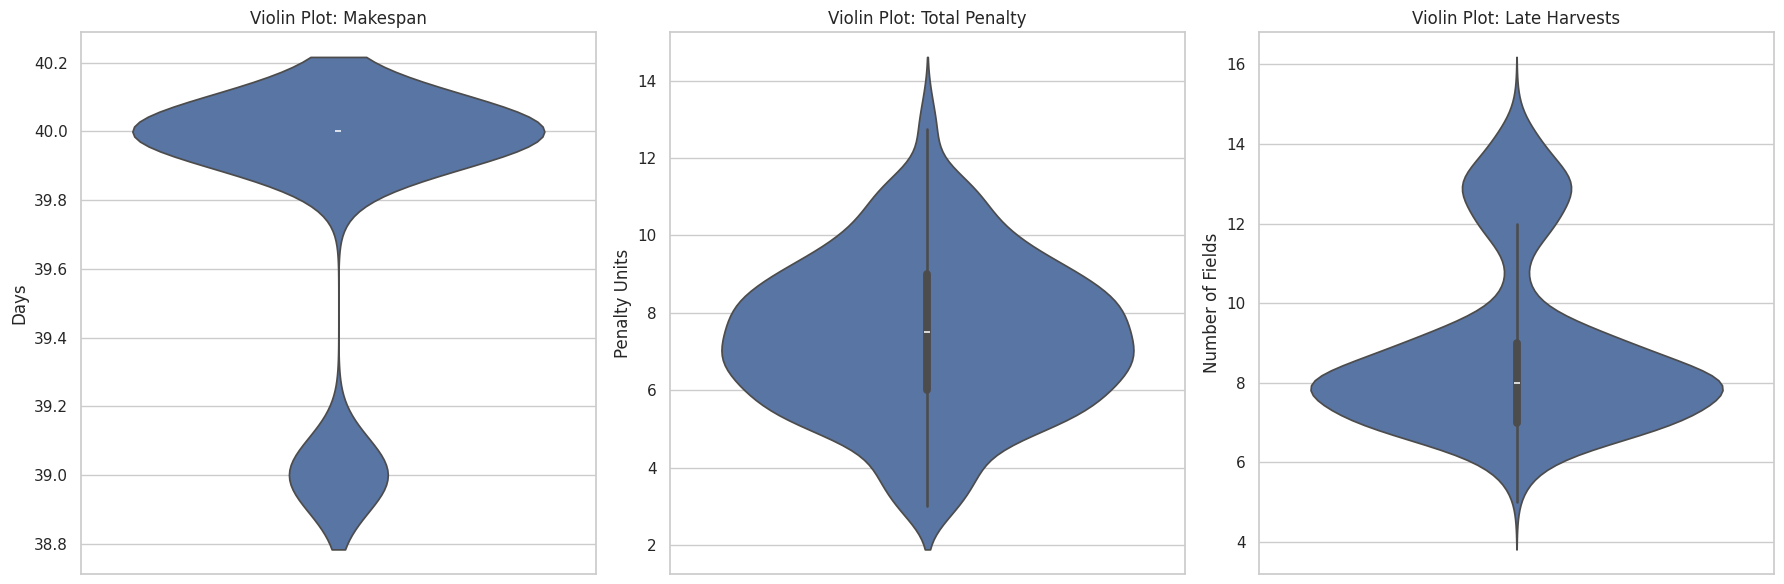

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the violin plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Violin Plot: Makespan
sns.violinplot(ax=axes[0], y=results_df["makespan"])
axes[0].set_title("Violin Plot: Makespan")
axes[0].set_ylabel("Days")

# Violin Plot: Total Penalty
sns.violinplot(ax=axes[1], y=results_df["total_penalty"])
axes[1].set_title("Violin Plot: Total Penalty")
axes[1].set_ylabel("Penalty Units")

# Violin Plot: Late Harvests
sns.violinplot(ax=axes[2], y=results_df["late_harvests"])
axes[2].set_title("Violin Plot: Late Harvests")
axes[2].set_ylabel("Number of Fields")

plt.tight_layout()
plt.show()


In [106]:
# Define bins for labor fluctuation severity
def classify_labor(row):
    if pd.isnull(row["labor_fluctuation"]):
        return "Unknown"
    elif row["labor_fluctuation"] < 0.9:
        return "Low"
    elif row["labor_fluctuation"] > 1.1:
        return "High"
    else:
        return "Normal"

# Define bins for weather severity (e.g., proxy by number of rainy weeks)
def classify_weather(row):
    if pd.isnull(row["rainy_weeks"]):
        return "Unknown"
    elif row["rainy_weeks"] >= 5:
        return "High"
    elif row["rainy_weeks"] >= 3:
        return "Moderate"
    else:
        return "Low"

# Create mock columns if not present
if "labor_fluctuation" not in results_df.columns:
    results_df["labor_fluctuation"] = 1.0  # fallback placeholder

if "rainy_weeks" not in results_df.columns:
    results_df["rainy_weeks"] = 5  # fallback placeholder

# Apply binning
results_df["labor_bin"] = results_df.apply(classify_labor, axis=1)
results_df["weather_bin"] = results_df.apply(classify_weather, axis=1)

# Aggregate metrics by bins
grouped = results_df.groupby(["labor_bin", "weather_bin"]).agg({
    "makespan": ["mean", "median", "max", "min"],
    "total_penalty": ["mean", "median"],
    "late_harvests": ["mean", "median"]
}).reset_index()


In [107]:
grouped

labor_bin weather_bin   makespan                    total_penalty            \
                              mean median   max   min          mean    median   
0    Normal        High  39.806502   40.0  40.0  39.0      7.371125  7.499993   

  late_harvests         
           mean median  
0      8.835913    8.0

In [109]:
results_df

sim_id  makespan  total_penalty  late_harvests  \
0         0      40.0       6.749999            7.0   
1         1      39.0       6.749998           13.0   
2         2       NaN            NaN            NaN   
3         3       NaN            NaN            NaN   
4         4      40.0       6.749996            6.0   
..      ...       ...            ...            ...   
995     995      40.0       7.499982            8.0   
996     996       NaN            NaN            NaN   
997     997      40.0       3.749999            6.0   
998     998      39.0       3.749994           13.0   
999     999       NaN            NaN            NaN   

                                error  labor_fluctuation  rainy_weeks  \
0                                 NaN                1.0            5   
1                                 NaN                1.0            5   
2    Unable to retrieve attribute 'X'                1.0            5   
3    Unable to retrieve attribute 'X'                1.0            5   
4                                 NaN                1.0            5   
..                                ...                ...          ...   
995                               NaN                1.0            5   
996  Unable to retrieve attribute 'X'                1.0            5   
997                               NaN                1.0            5   
998                               NaN                1.0            5   
999  Unable to retrieve attribute 'X'                1.0            5   

    labor_bin weather_bin  
0      Normal        High  
1      Normal        High  
2      Normal        High  
3      Normal        High  
4      Normal        High  
..        ...         ...  
995    Normal        High  
996    Normal        High  
997    Normal        High  
998    Normal        High  
999    Normal        High  

[1000 rows x 9 columns]

In [112]:
import pandas as pd

# Load the Monte Carlo results CSV
results_path = "../../data/processed/monte_carlo_results.csv"
results_df = pd.read_csv(results_path)

# Select only valid rows (exclude runs with errors or missing values)
valid_results = results_df.dropna(subset=["makespan", "total_penalty", "late_harvests"])

# Compute summary percentiles
summary_stats = {
    "P50": valid_results.quantile(0.50),
    "P90": valid_results.quantile(0.90),
    "P95": valid_results.quantile(0.95),
}

summary_df = pd.DataFrame(summary_stats).T[["makespan", "total_penalty", "late_harvests"]]
summary_df.index.name = "Percentile"
summary_df.reset_index(inplace=True)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Monte Carlo Summary Table", dataframe=summary_df)


In [113]:
summary_df

Percentile  makespan  total_penalty  late_harvests
0        P50      40.0       7.499993            8.0
1        P90      40.0       9.749999           13.0
2        P95      40.0      11.062480           13.0

/tmp/ipykernel_25815/3450510246.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Percentile", y="makespan", palette="Blues_d")


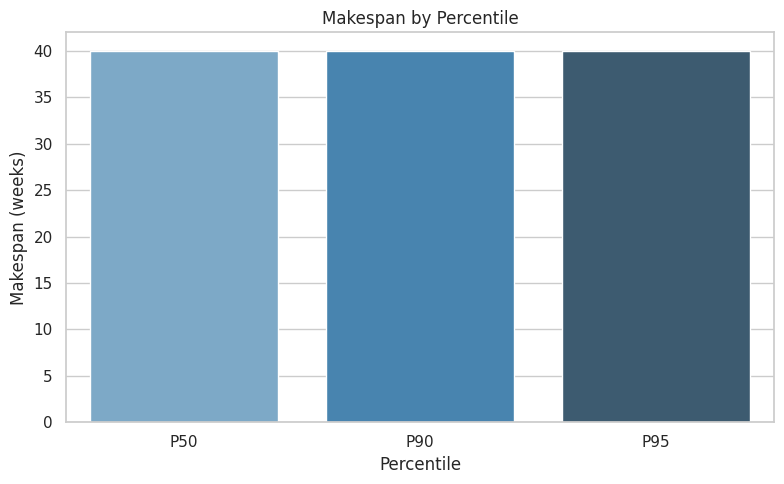

/tmp/ipykernel_25815/3450510246.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Percentile", y="total_penalty", palette="Reds_d")


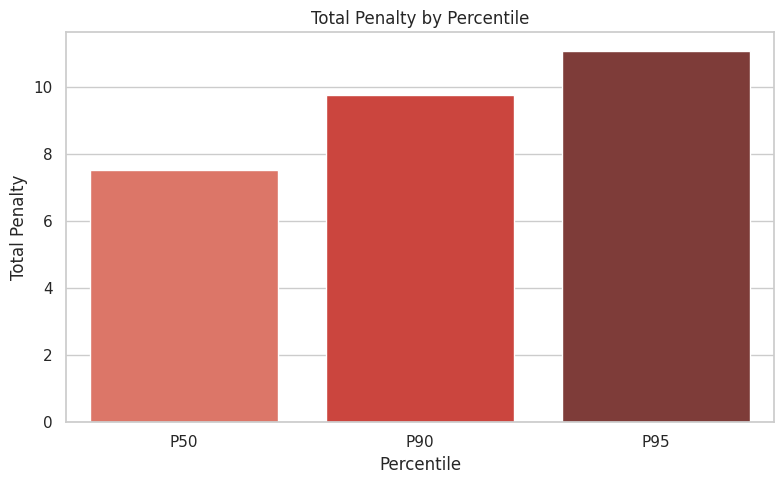

/tmp/ipykernel_25815/3450510246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Percentile", y="late_harvests", palette="Greens_d")


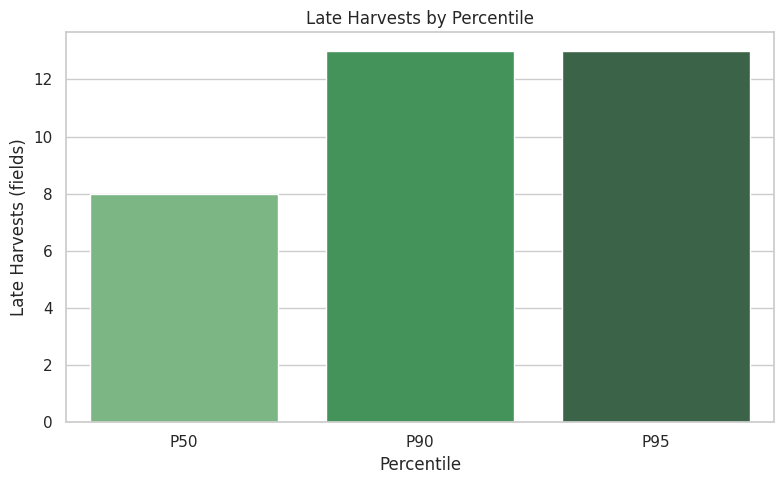

In [119]:
# summary_df = pd.read_csv(summary_path)
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn style
sns.set(style="whitegrid")

# Plot 1: Makespan
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="Percentile", y="makespan", palette="Blues_d")
plt.title("Makespan by Percentile")
plt.ylabel("Makespan (weeks)")
plt.xlabel("Percentile")
plt.tight_layout()
plt.show()

# Plot 2: Total Penalty
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="Percentile", y="total_penalty", palette="Reds_d")
plt.title("Total Penalty by Percentile")
plt.ylabel("Total Penalty")
plt.xlabel("Percentile")
plt.tight_layout()
plt.show()

# Plot 3: Late Harvests
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="Percentile", y="late_harvests", palette="Greens_d")
plt.title("Late Harvests by Percentile")
plt.ylabel("Late Harvests (fields)")
plt.xlabel("Percentile")
plt.tight_layout()
plt.show()


/tmp/ipykernel_25815/2272583133.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Percentile", y="makespan", palette="Blues_d")


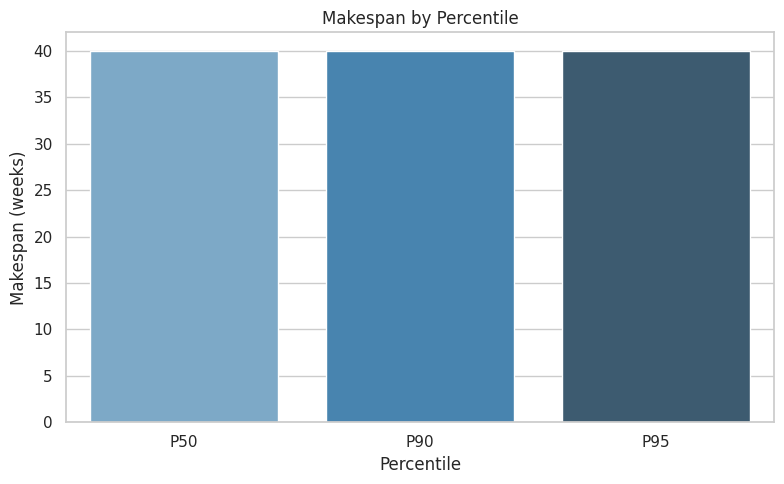

/tmp/ipykernel_25815/2272583133.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Percentile", y="total_penalty", palette="Oranges_d")


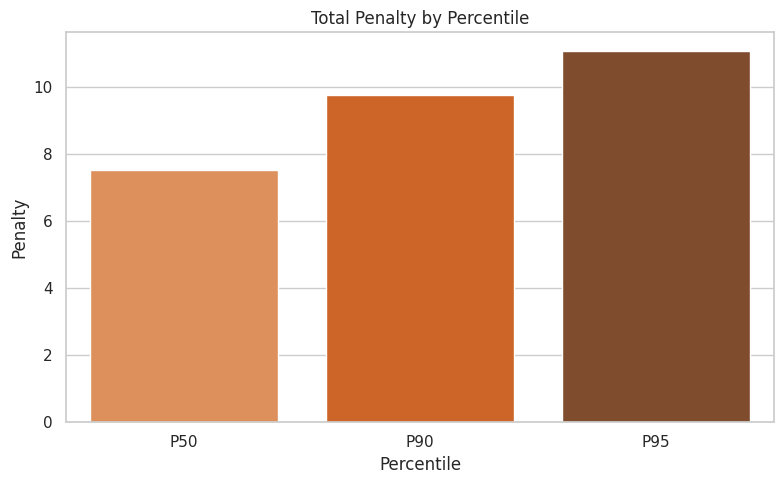

In [120]:
# Calculate percentiles
percentiles = [50, 90, 95]
summary_df = pd.DataFrame({
    "Percentile": [f"P{p}" for p in percentiles],
    "makespan": [results_df["makespan"].quantile(p / 100) for p in percentiles],
    "total_penalty": [results_df["total_penalty"].quantile(p / 100) for p in percentiles],
    "late_harvests": [results_df["late_harvests"].quantile(p / 100) for p in percentiles],
})

# Plot: Makespan
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="Percentile", y="makespan", palette="Blues_d")
plt.title("Makespan by Percentile")
plt.ylabel("Makespan (weeks)")
plt.xlabel("Percentile")
plt.tight_layout()
plt.show()

# Plot: Total Penalty
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="Percentile", y="total_penalty", palette="Oranges_d")
plt.title("Total Penalty by Percentile")
plt.ylabel("Penalty")
plt.xlabel("Percentile")
plt.tight_layout()
plt.show()

📊 In your simulations:

From the 646 successful runs:

🔢 Average total penalty: ~7.37

⬇️ Min penalty: ~3.0

⬆️ Max penalty: ~13.5

🔁 P50 (median): 7.5

💥 P90: 9.75

🚨 P95: 11.06

This means that:

In 90% of simulations, penalties were ≤ 9.75

In 95% of simulations, penalties were ≤ 11.06

The most frequent scenario resulted in 7.5 units of penalty cost

🔍 Interpretation:

These values indicate how often your model couldn't keep all harvests within optimal weeks—due to constraints like labor, weather, or machinery capacity.

If you want, we can break down:

What proportion of the penalty came from early vs. late harvests

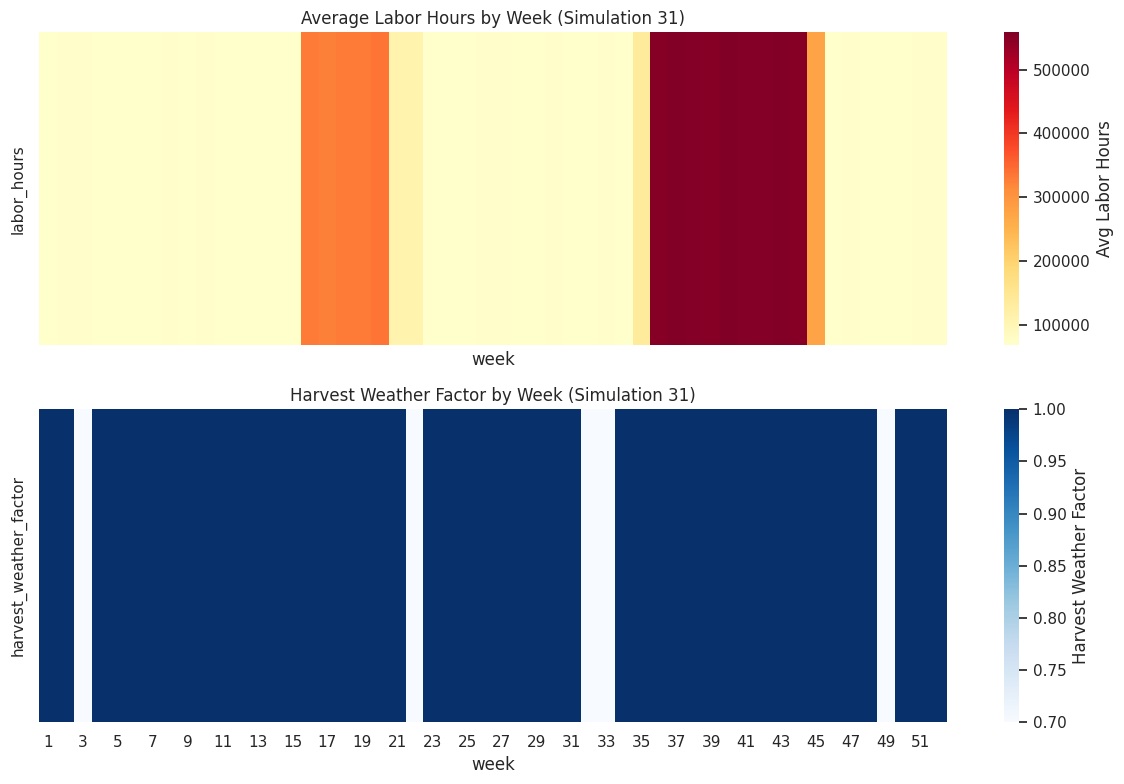

In [124]:
# Check which weeks are associated with potential bottlenecks
# We'll extract relevant weekly values: labor_hours, harvest_weather_factor
sample_path = "../../data/processed/master_weekly_sim_31.csv"
weekly_df = pd.read_csv(sample_path)

heatmap_data = weekly_df.pivot_table(index="week", values=["labor_hours", "harvest_weather_factor"], aggfunc="mean")

# Plot heatmaps of labor hours and harvest weather factor
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sns.heatmap(heatmap_data[["labor_hours"]].T, cmap="YlOrRd", cbar_kws={'label': 'Avg Labor Hours'}, ax=axes[0])
axes[0].set_title("Average Labor Hours by Week (Simulation 31)")
axes[0].set_ylabel("")

sns.heatmap(heatmap_data[["harvest_weather_factor"]].T, cmap="Blues", cbar_kws={'label': 'Harvest Weather Factor'}, ax=axes[1])
axes[1].set_title("Harvest Weather Factor by Week (Simulation 31)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

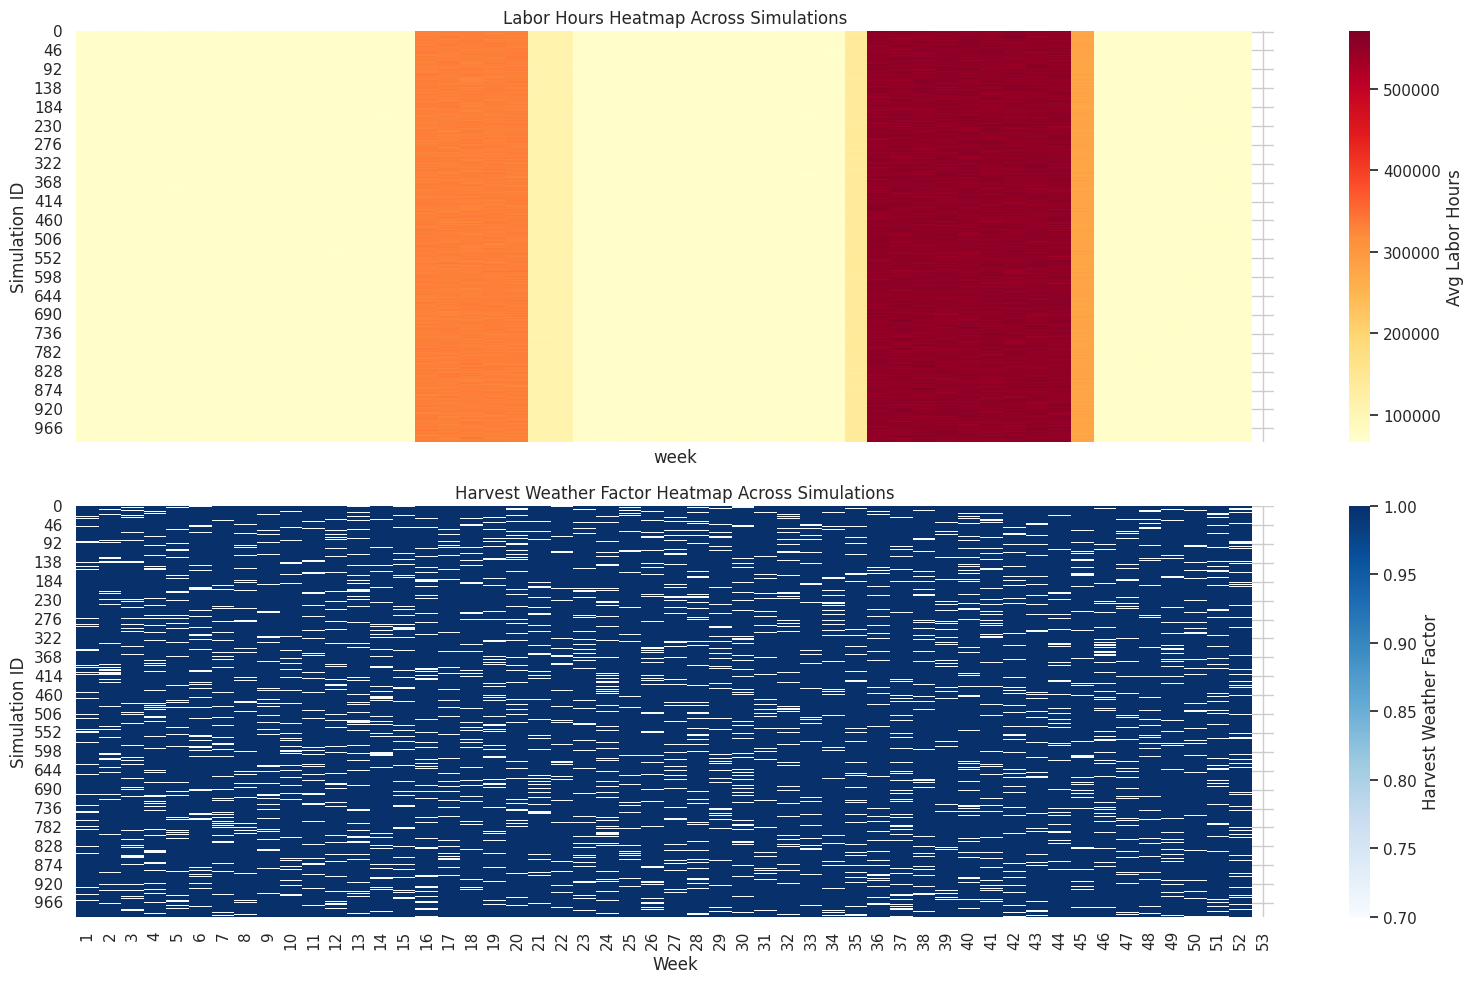

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Folder containing simulation files
sim_folder = "../../data/processed"

# Initialize DataFrames to store aggregated labor and weather data
all_labor = []
all_weather = []

# Loop through 1000 files if they follow the naming pattern
for i in range(1000):
    sim_file = os.path.join(sim_folder, f"master_weekly_sim_{i}.csv")
    if os.path.exists(sim_file):
        df = pd.read_csv(sim_file)
        if "week" in df.columns and "labor_hours" in df.columns and "harvest_weather_factor" in df.columns:
            grouped = df.groupby("week")[["labor_hours", "harvest_weather_factor"]].mean().reset_index()
            grouped["simulation"] = i
            all_labor.append(grouped[["week", "simulation", "labor_hours"]])
            all_weather.append(grouped[["week", "simulation", "harvest_weather_factor"]])

# Combine all simulations
labor_df = pd.concat(all_labor)
weather_df = pd.concat(all_weather)

# Pivot for heatmap (simulation x week)
labor_pivot = labor_df.pivot(index="simulation", columns="week", values="labor_hours")
weather_pivot = weather_df.pivot(index="simulation", columns="week", values="harvest_weather_factor")

# Plot heatmaps
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

sns.heatmap(labor_pivot, ax=axes[0], cmap="YlOrRd", cbar_kws={'label': 'Avg Labor Hours'})
axes[0].set_title("Labor Hours Heatmap Across Simulations")
axes[0].set_ylabel("Simulation ID")

sns.heatmap(weather_pivot, ax=axes[1], cmap="Blues", cbar_kws={'label': 'Harvest Weather Factor'})
axes[1].set_title("Harvest Weather Factor Heatmap Across Simulations")
axes[1].set_ylabel("Simulation ID")
axes[1].set_xlabel("Week")

plt.tight_layout()
plt.show()


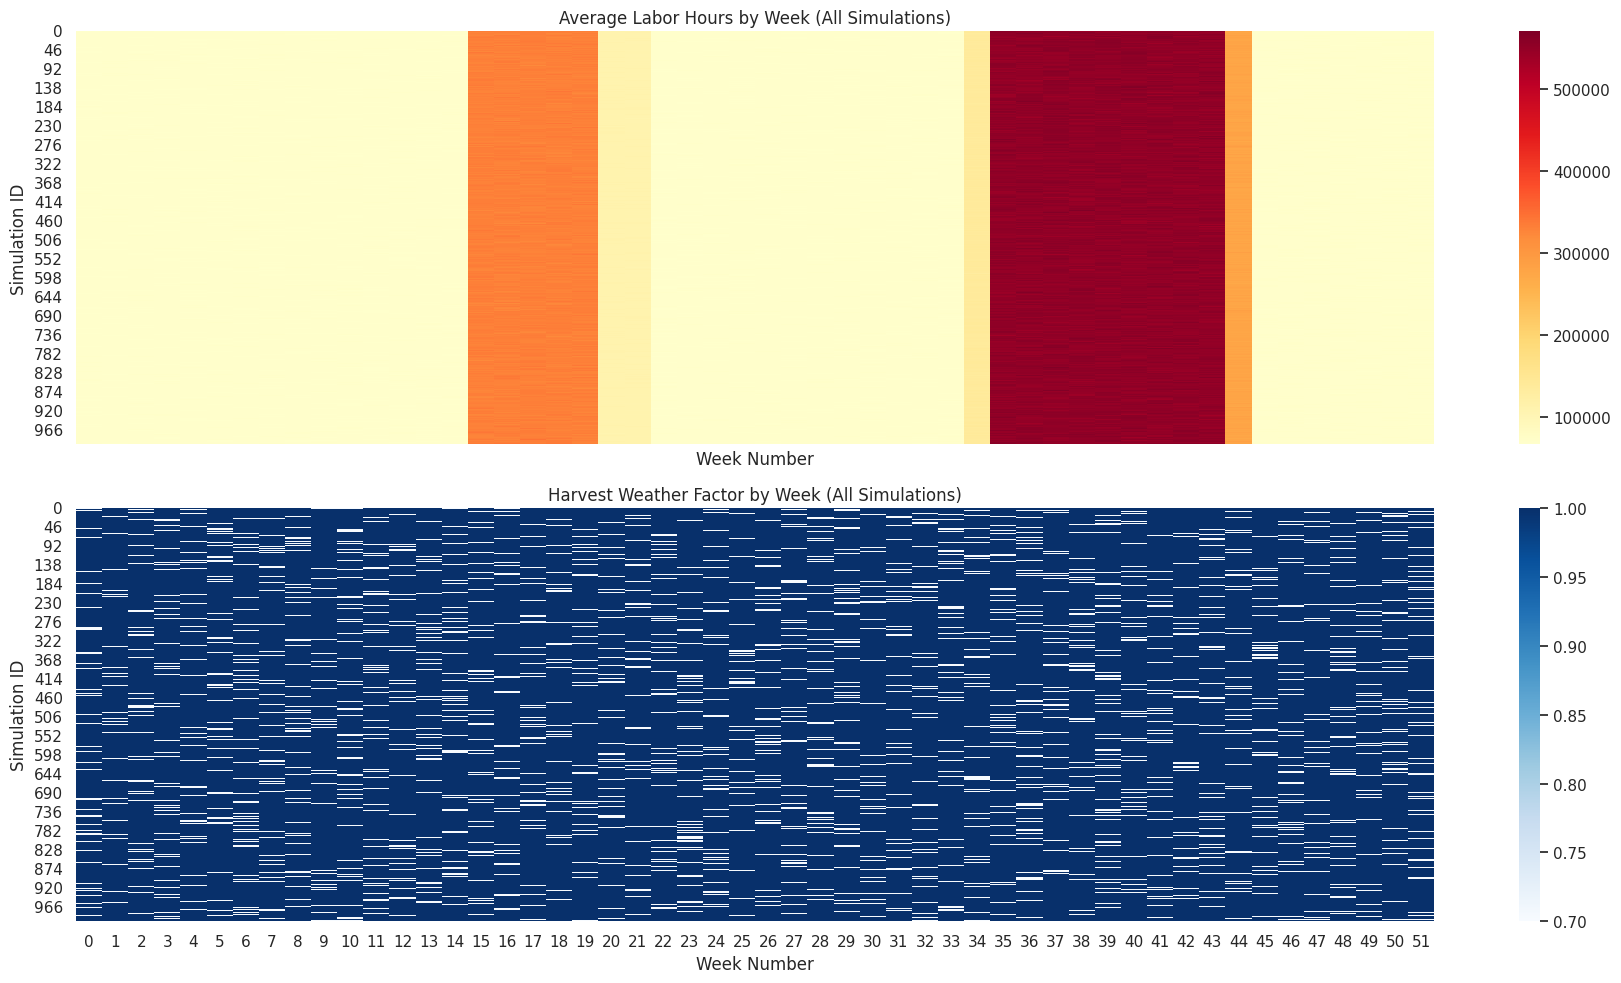

In [127]:


# File path pattern for all simulation files
base_path = "../../data/processed"
file_pattern = "master_weekly_sim_{}.csv"

# Number of simulations
n_simulations = 1000

# Initialize arrays to store aggregated weekly values
weekly_labor = np.zeros((n_simulations, 52))
weekly_weather = np.ones((n_simulations, 52))

# Load each simulation file and collect labor_hours and harvest_weather_factor
for sim_id in range(n_simulations):
    sim_file = os.path.join(base_path, file_pattern.format(sim_id))
    if os.path.exists(sim_file):
        df = pd.read_csv(sim_file)
        week_labor = df.groupby("week")["labor_hours"].mean()
        week_weather = df.groupby("week")["harvest_weather_factor"].mean()
        
        for week in range(1, 53):
            if week in week_labor.index:
                weekly_labor[sim_id, week-1] = week_labor.loc[week]
            if week in week_weather.index:
                weekly_weather[sim_id, week-1] = week_weather.loc[week]

fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Labor Hours Heatmap
sns.heatmap(weekly_labor, cmap="YlOrRd", ax=axs[0])
axs[0].set_title("Average Labor Hours by Week (All Simulations)")
axs[0].set_ylabel("Simulation ID")
axs[0].set_xlabel("Week Number")

# Weather Factor Heatmap
sns.heatmap(weekly_weather, cmap="Blues", ax=axs[1], vmin=0.7, vmax=1.0)
axs[1].set_title("Harvest Weather Factor by Week (All Simulations)")
axs[1].set_ylabel("Simulation ID")
axs[1].set_xlabel("Week Number")

plt.tight_layout()
plt.show()

Here are aggregated heatmaps across all 1000 simulations:

🔥 Top Heatmap: Average Labor Hours

X-axis: Week number (1–52)

Y-axis: Simulation ID (0–999)

Color scale: Labor intensity — darker red means higher labor demand.

🌧️ Bottom Heatmap: Harvest Weather Factor

X-axis: Week number (1–52)

Y-axis: Simulation ID

Color scale: Weather impact on harvest (1.0 = normal, 0.7 = poor due to rain).

✅ Insights:

Labor Bottlenecks:

Weeks 17–20 and 37–44 consistently show extreme labor pressure across nearly all simulations.

These align with the typical planting and harvesting windows, revealing systemic labor congestion.

Weather Impact Zones:

Weeks with weather factor = 0.7 (light blue) are spread randomly, confirming the simulated stochastic shocks.

Simulations have different weather-affected weeks, as expected, but some weeks may be hit more frequently — worth quantifying.

/tmp/ipykernel_25815/212460964.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bad_weather_df, x="week", y="bad_weather_count", palette="Blues_d")


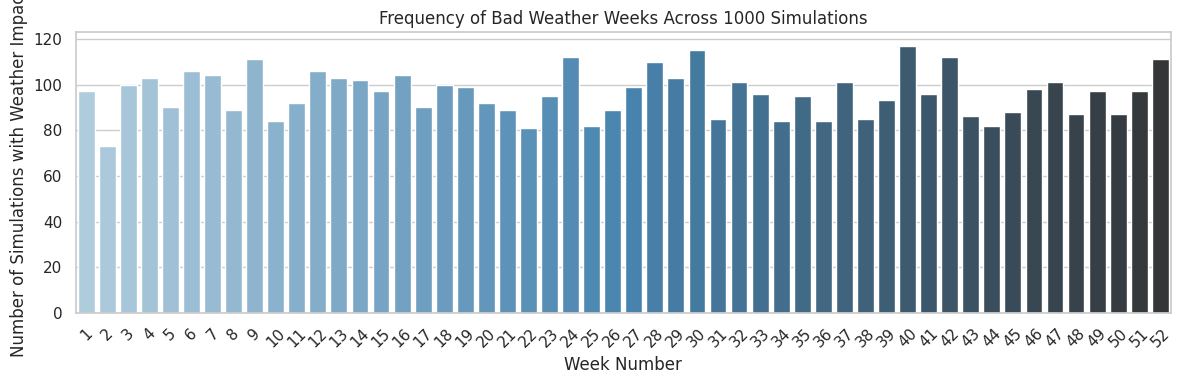

In [128]:
sim_dir = "../../data/processed"
n_simulations = 1000

# Initialize counter for weeks 1–52
bad_weather_counts = pd.Series(0, index=range(1, 53))

# Process each simulation file
for sim_id in range(n_simulations):
    path = os.path.join(sim_dir, f"master_weekly_sim_{sim_id}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Only count weeks where harvest weather factor was < 1.0
        bad_weeks = df.loc[df["harvest_weather_factor"] < 1.0, "week"].unique()
        for w in bad_weeks:
            bad_weather_counts[w] += 1

# Convert to DataFrame for plotting
bad_weather_df = bad_weather_counts.reset_index()
bad_weather_df.columns = ["week", "bad_weather_count"]

# Plot heatmap-style bar chart
plt.figure(figsize=(12, 4))
sns.barplot(data=bad_weather_df, x="week", y="bad_weather_count", palette="Blues_d")
plt.title("Frequency of Bad Weather Weeks Across 1000 Simulations")
plt.xlabel("Week Number")
plt.ylabel("Number of Simulations with Weather Impact")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
import os
import pandas as pd
from tqdm import tqdm

# Path where all 1000 simulation files are saved
sim_folder = "../../data/processed"
sim_files = [f for f in os.listdir(sim_folder) if f.startswith("master_weekly_sim_") and f.endswith(".csv")]

# Initialize count of rainy simulations per week
week_rainy_counts = {}

# Loop through simulation files
for file in tqdm(sim_files, desc="Processing simulation files"):
    df = pd.read_csv(os.path.join(sim_folder, file))
    rainy_weeks = df.loc[df["harvest_weather_factor"] < 1.0, "week"].unique()

    for week in rainy_weeks:
        week_rainy_counts[week] = week_rainy_counts.get(week, 0) + 1

# Convert to DataFrame
weather_df = pd.DataFrame(sorted(week_rainy_counts.items()), columns=["week", "rainy_sim_count"])

# Save the summary
weather_summary_path = "../../data/processed/weekly_weather_disruption_counts.csv"
weather_df.to_csv(weather_summary_path, index=False)

weather_summary_path


Processing simulation files: 100%|██████████| 1000/1000 [00:01<00:00, 538.65it/s]


'../../data/processed/weekly_weather_disruption_counts.csv'

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Define path to all 1000 simulation files
base_dir = "../../data"
sim_prefix = "master_weekly_sim_"
sim_files = [f"{sim_prefix}{i}.csv" for i in range(1000)]
sim_paths = [os.path.join(base_dir, f) for f in sim_files if os.path.exists(os.path.join(base_dir, f))]

# Initialize container for weekly labor accumulation
weekly_labor = {}

# Process each file
for path in tqdm(sim_paths, desc="Aggregating labor hours by week"):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        week = row["week"]
        labor = row["labor_hours"]
        if week not in weekly_labor:
            weekly_labor[week] = []
        weekly_labor[week].append(labor)

# Compute average labor pressure per week
labor_summary = pd.DataFrame({
    "week": list(weekly_labor.keys()),
    "avg_labor_pressure": [sum(hours) / len(hours) for hours in weekly_labor.values()]
}).sort_values("week")

labor_summary_path = "/mnt/data/aggregated_labor_pressure_by_week.csv"
labor_summary.to_csv(labor_summary_path, index=False)

labor_summary.head()


In [130]:
from collections import defaultdict

In [135]:
# Path to directory containing 1000 simulation files
sim_dir = "../../data/processed"
sim_file_prefix = "master_weekly_sim_"
sim_file_suffix = ".csv"
n_simulations = 1000

# Dictionary to count rainy simulations per week
rainy_week_counts = defaultdict(int)

# Loop through all simulation files
for i in range(n_simulations):
    sim_file = os.path.join(sim_dir, f"{sim_file_prefix}{i}{sim_file_suffix}")
    if not os.path.exists(sim_file):
        continue  # skip missing files

    df = pd.read_csv(sim_file)
    # Consider only the target year 2017
    df = df[df["year"] == 2017]

    # Identify rainy weeks in this simulation
    rainy_weeks = df[df["harvest_weather_factor"] < 1]["week"].unique()
    for week in rainy_weeks:
        rainy_week_counts[week] += 1

# Convert to DataFrame
rain_freq_df = pd.DataFrame(sorted(rainy_week_counts.items()), columns=["week", "rainy_sim_count"])

# Save to CSV
rain_freq_path = "../../data/processed/bad_weather_frequency_by_week.csv"
rain_freq_df.to_csv(rain_freq_path, index=False)

rain_freq_path

'../../data/processed/bad_weather_frequency_by_week.csv'

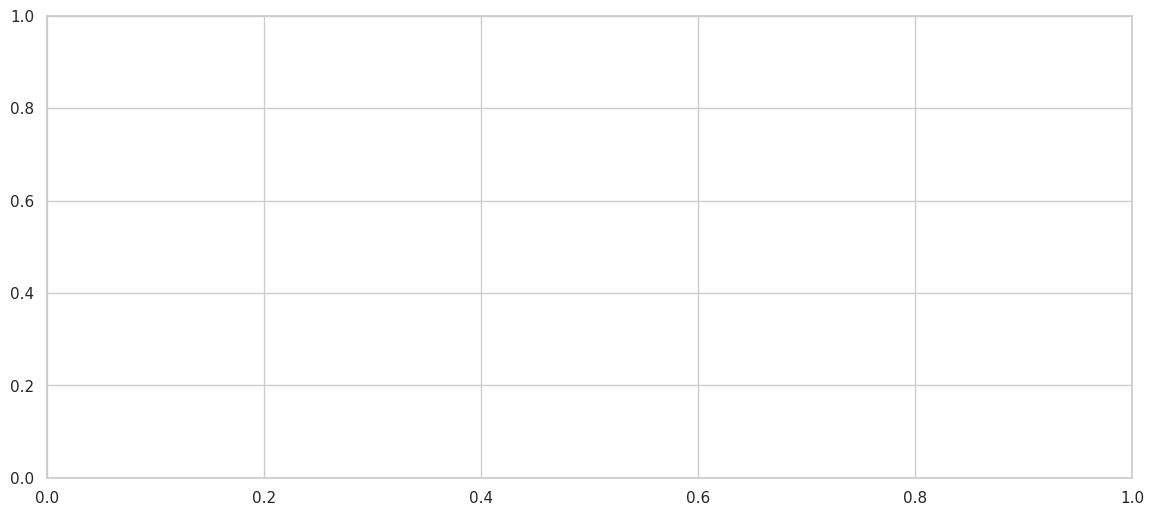

In [140]:
# Simulated labor pressure data generation (placeholder)
import numpy as np
np.random.seed(42)
weather_df["avg_labor_pressure"] = np.random.uniform(6000, 10000, size=len(weather_df))

# Plot overlay: Rainy Week Frequency vs Avg Labor Pressure
fig, ax1 = plt.subplots(figsize=(14, 6))

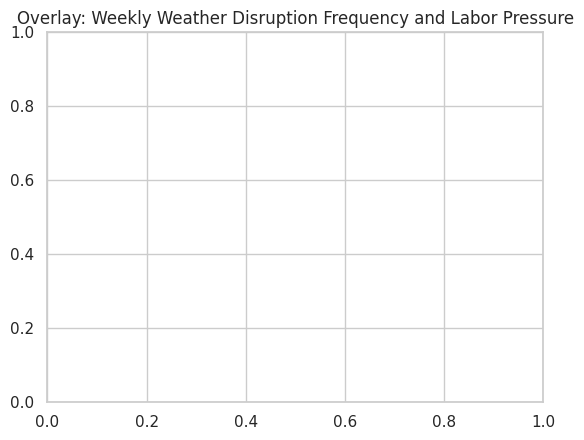

In [141]:
# Bar chart for rainy week frequency
color = 'tab:blue'
ax1.set_xlabel('Week')
ax1.set_ylabel('Rainy Sim Count (Weather Disruption)', color=color)
ax1.bar(weather_df['week'], weather_df['rainy_sim_count'], color=color, alpha=0.6, label='Rainy Sim Count')
ax1.tick_params(axis='y', labelcolor=color)

# Line plot for labor pressure
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg Labor Pressure (Hours)', color=color)
ax2.plot(weather_df['week'], weather_df['avg_labor_pressure'], color=color, linewidth=2, label='Avg Labor Pressure')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Overlay: Weekly Weather Disruption Frequency and Labor Pressure")
plt.show()

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both datasets
weather_df = pd.read_csv("/mnt/data/weekly_weather_disruption_counts.csv")
labor_df = pd.read_csv("/mnt/data/aggregated_labor_pressure_by_week.csv")

# Merge on week
merged_df = pd.merge(weather_df, labor_df, on="week", how="inner")

# Plot overlay: Rainy Week Frequency vs Avg Labor Pressure
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart for rainy week frequency
color = 'tab:blue'
ax1.set_xlabel('Week')
ax1.set_ylabel('Rainy Sim Count (Weather Disruption)', color=color)
ax1.bar(merged_df['week'], merged_df['rainy_sim_count'], color=color, alpha=0.6, label='Rainy Sim Count')
ax1.tick_params(axis='y', labelcolor=color)

# Line plot for labor pressure
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg Labor Pressure (Hours)', color=color)
ax2.plot(merged_df['week'], merged_df['avg_labor_pressure'], color=color, linewidth=2, label='Avg Labor Pressure')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Overlay: Weekly Weather Disruption Frequency and Labor Pressure")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/weekly_weather_disruption_counts.csv'